In [1]:
import numpy as np
from AFVB_PCE import *
from aPCE import *
from ME_PCE import *
from VRVM_PCE import *
import test_functions as tf
from sklearn.metrics import mean_squared_error
import skopt
import time
from skopt import BayesSearchCV
from sensitivity_analysis import *
from PCE_Full_Model import *
import scipy.integrate as integrate
import scipy.special as special
from scipy.stats import multivariate_normal

In [2]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import sys

In [3]:
## Directory where I want the plots saved
wd = '/Users/chave/Desktop/ThesisFiles/SparseBayesianLearning/images'

In [4]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

In [5]:
def collect_results_PCE(p, d, fun, hyper_params, X_train, X_pol, X_test, Y_train, PCE_method, sparse_model, B_init = None, sigma_vals = None, mu_vals = None):

    """
    p: list of p-values
    B_init: list of tthe form [[a,b],[a,b],...,[a,b]]
    sparse_method: AFVB_PCe or VRVM_PCe
    PCE_method: 'aPCE' or 'PCE_Legendre' or 'aPCE_Stieltjes'
    hyper_params: pxn_params array
    
    Return: Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, n_star
    """

    Error_full = []
    Error_sparse = []

    mean_sparse = []
    V_sparse = []
    mean_full = []
    V_full = []
    Si_sparse = []
    Ti_sparse = []
    n_star = []
    models = []
    
    sa = sobol_GSA(d, fun)

    for i in range(len(p)):
        
        if (PCE_method == 'aPCE'):
            mod = aPCE(X_pol, p[i]) 
            P = mod.Create_Orthonormal_Polynomials(p[i])
        elif (PCE_method == 'aPCE_Stieltjes'):
            mod = aPCE(X_pol, p[i]) 
            P = mod.Create_Orthonormal_Polynomials_Stieltjes(p[i])
        else:
            mod = None
            P = None
        t0 = time.time()
        temp_model = sparse_model(PCE_method, d, p[i], B_init, mod, P, list(hyper_params[i].values())[0], 
                                  list(hyper_params[i].values())[1], list(hyper_params[i].values())[2], 
                                  list(hyper_params[i].values())[3], sigma_vals = sigma_vals, mu_vals = mu_vals)
        temp_model.fit(X_train, Y_train)
        print(time.time()-t0)
        print(temp_model.n_star)
        models.append(temp_model)
        mean_sparse.append(temp_model.a_hat[0])
        V_sparse.append(sa.sobol_PCE(p[i], temp_model.a_hat, temp_model.active_cols)[1])
        mean_full.append(temp_model.a_full[0])
        n = int(math.factorial(d+p[i])/(math.factorial(d)*math.factorial(p[i])))
        V_full.append(sa.sobol_PCE(p[i], temp_model.a_full, np.array(range(n)))[1])        
        Si_sparse.append(sa.sobol_PCE(p[i], temp_model.a_hat, temp_model.active_cols)[0]['1st Order'])
        Ti_sparse.append(sa.sobol_PCE(p[i], temp_model.a_hat, temp_model.active_cols)[0]['Total Order'])
        n_star.append(temp_model.n_star)
        
        Error_full.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = False))))
        Error_sparse.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = True))))

    return Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, mean_full, V_full, n_star, models

In [6]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [7]:
def collect_results_ME(p, d, fun, hyper_params, X_test, PCE_method, sparse_model, N_t, N_p, data_fun, B_init, sigma_vals = None, mu_vals = None, n_iter = 2, data_fun2 = None):

    """
    p: list of p-values
    B_init: list of tthe form [[a,b],[a,b],...,[a,b]]
    sparse_method: AFVB_PCe or VRVM_PCe
    PCE_method: 'aPCE' or 'PCE_Legendre' or 
    hyper_params: pxn_params array
    
    Return: Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, n_star
    """

    Error_full = []
    Error_sparse = []

    mean_sparse = []
    V_sparse = []
    mean_full = []
    V_full = []
    Si_sparse = []
    Ti_sparse = []
    n_star = []
    models = []
    
    sa = sobol_GSA(d, fun)
    theta1 = 0.000001
    theta2 = 0.000001
    alpha = 1/2

    for i in range(len(p)):
        
        t0 = time.time()
        temp_model0 = ME_PCE(PCE_method, d, p[i], [B_init], fun, PCE_Full_Model, data_fun, N_t, N_p,
                                   theta1, theta2, alpha, 
                                   0.01, 0.00001, 0.01, 0.00001,
                                   sigma_vals = sigma_vals, mu_vals = mu_vals, n_iter = n_iter)
        temp_model0.fit(None, None)
        
        M = (temp_model0.B_split).shape[0]
        Jk = temp_model0.Jk
        Jk_i = temp_model0.Jk_i
        
        temp_model = ME_PCE(PCE_method, d, p[i], temp_model0.B_split, fun, sparse_model, data_fun, N_t, N_p,
                                   theta1, theta2, alpha, 
                                   list(hyper_params[i].values())[0],
                                   list(hyper_params[i].values())[1],
                                   list(hyper_params[i].values())[2],
                                   list(hyper_params[i].values())[3],
                                   sigma_vals = sigma_vals, mu_vals = mu_vals, n_iter = 0)
        
        models.append(temp_model)
        N_t0 = M*N_t

        np.random.seed(2357)
        if (data_fun2 is None):
            X_t0 = data_fun(N_t0, d, B_init)
        else:
            X_t0 = data_fun2(N_t0, d, B_init)
        Y_t0 = fun(X_t0)
        
        temp_model.fit(X_t0, Y_t0)
        
        print('time =', time.time()-t0)
        print('M =', M)
        
        global_mean = np.sum(temp_model.mean_local*Jk)
        global_V = np.sum(temp_model.v_local*Jk + temp_model.mean_local**2*Jk-global_mean**2*Jk)

        Vi_extra_terms = []
        VTi_extra_terms = []
        
        for l in range(d):
            l_temp = list(range(d))
            l_temp.remove(l)
            temp_sum = 0
            Jk_t_not_i = np.zeros(d)
            Jk_k_not_i = np.zeros(d)
            for t in range(M-1):
                for k in range(t,M-1):
                    for j in range(d):
                        Jk_t_not_i[j] = np.product(np.delete(Jk_i[t], j))
                        Jk_k_not_i[j] = np.product(np.delete(Jk_i[k+1], j))

                    if (np.sum(temp_model.B_split[t][l] == temp_model.B_split[k+1][l])==2):
                        itersect_value = 1

                    else:
                        itersect_value = 0

                    idx = multivariate_pce_index(d, p[i])
                    n = int(math.factorial(d+p[i])/(math.factorial(d)*math.factorial(p[i])))

                    vec1 = np.zeros((n,1))
                    vec1[temp_model.active_cols_local[t]] = np.c_[temp_model.a_local[t]]

                    vec2 = np.zeros((n,1))
                    vec2[temp_model.active_cols_local[k+1]] = np.c_[temp_model.a_local[k+1]]

                    a_b_vec = np.c_[np.multiply(np.sum(idx[:,l_temp],1)==0,1)]

                    temp_sum += 2*np.sum(vec1*vec2*a_b_vec)*Jk_t_not_i[l]*Jk_k_not_i[l]*itersect_value*Jk_i[t][l]
            Vi_extra_terms.append(temp_sum)
            
        for l in range(d):
            l_temp = list(range(d))
            l_temp.remove(l)
            temp_sum = 0

            for t in range(M-1):
                for k in range(t,M-1):
                        
                    if (np.sum(temp_model.B_split[t][l_temp] == temp_model.B_split[k+1][l_temp])==(d-1)*2):
                        itersect_value = 1

                    else:
                        
                        itersect_value = 0

                    idx = multivariate_pce_index(d, p[i])
                    n = int(math.factorial(d+p[i])/(math.factorial(d)*math.factorial(p[i])))

                    vec1 = np.zeros((n,1))
                    vec1[temp_model.active_cols_local[t]] = np.c_[temp_model.a_local[t]]

                    vec2 = np.zeros((n,1))
                    vec2[temp_model.active_cols_local[k+1]] = np.c_[temp_model.a_local[k+1]]

                    a_b_vec = np.c_[np.multiply(np.c_[idx[:,l]==0],1)]

                    temp_sum += 2*np.sum(vec1*vec2*a_b_vec)*Jk[t]*Jk_i[k+1][l]*itersect_value
            VTi_extra_terms.append(temp_sum)
            
        mean_sparse.append(global_mean)
        V_sparse.append(global_V)
        
        Vi_temp = 0
        VTi_temp = 0
        
        n = int(math.factorial(d + p[i])/(math.factorial(d)*math.factorial(p[i])))
        a_full_sparse = np.zeros(n)
        for k in range(M):
            a_size = temp_model.a_local[k].shape[0]
            a_full_sparse[temp_model.active_cols_local[k]] += np.reshape(temp_model.a_local[k], (a_size,))
        
        Jk_not_i = np.zeros(d)
        
        for k in range(M):
            for j in range(d):
                Jk_not_i[j] = np.product(np.delete(Jk_i[k], j))
            Vi_temp += (sa.sobol_PCE(p[i], temp_model.a_local[k], temp_model.active_cols_local[k])[0]['Partial Variance']+temp_model.mean_local[k]**2)*Jk_not_i*Jk[k]
        Vi_temp += - global_mean**2 + Vi_extra_terms
        print(Vi_temp)
        
        Si_sparse.append(Vi_temp/global_V)

        for k in range(M):
            VTi_temp += (sa.sobol_PCE(p[i], temp_model.a_local[k], temp_model.active_cols_local[k])[0]['Total Variance']*Jk_i[k] + (temp_model.v_local[k] + (temp_model.mean_local[k])**2)*(1-Jk_i[k]))*Jk[k]             
        
        VTi_temp -= VTi_extra_terms
        
        Ti_sparse.append(VTi_temp/global_V)
        
        print(VTi_temp)
        print(global_V, global_mean)

        Error_full.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = False))))
        Error_sparse.append(np.sqrt(mean_squared_error(Y_test, temp_model.predict(X_test, sparse = True))))

    return Error_full, Error_sparse, Si_sparse, Ti_sparse, mean_sparse, V_sparse, n_star, models


# Example 1: Ishigami Function

In [8]:
N_train = 200 # Sample size
N_test = 50
N_pol = 100000
N_mc = 1000000 #10^6 samples

d = 3

In [9]:
np.random.seed(2357)

X_train = np.random.uniform(-np.pi, np.pi, size=(N_train, d))
X_test = np.random.uniform(-np.pi, np.pi, size=(N_test, d))
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

Y_train = tf.ishigami(X_train)
Y_test = tf.ishigami(X_test)

In [10]:
sa = sobol_GSA(d, tf.ishigami)

V_Ishigami = 7**2/8 + 0.1*np.pi**4/5 + 0.1**2*np.pi**8/18 + 1/2
GSA_Ishigami = ([1/2*(1+0.1*np.pi**4/5)**2, 7**2/8, 0],
                [1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225, 7**2/8, 8*0.1**2*np.pi**8/225],
                [1/2*(1+0.1*np.pi**4/5)**2/V_Ishigami, 7**2/8/V_Ishigami, 0],
                [(1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225)/V_Ishigami, 7**2/8/V_Ishigami, 8*0.1**2*np.pi**8/225/V_Ishigami])
GSA_Ishigami = pd.DataFrame(GSA_Ishigami).T
GSA_Ishigami.columns = ['Partial Variance', 'Total Variance', '1st Order', 'Total Order']

In [11]:
def data_ishigami(N, d, B):
    #np.random.seed(2357)
    X = np.zeros((N, d))
    for i in range(d):
        X[:,i] = np.random.uniform(B[i][0], B[i][1], size = N)
    return X

In [12]:
p = list(range(1,13))

# AFVB

## Global Models

### aPCE

In [19]:
# Optimized Hyper-Parameters: 
best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 0.009935401297603445), ('B_0', 9.533512524239695e-05), ('C_0', 0.0010121412140208087), ('D_0', 9.952039563697896e-05)]), 
                                OrderedDict([('A_0', 0.009851832314483177), ('B_0', 3.607033124045728e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                                OrderedDict([('A_0', 0.01), ('B_0', 4.3935365892667305e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                                OrderedDict([('A_0', 0.01), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                                OrderedDict([('A_0', 0.008498741699574779), ('B_0', 7.728627575614644e-05), ('C_0', 0.003434770063307934), ('D_0', 1.5059560962663712e-05)]), 
                                
                            
                                OrderedDict([('A_0', 0.001), ('B_0', 0.0001), ('C_0', 0.004095335048004746), ('D_0', 1e-05)]), 
                                OrderedDict([('A_0', 0.0016468481262019584), ('B_0', 6.967432024793834e-05), ('C_0', 0.005133678575747433), ('D_0', 1.1586761553294385e-05)]), 
                                
                                OrderedDict([('A_0', 0.01), ('B_0', 1.0911172777809845e-05), ('C_0', 0.001), ('D_0', 1e-05)]), 
                                OrderedDict([('A_0', 0.009591859190361804), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 1e-05)]), 
                                OrderedDict([('A_0', 0.0014534151265745755), ('B_0', 6.231137679361551e-05), ('C_0', 0.0011181439408965742), ('D_0', 9.933841768864982e-05)]), 
                                OrderedDict([('A_0', 0.006709287364228919), ('B_0', 1.027477638213151e-05), ('C_0', 0.005779885890467081), ('D_0', 8.203050060306258e-05)]), 
                                OrderedDict([('A_0', 0.005996189421566426), ('B_0', 1.0018340020936945e-05), ('C_0', 0.009630560449200964), ('D_0', 4.919288905119499e-05)])]


In [20]:
results_Ishigami_AFVB_aPCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE', AFVB_PCE, None)

0.04853510856628418
2
0.16966891288757324
2
0.3476870059967041
4
0.545518159866333
5
0.9749302864074707
8
1.5150699615478516
10
3.799475908279419
13
5.282746076583862
13


### aPCE Steiltjes

In [21]:
# Optimized Hyper-Parameters: 
best_params_AFVB_Global_aPCE_Stieltjes = [OrderedDict([('A_0', 0.009935401297603445), ('B_0', 9.533512524239695e-05), ('C_0', 0.0010121412140208087), ('D_0', 9.952039563697896e-05)]), 
                                          OrderedDict([('A_0', 0.009851832314483177), ('B_0', 3.607033124045728e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                                          OrderedDict([('A_0', 0.01), ('B_0', 1.0979428882997155e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                                          OrderedDict([('A_0', 0.01), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                                          OrderedDict([('A_0', 0.008498741699574779), ('B_0', 7.728627575614644e-05), ('C_0', 0.003434770063307934), ('D_0', 1.5059560962663712e-05)]), 
                                          
                                          OrderedDict([('A_0', 0.001), ('B_0', 9.182861068508121e-05), ('C_0', 0.004265791293498074), ('D_0', 1e-05)]), 
                                          OrderedDict([('A_0', 0.007116981272468121), ('B_0', 4.890354585318054e-05), ('C_0', 0.005318575046331508), ('D_0', 1.0079179846971105e-05)]),
                                          #OrderedDict([('A_0', 0.001), ('B_0', 0.0001), ('C_0', 0.004095335249266162), ('D_0', 1e-05)]), 
                                          #OrderedDict([('A_0', 0.0016468481262019584), ('B_0', 6.967432024793834e-05), ('C_0', 0.005133678575747433), ('D_0', 1.1586761553294385e-05)]), 
                                          
                                          OrderedDict([('A_0', 0.01), ('B_0', 1.0911173790689108e-05), ('C_0', 0.001), ('D_0', 1e-05)]), 
                                          OrderedDict([('A_0', 0.009592018671246514), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 1e-05)]), 
                                          OrderedDict([('A_0', 0.0014534224065923338), ('B_0', 6.231143186431806e-05), ('C_0', 0.0011180785730178207), ('D_0', 9.93383924364048e-05)]), 
                                          OrderedDict([('A_0', 0.006709287364228919), ('B_0', 1.0274776382132847e-05), ('C_0', 0.005779885890467078), ('D_0', 8.203050060306214e-05)]), 
                                          OrderedDict([('A_0', 0.005996189421566426), ('B_0', 1.0018340020936945e-05), ('C_0', 0.009630560449200964), ('D_0', 4.919288905119499e-05)])]


In [22]:
results_Ishigami_AFVB_aPCE_Stieltjes_Global = collect_results_PCE(p, d, tf.ishigami, best_params_AFVB_Global_aPCE_Stieltjes, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', AFVB_PCE, None)

0.05639290809631348
2
0.13443899154663086
2
0.2838418483734131
4
0.47464489936828613
5
0.8558039665222168
8
1.5349771976470947
10
4.040072202682495
13
5.853002071380615
13


### PCE

In [23]:
# Optimized Hyper-Parameters: 
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.008090327112370012), ('B_0', 5.1207806882472566e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                               OrderedDict([('A_0', 0.009614376527822158), ('B_0', 9.206478728141422e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                               OrderedDict([('A_0', 0.01), ('B_0', 4.310305610794293e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                               OrderedDict([('A_0', 0.01), ('B_0', 1e-05), ('C_0', 0.001), ('D_0', 0.0001)]), 
                               OrderedDict([('A_0', 0.004365609656023697), ('B_0', 0.0001), ('C_0', 0.003457653124108468), ('D_0', 1.4842223653326575e-05)]), 
                               
                               OrderedDict([('A_0', 0.001223740087343976), ('B_0', 1.4243180959538855e-05), ('C_0', 0.0045410711324590045), ('D_0', 2.372108572748113e-05)]), 
                               OrderedDict([('A_0', 0.005151118624267199), ('B_0', 9.175322671439272e-05), ('C_0', 0.00455365235689697), ('D_0', 1e-05)]),
                               #OrderedDict([('A_0', 0.0010764535792675766), ('B_0', 1.759953537145845e-05), ('C_0', 0.004653400895535674), ('D_0', 3.496338363439137e-05)]), 
                               #OrderedDict([('A_0', 0.003736597348888005), ('B_0', 4.227987296365e-05), ('C_0', 0.004612584741966747), ('D_0', 1e-05)]), 
                               
                               OrderedDict([('A_0', 0.009524291384615614), ('B_0', 1.525957463085016e-05), ('C_0', 0.001), ('D_0', 1e-05)]), 
                               OrderedDict([('A_0', 0.0035126161942202975), ('B_0', 9.702823978168293e-05), ('C_0', 0.001), ('D_0', 2.6812149854172508e-05)]), 
                               OrderedDict([('A_0', 0.006629777599602637), ('B_0', 1.1983785678127421e-05), ('C_0', 0.008090849623591374), ('D_0', 8.532766354494159e-05)]), 
                               OrderedDict([('A_0', 0.007374306796372637), ('B_0', 9.919931762925829e-05), ('C_0', 0.0022201675449333514), ('D_0', 1.9435139266661625e-05)]), 
                               OrderedDict([('A_0', 0.0022600361071972224), ('B_0', 1.0104360683744555e-05), ('C_0', 0.0023811575590917573), ('D_0', 7.987104597603494e-05)])]

B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]

In [24]:
results_Ishigami_AFVB_PCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_AFVB_Global_PCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Legendre', AFVB_PCE, B_init)


0.07659745216369629
2
0.1691298484802246
2
0.35297489166259766
4
0.5336942672729492
5
0.9322249889373779
8
1.4277119636535645
10
2.384384870529175
13
4.883538722991943
13


## Local Models

### aPCE

In [15]:
p = list(range(1,9))

In [16]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])


In [17]:
# Optimized Hyper-Parameters:
best_params_AFVB_ME_aPCE = [OrderedDict([('arg1', 0.001), ('arg2', 0.0001), ('arg3', 0.01), ('arg4', 1e-05)]), OrderedDict([('arg1', 0.001), ('arg2', 0.0001), ('arg3', 0.01), ('arg4', 0.0001)]), OrderedDict([('arg1', 0.001), ('arg2', 0.0001), ('arg3', 0.009556882535590065), ('arg4', 1e-05)]), OrderedDict([('arg1', 0.00707520750608746), ('arg2', 1.261910748717955e-05), ('arg3', 0.004918791395684413), ('arg4', 1.0342136524396052e-05)]), OrderedDict([('arg1', 0.009605475412511586), ('arg2', 9.314114171091569e-05), ('arg3', 0.0052037110000962535), ('arg4', 1.028142655300413e-05)]), OrderedDict([('arg1', 0.01), ('arg2', 1e-05), ('arg3', 0.001), ('arg4', 0.0001)]), OrderedDict([('arg1', 0.01), ('arg2', 0.0001), ('arg3', 0.0016555870439298103), ('arg4', 8.99337398998448e-05)]), OrderedDict([('arg1', 0.001), ('arg2', 4.55284834119568e-05), ('arg3', 0.005230077678180666), ('arg4', 5.6573761291830034e-05)]), OrderedDict([('arg1', 0.01), ('arg2', 0.0001), ('arg3', 0.0011188052364952041), ('arg4', 6.782988065051779e-05)]), OrderedDict([('arg1', 0.001), ('arg2', 0.0001), ('arg3', 0.005890977920461312), ('arg4', 0.0001)])]
#[OrderedDict([('arg1', 0.009500663200564523), ('arg2', 1.7109627083524642e-05), ('arg3', 0.0010070813569683149), ('arg4', 9.709983065075831e-05)]), OrderedDict([('arg1', 0.0037646100460012296), ('arg2', 4.5693449071842705e-05), ('arg3', 0.0010002266650681938), ('arg4', 6.135633173989807e-05)]), OrderedDict([('arg1', 0.01), ('arg2', 0.0001), ('arg3', 0.007224232588933458), ('arg4', 1e-05)]), OrderedDict([('arg1', 0.01), ('arg2', 6.501271645360087e-05), ('arg3', 0.0031199392561900947), ('arg4', 1e-05)]), OrderedDict([('arg1', 0.003837845958525091), ('arg2', 4.5027102111026985e-05), ('arg3', 0.004898455448279879), ('arg4', 8.05968625028422e-05)]), OrderedDict([('arg1', 0.0036808155855726247), ('arg2', 6.382626091814977e-05), ('arg3', 0.003723475743398339), ('arg4', 3.6197464564585835e-05)]), OrderedDict([('arg1', 0.0036808155855726247), ('arg2', 6.382626091814977e-05), ('arg3', 0.003723475743398339), ('arg4', 3.6197464564585835e-05)]), OrderedDict([('arg1', 0.003837845958525091), ('arg2', 4.5027102111026985e-05), ('arg3', 0.004898455448279879), ('arg4', 8.05968625028422e-05)]), OrderedDict([('arg1', 0.0048957071010408085), ('arg2', 4.2396156497849766e-05), ('arg3', 0.008042296365156928), ('arg4', 3.89569134523871e-05)]), OrderedDict([('arg1', 0.003837845958525091), ('arg2', 4.5027102111026985e-05), ('arg3', 0.004898455448279879), ('arg4', 8.05968625028422e-05)]), OrderedDict([('arg1', 0.0048957071010408085), ('arg2', 4.2396156497849766e-05), ('arg3', 0.008042296365156928), ('arg4', 3.89569134523871e-05)]), OrderedDict([('arg1', 0.003837845958525091), ('arg2', 4.5027102111026985e-05), ('arg3', 0.004898455448279879), ('arg4', 8.05968625028422e-05)])]


In [18]:
results_Ishigami_AFVB_aPCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE', 
                                                  AFVB_PCE, N_t = 50, N_p = 100000, data_fun = data_ishigami,
                                                   B_init = B_init, n_iter = 1)


time = 0.5349876880645752
M = 8
0    5.185015
1    0.004162
2    0.100091
Name: Partial Variance, dtype: float64
0    6.754014
1    0.154931
2    1.735926
Name: Total Variance, dtype: float64
6.927343887454643 3.3987254543090453
time = 1.0837311744689941
M = 8
0    4.448988
1    5.994887
2    0.009910
Name: Partial Variance, dtype: float64
0    7.053967
1    6.220946
2    2.600351
Name: Total Variance, dtype: float64
13.099621335083446 3.4909067035389176
time = 4.485953092575073
M = 8
0    4.423255
1    5.948057
2    0.019638
Name: Partial Variance, dtype: float64
0    7.373153
1    6.145146
2    2.956637
Name: Total Variance, dtype: float64
13.381534911932675 3.426037708054648
time = 7.443871974945068
M = 8
0    4.322751
1    6.134766
2    0.000384
Name: Partial Variance, dtype: float64
0    7.584163
1    6.139617
2    3.262707
Name: Total Variance, dtype: float64
13.720837655909488 3.510352774174769
time = 11.936446189880371
M = 8
0    4.329340
1    6.082706
2    0.000223
Name: Parti

### aPCE Stieltjes

In [25]:
# Optimized Hyper-Parameters: slurm-8832063
best_params_AFVB_ME_aPCE_Stieltjes = [OrderedDict([('alpha', 0.3901505892377283), ('arg1', 0.038822827372209656), ('arg2', 0.001), ('arg3', 0.041128184084527654), ('arg4', 0.001), ('theta1', 1e-06), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.5554949846462006), ('arg1', 0.0001), ('arg2', 0.0006398659243460928), ('arg3', 0.09895645628884153), ('arg4', 0.0009679076017936576), ('theta1', 1.9516979844950573e-05), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.1), ('arg1', 0.0001), ('arg2', 0.001), ('arg3', 0.06771170632731709), ('arg4', 0.001), ('theta1', 0.0001), ('theta2', 0.00013625992376022897)]), OrderedDict([('alpha', 0.1), ('arg1', 0.1), ('arg2', 0.001), ('arg3', 0.014412396582573619), ('arg4', 0.0003210323540721874), ('theta1', 0.0001), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.5058116697823997), ('arg1', 0.002578277744943794), ('arg2', 1e-05), ('arg3', 0.02423491129831569), ('arg4', 0.0009460293818177894), ('theta1', 1.100197170224568e-06), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.29102927672541967), ('arg1', 0.013555171428517513), ('arg2', 1e-05), ('arg3', 0.0001), ('arg4', 0.0001797713013780071), ('theta1', 2.3890081256493232e-06), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.535205477535658), ('arg1', 0.0347291986984848), ('arg2', 0.0004349689637131873), ('arg3', 0.003893737664495762), ('arg4', 0.0005931035251025081), ('theta1', 1.855298345866556e-05), ('theta2', 0.0006103189444490664)]), OrderedDict([('alpha', 0.2572412882690871), ('arg1', 0.08907371807058745), ('arg2', 0.0009369459295621805), ('arg3', 0.02478909924451056), ('arg4', 0.0007135358034406608), ('theta1', 8.512440660263109e-05), ('theta2', 5.943169735244599e-05)]), OrderedDict([('alpha', 0.8391824556960911), ('arg1', 0.02993118003815992), ('arg2', 0.0009205547827832559), ('arg3', 0.0444050960133632), ('arg4', 0.00020031295604776202), ('theta1', 7.970996082733244e-05), ('theta2', 0.00022856310310142073)]), OrderedDict([('alpha', 0.23844554155753775), ('arg1', 0.0001), ('arg2', 0.001), ('arg3', 0.09089073558478768), ('arg4', 2.1344399624974965e-05), ('theta1', 6.562896948620775e-06), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.9), ('arg1', 0.0001), ('arg2', 0.001), ('arg3', 0.0001), ('arg4', 1e-05), ('theta1', 0.0001), ('theta2', 1e-05)]), OrderedDict([('alpha', 0.9), ('arg1', 0.1), ('arg2', 0.00011821619067261841), ('arg3', 0.1), ('arg4', 1e-05), ('theta1', 0.0001), ('theta2', 1e-05)])]


In [26]:
results_Ishigami_AFVB_aPCE_Stieltjes_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_aPCE_Stieltjes, 
                                                  X_test, 'aPCE_Stieltjes', 
                                                  AFVB_PCE, N_t = 200, N_p = 100000, data_fun = data_ishigami,
                                                   B_init = B_init, n_iter = 1)

time = 0.742913007736206
M = 8
0    3.426367
1    0.007563
2    0.006204
Name: Partial Variance, dtype: float64
0    5.183232
1    0.062138
2    1.779259
Name: Total Variance, dtype: float64
5.222362364400901 3.4293630277228795
time = 1.7134380340576172
M = 8
0    4.353519
1    5.711533
2    0.006902
Name: Partial Variance, dtype: float64
0    6.739698
1    5.728987
2    2.392869
Name: Total Variance, dtype: float64
12.464398986903712 3.4946040640552676
time = 4.987651109695435
M = 8
0    4.376850
1    5.706206
2    0.014765
Name: Partial Variance, dtype: float64
0    7.388770
1    5.721645
2    3.026717
Name: Total Variance, dtype: float64
13.114248730659625 3.478520829683575
time = 5.3649139404296875
M = 4
0    4.377273
1    6.109045
2    0.000037
Name: Partial Variance, dtype: float64
0    7.692772
1    6.115986
2    3.314088
Name: Total Variance, dtype: float64
13.80311259864975 3.491839538546312
time = 19.162559032440186
M = 8
0    4.332588
1    6.117740
2    0.000132
Name: Partia

### PCE 

In [27]:
# Optimized Hyper-Parameters: slurm-8832058
best_params_AFVB_ME_PCE = [OrderedDict([('arg1', 0.01), ('arg2', 1.4042130410167988e-05), ('arg3', 0.001), ('arg4', 0.0001)]), OrderedDict([('arg1', 0.01), ('arg2', 1e-05), ('arg3', 0.001), ('arg4', 0.0001)]), OrderedDict([('arg1', 0.01), ('arg2', 6.675796672773688e-05), ('arg3', 0.007191067638197515), ('arg4', 1e-05)]), OrderedDict([('arg1', 0.003864301904927623), ('arg2', 1.400476507028536e-05), ('arg3', 0.0033049919115544384), ('arg4', 9.606894057421568e-05)]), OrderedDict([('arg1', 0.007957774382334703), ('arg2', 8.37025867316645e-05), ('arg3', 0.008723039679639714), ('arg4', 0.0001)]), OrderedDict([('arg1', 0.008773397125884257), ('arg2', 1.4664842870329823e-05), ('arg3', 0.0010078034324793954), ('arg4', 9.631011298692033e-05)]), OrderedDict([('arg1', 0.007886343279255126), ('arg2', 4.201052664637633e-05), ('arg3', 0.0020416124014762463), ('arg4', 2.85740169417393e-05)]), OrderedDict([('arg1', 0.0011543875694429058), ('arg2', 1.0013277604660485e-05), ('arg3', 0.0010894517896831732), ('arg4', 7.292505872033209e-05)]), OrderedDict([('arg1', 0.006249935398511547), ('arg2', 1.0005552380916222e-05), ('arg3', 0.008884714206353162), ('arg4', 5.2478596678826304e-05)]), OrderedDict([('arg1', 0.009219902953784685), ('arg2', 8.737699164238123e-05), ('arg3', 0.0010095350592408629), ('arg4', 2.6857661886198326e-05)]), OrderedDict([('arg1', 0.009470571125050408), ('arg2', 1.0028463956059655e-05), ('arg3', 0.009960994812475466), ('arg4', 1.4977728734342304e-05)]), OrderedDict([('arg1', 0.0023053780366766373), ('arg2', 1.0353716955877702e-05), ('arg3', 0.009905747293831268), ('arg4', 7.076598475227254e-05)])]

B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]


In [28]:
results_Ishigami_AFVB_PCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_PCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  AFVB_PCE, N_t = 200, N_p = None, data_fun = data_ishigami,
                                                  B_init = B_init, n_iter = 1)

time = 0.6570839881896973
M = 8
0    3.440774
1    0.007675
2    0.006555
Name: Partial Variance, dtype: float64
0    5.172031
1    0.064015
2    1.754408
Name: Total Variance, dtype: float64
5.212432462611712 3.426148548288671
time = 1.9020512104034424
M = 8
0    4.362469
1    5.717834
2    0.006764
Name: Partial Variance, dtype: float64
0    6.742991
1    5.734982
2    2.387018
Name: Total Variance, dtype: float64
12.473447846311098 3.4900004290749522
time = 2.323439121246338
M = 4
0    4.427269
1    5.444598
2    0.000824
Name: Partial Variance, dtype: float64
0    6.846376
1    5.491115
2    2.425641
Name: Total Variance, dtype: float64
12.305738692877858 3.4937638604299144
time = 9.577340841293335
M = 8
0    4.339755
1    6.110924
2    0.000322
Name: Partial Variance, dtype: float64
0    7.665720
1    6.112556
2    3.326314
Name: Total Variance, dtype: float64
13.777232273718516 3.5011280310990087
time = 14.763561010360718
M = 8
0    4.345918
1    6.111865
2    0.000043
Name: Part

In [211]:
GSA_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.345888,7.719588,0.313905,0.557589
1,6.125000,6.125000,0.442411,0.442411
2,0.000000,3.373700,0.000000,0.243684


## Plots for AFVB - Ishigami Function

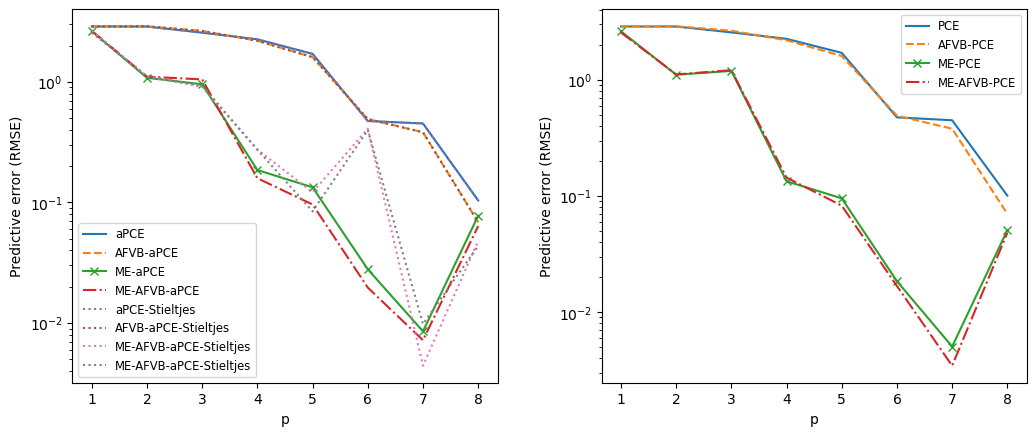

In [36]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Global[1], '--', label = 'AFVB-aPCE')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_ME[1], '-.', label = 'ME-AFVB-aPCE')

ax[0].plot(p, results_Ishigami_AFVB_aPCE_Stieltjes_Global[0], ':', label = 'aPCE-Stieltjes')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Stieltjes_Global[1], ':', label = 'AFVB-aPCE-Stieltjes')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Stieltjes_ME[0], ':' ,label = 'ME-AFVB-aPCE-Stieltjes')
ax[0].plot(p, results_Ishigami_AFVB_aPCE_Stieltjes_ME[1], ':', label = 'ME-AFVB-aPCE-Stieltjes')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Predictive error (RMSE)")
ax[0].legend(fontsize = 'small')

ax[1].plot(p, results_Ishigami_AFVB_PCE_Global[0], '-', label = 'PCE')
ax[1].plot(p, results_Ishigami_AFVB_PCE_Global[1], '--', label = 'AFVB-PCE')
ax[1].plot(p, results_Ishigami_AFVB_PCE_ME[0], '-x', label = 'ME-PCE')
ax[1].plot(p, results_Ishigami_AFVB_PCE_ME[1], '-.', label = 'ME-AFVB-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Predictive error (RMSE)")
ax[1].legend(fontsize = 'small')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_Error.png')

ValueError: x and y must have same first dimension, but have shapes (8,) and (12,)

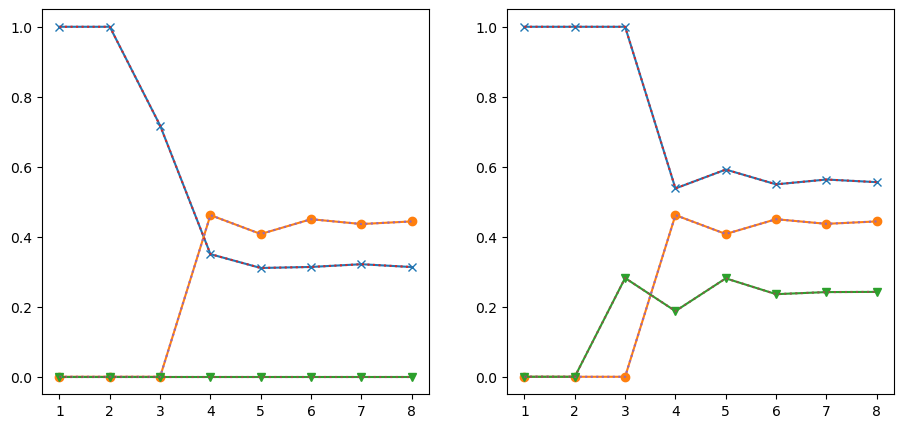

In [30]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)
markers = ['-x','-o','-v']
s = [0.31, 0.44, 0.00]
st = [0.56, 0.44, 0.24]

for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Global[2])[:,i], markers[i], label = f'AFVB-aPCE $S_{i+1}$')  
    ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_Global[3])[:,i], markers[i], label = f'AFVB-aPCE $S_T$$_{i+1}$')
for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[2])[:,i], ':', label = f'AFVB-aPCE-Stieltjes $S_{i+1}$')  
    ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[3])[:,i], ':', label = f'AFVB-aPCE-Stieltjes $S_T$$_{i+1}$')
for i in range(3):
    ax[0].plot(p, [GSA_Ishigami['1st Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_{i+1}=${s[i]}')
    ax[1].plot(p, [GSA_Ishigami['Total Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_T$$_{i+1}=${st[i]}')

ax[0].set_xticks(p)
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend(fontsize = 'x-small', ncol = 3)

ax[1].set_xticks(p)
ax[1].set_xlabel("p")
plt.ylabel("$S_{T_i}$")
ax[1].legend(fontsize = 'x-small', ncol = 3)

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_aPCE_GSA.png')

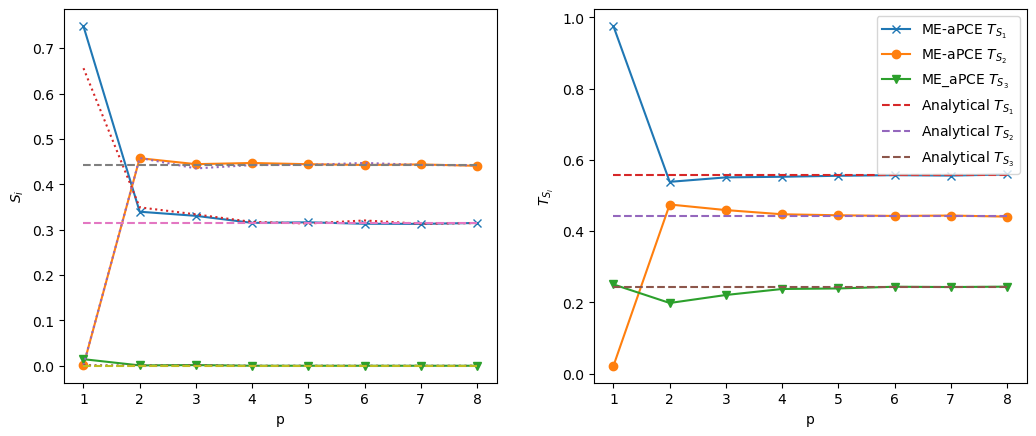

In [34]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)


ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_ME[2])[:,0], '-x', label = 'ME-aPCE $S_1$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_ME[2])[:,1], '-o', label = 'ME-aPCE $S_2$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_ME[2])[:,2], '-v', label = 'ME-aPCE $S_3$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[2])[:,0], ':', label = 'ME-aPCE-Stieltjes $S_1$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[2])[:,1], ':', label = 'ME-aPCE-Stieltjes $S_2$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[2])[:,2], ':', label = 'ME-aPCE-Stieltjes $S_3$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][0]]*12, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][1]]*12, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][2]]*12, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
#ax[0].legend()

ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_ME[3])[:,0], '-x', label = 'ME-aPCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_ME[3])[:,1], '-o', label = 'ME-aPCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_ME[3])[:,2], '-v', label = 'ME_aPCE $T_{S_3}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][0]]*12, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][1]]*12, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][2]]*12, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_aPCE_ME_GSA.png')

ValueError: x and y must have same first dimension, but have shapes (8,) and (12,)

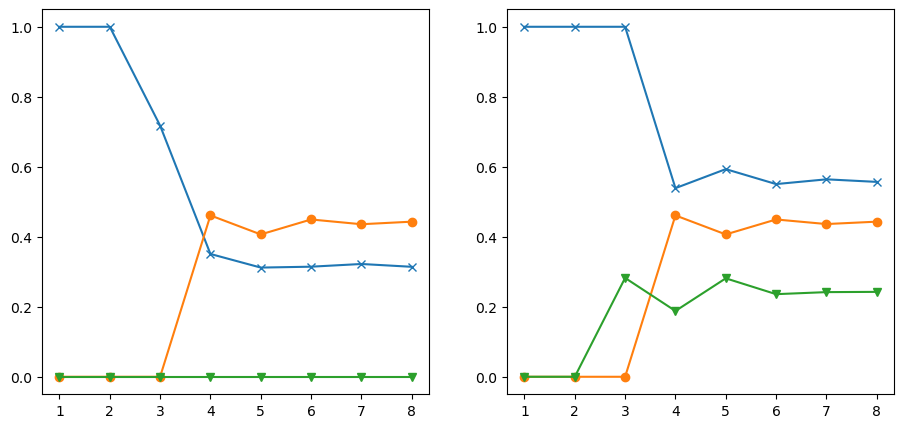

In [35]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)
markers = ['-x','-o','-v']
s = [0.31, 0.44, 0.00]
st = [0.56, 0.44, 0.24]

for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_AFVB_PCE_Global[2])[:,i], markers[i], label = f'AFVB-PCE $S_{i+1}$')
    ax[1].plot(p, np.array(results_Ishigami_AFVB_PCE_Global[3])[:,i], markers[i], label = f'AFVB-PCE $S_T$$_{i+1}$')

for i in range(3):
    ax[0].plot(p, [GSA_Ishigami['1st Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_{i+1}=${s[i]}')
    ax[1].plot(p, [GSA_Ishigami['Total Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_T$$_{i+1}=${st[i]}')

ax[0].set_xticks(p)
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend(fontsize = 'small', ncol = 2)

ax[1].set_xticks(p)
ax[1].set_xlabel("p")
plt.ylabel("$S_{T_i}$")
ax[1].legend(fontsize = 'small', ncol = 2)

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_PCE_GSA.png')

ValueError: x and y must have same first dimension, but have shapes (8,) and (12,)

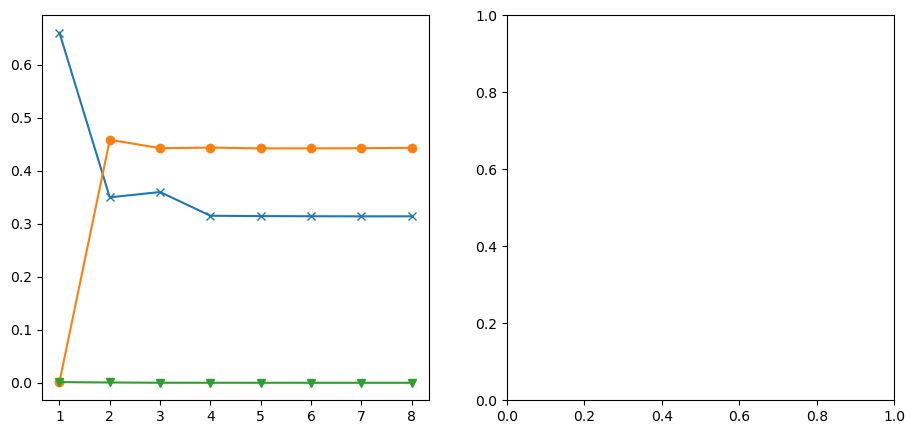

In [33]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)


ax[0].plot(p, np.array(results_Ishigami_AFVB_PCE_ME[2])[:,0], '-x', label = 'ME-PCE $S_1$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_PCE_ME[2])[:,1], '-o', label = 'ME-PCE $S_2$')
ax[0].plot(p, np.array(results_Ishigami_AFVB_PCE_ME[2])[:,2], '-v', label = 'ME-PCE $S_3$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][0]]*12, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][1]]*12, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][2]]*12, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Ishigami_AFVB_PCE_ME[3])[:,0], '-x', label = 'ME-PCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Ishigami_AFVB_PCE_ME[3])[:,1], '-o', label = 'ME-PCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Ishigami_AFVB_PCE_ME[3])[:,2], '-v', label = 'ME_PCE $T_{S_3}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][0]]*12, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][1]]*12, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][2]]*12, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
plt.savefig(wd + '/Ishigami_AFVB_PCE_ME_GSA.png')

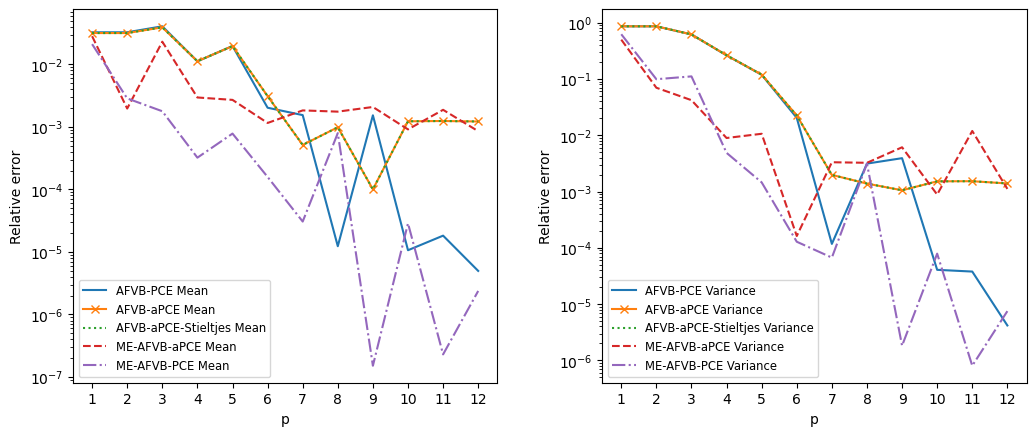

In [614]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[4])-3.5)/3.5, '-', label = 'AFVB-PCE Mean')
ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[4])-3.5)/3.5, '-x', label = 'AFVB-aPCE Mean')
ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[4])-3.5)/3.5, ':', label = 'AFVB-aPCE-Stieltjes Mean')
ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[4])-3.5)/3.5, '--', label = 'ME-AFVB-aPCE Mean')
ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_ME[4])-3.5)/3.5, '-.', label = 'ME-AFVB-PCE Mean')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative error")
ax[0].legend(fontsize = 'small')

ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[5])-V_Ishigami)/V_Ishigami, '-', label = 'AFVB-PCE Variance')
ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[5])-V_Ishigami)/V_Ishigami, '-x', label = 'AFVB-aPCE Variance')
ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', label = 'AFVB-aPCE-Stieltjes Variance')
ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[5])-V_Ishigami)/V_Ishigami, '--', label = 'ME-AFVB-aPCE Variance')
ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_ME[5])-V_Ishigami)/V_Ishigami, '-.', label = 'ME-AFVB-PCE Variance')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Relative error")
ax[1].legend(fontsize = 'small', loc = 'lower left')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_AFVB_aPCE_mean_and_Variance.png')

# VRVM

## Global Models

### aPCE 

In [23]:
# Optimized Hyper-Parameters: slurm-8832059
best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)]), OrderedDict([('omega_a', 5.308734748473324e-06), ('omega_b', 4.463847369430955e-06), ('tau_a', 4.7778328669302936e-06), ('tau_b', 9.341120240169713e-06)]), OrderedDict([('omega_a', 6.679263985681313e-06), ('omega_b', 7.263898333490479e-06), ('tau_a', 8.973357474205131e-06), ('tau_b', 4.5444183292339335e-06)]), OrderedDict([('omega_a', 5.120755602842971e-06), ('omega_b', 5.1091367316367454e-06), ('tau_a', 6.16965153743572e-06), ('tau_b', 4.309996401463503e-06)]), OrderedDict([('omega_a', 5.0473452367984456e-06), ('omega_b', 7.869105385711622e-06), ('tau_a', 5.064934010405011e-06), ('tau_b', 2.008440003109708e-06)]), OrderedDict([('omega_a', 7.716371095471504e-06), ('omega_b', 5.197323799589878e-06), ('tau_a', 8.03968651713205e-06), ('tau_b', 7.267625235629317e-06)]),OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)]), OrderedDict([('omega_a', 5.308734748473324e-06), ('omega_b', 4.463847369430955e-06), ('tau_a', 4.7778328669302936e-06), ('tau_b', 9.341120240169713e-06)]), OrderedDict([('omega_a', 6.679263985681313e-06), ('omega_b', 7.263898333490479e-06), ('tau_a', 8.973357474205131e-06), ('tau_b', 4.5444183292339335e-06)]), OrderedDict([('omega_a', 5.120755602842971e-06), ('omega_b', 5.1091367316367454e-06), ('tau_a', 6.16965153743572e-06), ('tau_b', 4.309996401463503e-06)]),OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)]),OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)])]


In [423]:
results_Ishigami_VRVM_aPCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE', VRVM_PCE, None)

0.04398488998413086
2
0.07909202575683594
2
0.18376874923706055
4
0.3469960689544678
6
0.9898431301116943
9
1.4398720264434814
12
2.203429937362671
14
3.220745086669922
17
4.561563730239868
19
5.718208074569702
32
8.65854811668396
29
11.683112144470215
30


In [ ]:
results_Ishigami_VRVM_aPCE_Global

### aPCE_Stieltjes

In [424]:
best_params_VRVM_Global_aPCE_Stieltjes = [OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)]), OrderedDict([('omega_a', 5.308734748473324e-06), ('omega_b', 4.463847369430955e-06), ('tau_a', 4.7778328669302936e-06), ('tau_b', 9.341120240169713e-06)]), OrderedDict([('omega_a', 6.679263985681313e-06), ('omega_b', 7.263898333490479e-06), ('tau_a', 8.973357474205131e-06), ('tau_b', 4.5444183292339335e-06)]), OrderedDict([('omega_a', 5.120755602842971e-06), ('omega_b', 5.1091367316367454e-06), ('tau_a', 6.16965153743572e-06), ('tau_b', 4.309996401463503e-06)]), OrderedDict([('omega_a', 5.0473452367984456e-06), ('omega_b', 7.869105385711622e-06), ('tau_a', 5.064934010405011e-06), ('tau_b', 2.008440003109708e-06)]), OrderedDict([('omega_a', 7.716371095471504e-06), ('omega_b', 5.197323799589878e-06), ('tau_a', 8.03968651713205e-06), ('tau_b', 7.267625235629317e-06)]),OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)]), OrderedDict([('omega_a', 5.308734748473324e-06), ('omega_b', 4.463847369430955e-06), ('tau_a', 4.7778328669302936e-06), ('tau_b', 9.341120240169713e-06)]), OrderedDict([('omega_a', 6.679263985681313e-06), ('omega_b', 7.263898333490479e-06), ('tau_a', 8.973357474205131e-06), ('tau_b', 4.5444183292339335e-06)]), OrderedDict([('omega_a', 5.120755602842971e-06), ('omega_b', 5.1091367316367454e-06), ('tau_a', 6.16965153743572e-06), ('tau_b', 4.309996401463503e-06)]),OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)]),OrderedDict([('omega_a', 6.858515554794972e-06), ('omega_b', 7.88952035641568e-06), ('tau_a', 4.191427833439507e-06), ('tau_b', 8.857417323950574e-06)])]


In [425]:
results_Ishigami_VRVM_aPCE_Stieltjes_Global = collect_results_PCE(p, d, tf.ishigami, best_params_VRVM_Global_aPCE_Stieltjes, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', VRVM_PCE, None)

0.05761098861694336
2
0.10393500328063965
2
0.17550301551818848
4
0.3303217887878418
6
0.7812988758087158
9
1.3728578090667725
12
2.110651969909668
14
3.116560697555542
17
4.478593111038208
19
5.669757843017578
32
8.507710933685303
29
11.752158880233765
30


### PCE

In [426]:
# Optimized Hyper-Parameters: slurm-8832060
best_params_VRVM_Global_PCE = [OrderedDict([('omega_a', 1.7572543184597318e-06), ('omega_b', 2.1035780168441365e-06), ('tau_a', 3.727712068357358e-06), ('tau_b', 4.111819714573417e-06)]), OrderedDict([('omega_a', 8.702627181265887e-06), ('omega_b', 5.993231799284474e-06), ('tau_a', 5.839749153327399e-06), ('tau_b', 2.51622277944413e-06)]), OrderedDict([('omega_a', 4.382398874094782e-06), ('omega_b', 5.9286640039570046e-06), ('tau_a', 2.3628010972917738e-06), ('tau_b', 7.64243250358719e-06)]), OrderedDict([('omega_a', 4.442344425724314e-06), ('omega_b', 8.9447374575322e-06), ('tau_a', 1.1393674709382237e-06), ('tau_b', 4.328725266340756e-06)]), OrderedDict([('omega_a', 5.3298082395837015e-06), ('omega_b', 9.475076319856312e-06), ('tau_a', 4.280547977372447e-06), ('tau_b', 8.237096471244671e-06)]), OrderedDict([('omega_a', 9.870093690131959e-06), ('omega_b', 6.6269445106109055e-06), ('tau_a', 1.6146230702728268e-06), ('tau_b', 7.5494520830575155e-06)]),OrderedDict([('omega_a', 1.7572543184597318e-06), ('omega_b', 2.1035780168441365e-06), ('tau_a', 3.727712068357358e-06), ('tau_b', 4.111819714573417e-06)]), OrderedDict([('omega_a', 8.702627181265887e-06), ('omega_b', 5.993231799284474e-06), ('tau_a', 5.839749153327399e-06), ('tau_b', 2.51622277944413e-06)]), OrderedDict([('omega_a', 4.382398874094782e-06), ('omega_b', 5.9286640039570046e-06), ('tau_a', 2.3628010972917738e-06), ('tau_b', 7.64243250358719e-06)]), OrderedDict([('omega_a', 4.442344425724314e-06), ('omega_b', 8.9447374575322e-06), ('tau_a', 1.1393674709382237e-06), ('tau_b', 4.328725266340756e-06)]),OrderedDict([('omega_a', 1.7572543184597318e-06), ('omega_b', 2.1035780168441365e-06), ('tau_a', 3.727712068357358e-06), ('tau_b', 4.111819714573417e-06)]),OrderedDict([('omega_a', 1.7572543184597318e-06), ('omega_b', 2.1035780168441365e-06), ('tau_a', 3.727712068357358e-06), ('tau_b', 4.111819714573417e-06)])]

B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]

In [427]:
results_Ishigami_VRVM_PCE_Global = collect_results_PCE(p, d, tf.ishigami, best_params_VRVM_Global_PCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Legendre', VRVM_PCE, B_init)


0.11352109909057617
2
0.22922205924987793
2
0.40131282806396484
4
0.683711051940918
8
1.5249671936035156
9
2.3852479457855225
12
3.3056142330169678
14
4.60990834236145
18
6.276680946350098
18
8.236984014511108
25
16.532439947128296
24
14.108794212341309
20


## Local Models

### aPCE 

In [61]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])


In [94]:
# Optimized Hyper-Parameters: slurm-8832064
best_params_VRVM_ME_aPCE = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), OrderedDict([('alpha', 0.035936313473569695), ('arg1', 1e-08), ('arg2', 2.655146354315031e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.8459693119306863), ('theta2', 0.04928222881285478)]), OrderedDict([('alpha', 1e-06), ('arg1', 6.842778231943695e-06), ('arg2', 7.781776387101613e-05), ('arg3', 2.022494965579457e-05), ('arg4', 6.911547620607852e-05), ('theta1', 0.8908168405773248), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.1565896386478665), ('arg1', 3.6691669112488755e-05), ('arg2', 3.666862211983487e-05), ('arg3', 5.722070880687537e-05), ('arg4', 6.831456628904052e-05), ('theta1', 0.42683953588204293), ('theta2', 0.08783128546219385)]), OrderedDict([('alpha', 0.5984529977308706), ('arg1', 3.6297762726049333e-05), ('arg2', 1.8814666390312428e-05), ('arg3', 7.202381543212009e-05), ('arg4', 2.303265940477397e-05), ('theta1', 0.9721868447583709), ('theta2', 0.7238330823343102)]), OrderedDict([('alpha', 0.17802959776874175), ('arg1', 5.855314779894947e-05), ('arg2', 2.496342435264212e-05), ('arg3', 4.89810809593937e-05), ('arg4', 8.666174664280051e-05), ('theta1', 0.5217987441992685), ('theta2', 0.7547399615484185)]), OrderedDict([('alpha', 0.5918806969293593), ('arg1', 1e-08), ('arg2', 3.3242655831437976e-05), ('arg3', 2.060187672010659e-05), ('arg4', 1e-08), ('theta1', 0.40442717574986653), ('theta2', 0.99)]), OrderedDict([('alpha', 0.25310562992270563), ('arg1', 3.915041494086702e-06), ('arg2', 4.317704582651805e-06), ('arg3', 8.324783135039999e-05), ('arg4', 3.532265925491864e-05), ('theta1', 0.19715023375961194), ('theta2', 0.5468975944050383)]), 
                            OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 1e-08), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.99), ('theta2', 0.99)]), 
                            OrderedDict([('alpha', 0.6482056324001543), ('arg1', 1e-08), ('arg2', 8.274670219152423e-05), ('arg3', 4.919889671614638e-05), ('arg4', 0.0001), ('theta1', 0.4867735801550905), ('theta2', 0.49294063313494696)]),
                           OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 1e-08), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.99), ('theta2', 0.99)]), 
                            OrderedDict([('alpha', 0.6482056324001543), ('arg1', 1e-08), ('arg2', 8.274670219152423e-05), ('arg3', 4.919889671614638e-05), ('arg4', 0.0001), ('theta1', 0.4867735801550905), ('theta2', 0.49294063313494696)])]


In [24]:
results_Ishigami_VRVM_aPCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_VRVM_Global_aPCE, 
                                                  X_test, 'aPCE', 
                                                  VRVM_PCE, data_ishigami, N_t = 200, N_p = 100000, 
                                                  B_init = B_init, n_iter = 1)

2
3.557176659240732
3.5571766592407315 3.1813209525933734
0   NaN
1   NaN
2   NaN
Name: Total Order, dtype: float64


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
 

8
12.905780405337604
12.905780405337602 3.5982791283095605
0    12.967845
1    13.237753
2    13.075012
Name: Total Order, dtype: float64
2
7.039763832680277
7.0397638326802765 3.1869513163053544
0    8.704261e+00
1   -1.776357e-15
2    7.879008e-01
Name: Total Order, dtype: float64
2
11.967498103215842
11.967498103215842 3.325310129857206
0     0.522468
1    11.754666
2     0.176109
Name: Total Order, dtype: float64
8
13.840736191435028
13.840736191435028 3.5194297311531546
0    13.184746
1    13.410427
2    13.276463
Name: Total Order, dtype: float64
2
13.71318355128997
13.713183551289967 3.4688073265607944
0     0.561115
1    13.092103
2     0.245082
Name: Total Order, dtype: float64
8
13.835380790731907
13.835380790731907 3.5145593949622285
0    13.164443
1    13.390787
2    13.256896
Name: Total Order, dtype: float64
2
13.839730743434604
13.839730743434604 3.505159260820829
0     0.556981
1    13.284437
2     0.242860
Name: Total Order, dtype: float64
8
13.833523357133231
13.83352

### aPCE_Stieltjes

In [113]:
best_params_VRVM_ME_aPCE_Stieltjes = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), OrderedDict([('alpha', 0.035936313473569695), ('arg1', 1e-08), ('arg2', 2.655146354315031e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.8459693119306863), ('theta2', 0.04928222881285478)]), OrderedDict([('alpha', 1e-06), ('arg1', 6.842778231943695e-06), ('arg2', 7.781776387101613e-05), ('arg3', 2.022494965579457e-05), ('arg4', 6.911547620607852e-05), ('theta1', 0.8908168405773248), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.1565896386478665), ('arg1', 3.6691669112488755e-05), ('arg2', 3.666862211983487e-05), ('arg3', 5.722070880687537e-05), ('arg4', 6.831456628904052e-05), ('theta1', 0.42683953588204293), ('theta2', 0.08783128546219385)]), OrderedDict([('alpha', 0.5984529977308706), ('arg1', 3.6297762726049333e-05), ('arg2', 1.8814666390312428e-05), ('arg3', 7.202381543212009e-05), ('arg4', 2.303265940477397e-05), ('theta1', 0.9721868447583709), ('theta2', 0.7238330823343102)]), OrderedDict([('alpha', 0.17802959776874175), ('arg1', 5.855314779894947e-05), ('arg2', 2.496342435264212e-05), ('arg3', 4.89810809593937e-05), ('arg4', 8.666174664280051e-05), ('theta1', 0.5217987441992685), ('theta2', 0.7547399615484185)]), OrderedDict([('alpha', 0.5918806969293593), ('arg1', 1e-08), ('arg2', 3.3242655831437976e-05), ('arg3', 2.060187672010659e-05), ('arg4', 1e-08), ('theta1', 0.40442717574986653), ('theta2', 0.99)]), OrderedDict([('alpha', 0.25310562992270563), ('arg1', 3.915041494086702e-06), ('arg2', 4.317704582651805e-06), ('arg3', 8.324783135039999e-05), ('arg4', 3.532265925491864e-05), ('theta1', 0.19715023375961194), ('theta2', 0.5468975944050383)]), 
                            OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 1e-08), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.99), ('theta2', 0.99)]), 
                            OrderedDict([('alpha', 0.6482056324001543), ('arg1', 1e-08), ('arg2', 8.274670219152423e-05), ('arg3', 4.919889671614638e-05), ('arg4', 0.0001), ('theta1', 0.4867735801550905), ('theta2', 0.49294063313494696)]),
                           OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 1e-08), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.99), ('theta2', 0.99)]), 
                            OrderedDict([('alpha', 0.6482056324001543), ('arg1', 1e-08), ('arg2', 8.274670219152423e-05), ('arg3', 4.919889671614638e-05), ('arg4', 0.0001), ('theta1', 0.4867735801550905), ('theta2', 0.49294063313494696)])]

In [69]:
results_Ishigami_VRVM_aPCE_Stieltjes_ME = collect_results_ME(p, d, tf.ishigami, best_params_VRVM_Global_aPCE_Stieltjes, 
                                                  X_test, 'aPCE_Stieltjes', 
                                                  VRVM_PCE, data_ishigami, N_t = 200, N_p = 100000, 
                                                  B_init = B_init, n_iter = 1)

0.11593890190124512
2
3.556804002242317
0    0.0
1    0.0
2    0.0
Name: Partial Variance, dtype: float64
3.5568040022423197 3.1813523896286386


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
 

0.8472762107849121
8
12.90452273346483
0    0.096427
1    0.726556
2    0.346198
Name: Partial Variance, dtype: float64
12.90452273346484 3.5983103315694387
0.8502368927001953
2
7.038541101307275
0    0.376251
1    0.000000
2    1.288492
Name: Partial Variance, dtype: float64
7.038541101307278 3.1869813931369255
1.8068010807037354
2
11.966632453891352
0    2.072293
1    2.857380
2    0.000000
Name: Partial Variance, dtype: float64
11.966632453891357 3.325386372530425
12.373143672943115
8
13.83925688758179
0    0.103861
1    0.766522
2    0.340684
Name: Partial Variance, dtype: float64
13.83925688758179 3.5194725671927296
6.598572015762329
2
13.711629687366791
0    2.176062
1    2.998039
2    0.005040
Name: Partial Variance, dtype: float64
13.711629687366798 3.468858679713969
22.087507963180542
8
13.834198151419557
0    0.102616
1    0.765876
2    0.341010
Name: Partial Variance, dtype: float64
13.834198151419564 3.5144852587902218
17.97817587852478
4
13.810424572906268
0    0.204743
1 

### PCE

In [96]:
# Optimized Hyper-Parameters: slurm-8832062
best_params_VRVM_ME_PCE = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), 
                           OrderedDict([('alpha', 0.5289437986914474), ('arg1', 1e-08), ('arg2', 0.0001), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.99), ('theta2', 0.6854114075800615)]), 
                           OrderedDict([('alpha', 0.99), ('arg1', 1e-08), ('arg2', 1.4867705384443327e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.4309897861424597), ('theta2', 1e-06)]), 
                           OrderedDict([('alpha', 0.13149842388851093), ('arg1', 2.858617221177075e-05), ('arg2', 1.9819140489252086e-05), ('arg3', 9.769346103224226e-05), ('arg4', 8.963112432413811e-05), ('theta1', 0.41901501810660696), ('theta2', 0.43084482438144067)]), 
                           OrderedDict([('alpha', 1e-06), ('arg1', 7.289738264009899e-05), ('arg2', 0.0001), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.8579155099950342), ('theta2', 0.839801088286929)]), 
                           OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 2.6629814791561958e-05), ('arg3', 3.950895687160405e-05), ('arg4', 0.0001), ('theta1', 0.9659821744393433), ('theta2', 0.99)]), 
                           OrderedDict([('alpha', 0.23536533983669095), ('arg1', 1e-08), ('arg2', 4.3401574409528914e-05), ('arg3', 5.732709462579834e-07), ('arg4', 2.0164777873082108e-05), ('theta1', 0.583055632347364), ('theta2', 0.7640704380072287)]), 
                           OrderedDict([('alpha', 1e-06), ('arg1', 8.705489426977751e-07), ('arg2', 1.6797466983276716e-05), ('arg3', 1e-08), ('arg4', 5.5616270847537436e-05), ('theta1', 0.5569867953480909), ('theta2', 0.4303116952740246)]), 
                           OrderedDict([('alpha', 0.8155245997271127), ('arg1', 5.282755343067723e-05), ('arg2', 4.5899236653516115e-06), ('arg3', 1.4351811332222484e-06), ('arg4', 3.585608446971019e-05), ('theta1', 0.19913907035441367), ('theta2', 0.7850467522022636)]), 
                           OrderedDict([('alpha', 0.336504742387436), ('arg1', 9.333871305245319e-05), ('arg2', 8.546855404608885e-05), ('arg3', 5.066332825398189e-05), ('arg4', 7.209845076479927e-05), ('theta1', 0.4720998283860188), ('theta2', 0.8783985766775352)]),
                          OrderedDict([('alpha', 0.8155245997271127), ('arg1', 5.282755343067723e-05), ('arg2', 4.5899236653516115e-06), ('arg3', 1.4351811332222484e-06), ('arg4', 3.585608446971019e-05), ('theta1', 0.19913907035441367), ('theta2', 0.7850467522022636)]), 
                           OrderedDict([('alpha', 0.336504742387436), ('arg1', 9.333871305245319e-05), ('arg2', 8.546855404608885e-05), ('arg3', 5.066332825398189e-05), ('arg4', 7.209845076479927e-05), ('theta1', 0.4720998283860188), ('theta2', 0.8783985766775352)])]

B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]

In [70]:
results_Ishigami_VRVM_PCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_VRVM_Global_PCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  VRVM_PCE, data_ishigami, N_t = 200, N_p = None, 
                                                  B_init = B_init, n_iter = 1)

0.25820398330688477
2
3.556803742150436
0    0.0
1    0.0
2    0.0
Name: Partial Variance, dtype: float64
3.5568037421504366 3.1813523653168203


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:166: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/sensitivity_analysis.py:172: RuntimeWarning: invalid value encountered in scalar divide
 

1.8111231327056885
8
12.907642163166772
0    0.096578
1    0.726361
2    0.346603
Name: Partial Variance, dtype: float64
12.907642163166779 3.5857495302690516
1.1847119331359863
2
7.049829805481751
0    0.376730
1    0.000000
2    1.293268
Name: Partial Variance, dtype: float64
7.049829805481754 3.1870113404474147
2.0859580039978027
2
11.973550705566554
0    2.071435
1    2.858672
2    0.000000
Name: Partial Variance, dtype: float64
11.97355070556656 3.3212846207189664
15.194060802459717
8
13.855458279847008
0    0.104138
1    0.766912
2    0.341555
Name: Partial Variance, dtype: float64
13.855458279847012 3.5043009969831234
7.955440044403076
2
13.729262414683753
0    2.178854
1    2.999525
2    0.004916
Name: Partial Variance, dtype: float64
13.729262414683756 3.464662427537829
23.872771978378296
8
13.845583521915536
0    0.102767
1    0.765900
2    0.341792
Name: Partial Variance, dtype: float64
13.845583521915541 3.499748404706981
22.146112203598022
4
13.842809289023807
0    0.20561

## Plots for VRVM - Ishigami Function

NameError: name 'results_Ishigami_VRVM_aPCE_Global' is not defined

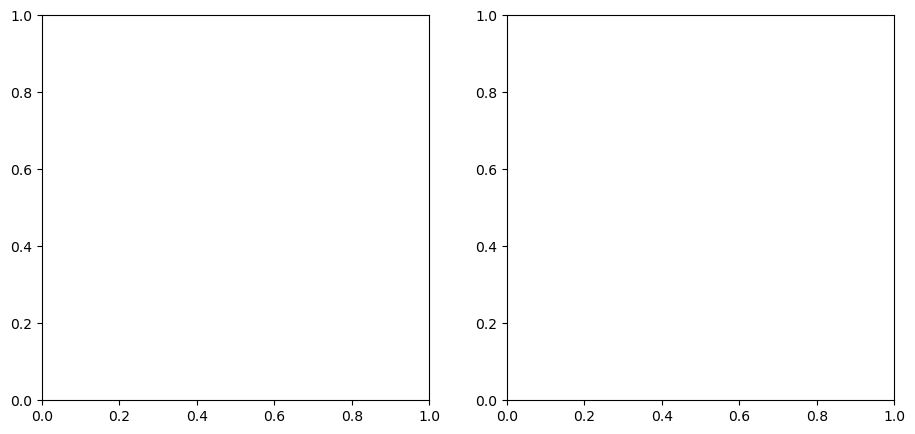

In [25]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Ishigami_VRVM_aPCE_Global[0], '-', label = 'aPCE')
ax[0].plot(p, results_Ishigami_VRVM_aPCE_Global[1], '--', label = 'VRVM-aPCE')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_ME[0], '-x', label = 'ME-aPCE')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_ME[1], '-.', label = 'ME-VRVM-aPCE')

ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_Global[0], ':', label = 'aPCE-Stieltjes')
ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_Global[1], ':', label = 'VRVM-aPCE-Stieltjes')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_ME[0], ':' ,label = 'ME-VRVM-aPCE-Stieltjes')
#ax[0].plot(p, results_Ishigami_VRVM_aPCE_Stieltjes_ME[1], ':', label = 'ME-VRVM-aPCE-Stieltjes')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Predictive error (RMSE)")
ax[0].legend(fontsize = 'small')

ax[1].plot(p, results_Ishigami_VRVM_PCE_Global[0], '-', label = 'PCE')
ax[1].plot(p, results_Ishigami_VRVM_PCE_Global[1], '--', label = 'VRVM-PCE')
#ax[1].plot(p, results_Ishigami_VRVM_PCE_ME[0], '-x', label = 'ME-PCE')
#ax[1].plot(p, results_Ishigami_VRVM_PCE_ME[1], '-.', label = 'ME-VRVM-PCE')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Predictive error (RMSE)")
ax[1].legend(fontsize = 'small')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_VRVM_Error.png')

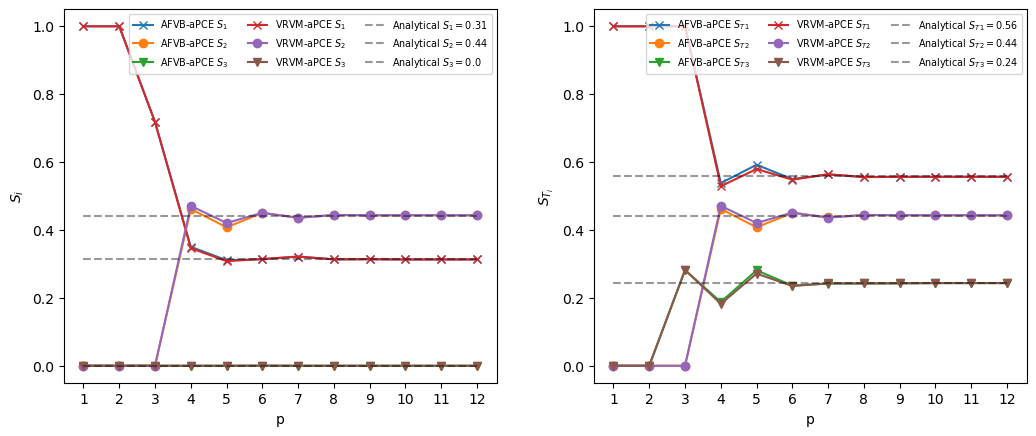

In [430]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)
markers = ['-x','-o','-v']
markers2 = ['-x','-o','-v']
s = [0.31, 0.44, 0.00]
st = [0.56, 0.44, 0.24]

for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Global[2])[:,i], markers[i], label = f'AFVB-aPCE $S_{i+1}$')  
    ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_Global[3])[:,i], markers[i], label = f'AFVB-aPCE $S_T$$_{i+1}$')
#for i in range(3):
#    ax[0].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[2])[:,i], ':', label = f'AFVB-aPCE-Stieltjes $S_{i+1}$')  
#    ax[1].plot(p, np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[3])[:,i], ':', label = f'AFVB-aPCE-Stieltjes $S_T$$_{i+1}$')
for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_VRVM_aPCE_Global[2])[:,i], markers2[i], label = f'VRVM-aPCE $S_{i+1}$')  
    ax[1].plot(p, np.array(results_Ishigami_VRVM_aPCE_Global[3])[:,i], markers2[i], label = f'VRVM-aPCE $S_T$$_{i+1}$')
#for i in range(3):
#    ax[0].plot(p, np.array(results_Ishigami_VRVM_aPCE_Stieltjes_Global[2])[:,i], ':', label = f'VRVM-aPCE-Stieltjes $S_{i+1}$')  
#    ax[1].plot(p, np.array(results_Ishigami_VRVM_aPCE_Stieltjes_Global[3])[:,i], ':', label = f'VRVM-aPCE-Stieltjes $S_T$$_{i+1}$')   
for i in range(3):
    ax[0].plot(p, [GSA_Ishigami['1st Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_{i+1}=${s[i]}')
    ax[1].plot(p, [GSA_Ishigami['Total Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_T$$_{i+1}=${st[i]}')

ax[0].set_xticks(p)
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend(fontsize = 'x-small', ncol = 3)

ax[1].set_xticks(p)
ax[1].set_xlabel("p")
plt.ylabel("$S_{T_i}$")
ax[1].legend(fontsize = 'x-small', ncol = 3)

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_aPCE_GSA.png')

NameError: name 'results_Ishigami_VRVM_aPCE_ME' is not defined

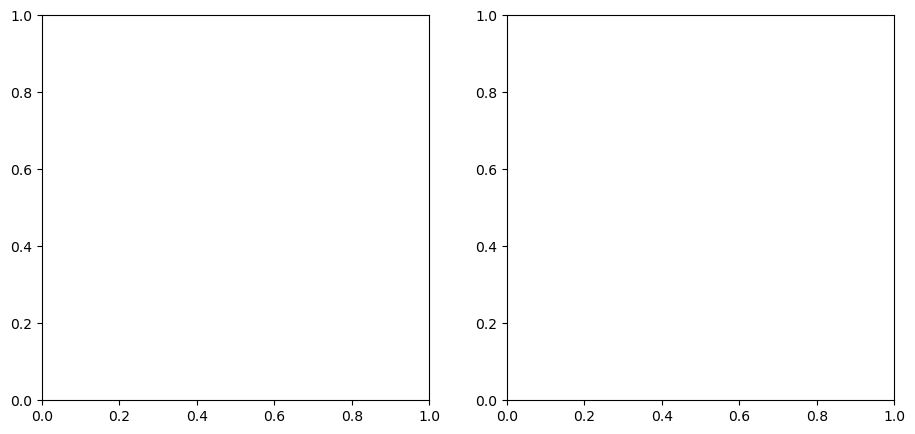

In [184]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)


ax[0].plot(p, np.array(results_Ishigami_VRVM_aPCE_ME[2])[:,0], '-x', label = 'ME-aPCE $S_1$')
ax[0].plot(p, np.array(results_Ishigami_VRVM_aPCE_ME[2])[:,1], '-o', label = 'ME-aPCE $S_2$')
ax[0].plot(p, np.array(results_Ishigami_VRVM_aPCE_ME[2])[:,2], '-v', label = 'ME-aPCE $S_3$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][0]]*12, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][1]]*12, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][2]]*12, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Ishigami_VRVM_aPCE_ME[3])[:,0], '-x', label = 'ME-aPCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Ishigami_VRVM_aPCE_ME[3])[:,1], '-o', label = 'ME-aPCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Ishigami_VRVM_aPCE_ME[3])[:,2], '-v', label = 'ME_aPCE $T_{S_3}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][0]]*12, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][1]]*12, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][2]]*12, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Ishigami_VRVM_aPCE_ME_GSA.png')

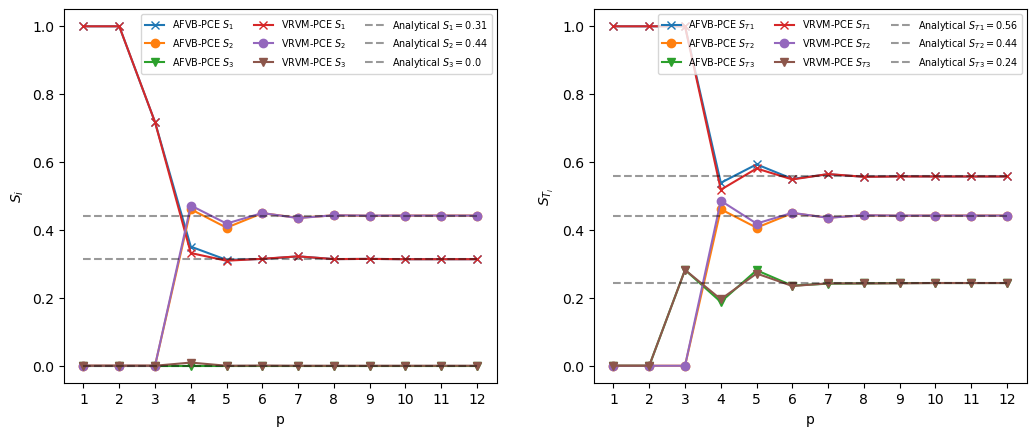

In [431]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)
markers = ['-x','-o','-v']
markers2 = ['-x','-o','-v']
s = [0.31, 0.44, 0.00]
st = [0.56, 0.44, 0.24]

for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_AFVB_PCE_Global[2])[:,i], markers[i], label = f'AFVB-PCE $S_{i+1}$')  
    ax[1].plot(p, np.array(results_Ishigami_AFVB_PCE_Global[3])[:,i], markers[i], label = f'AFVB-PCE $S_T$$_{i+1}$')
#for i in range(3):
#    ax[0].plot(p, np.array(results_Ishigami_AFVB_PCE_Stieltjes_Global[2])[:,i], ':', label = f'AFVB-PCE-Stieltjes $S_{i+1}$')  
#    ax[1].plot(p, np.array(results_Ishigami_AFVB_PCE_Stieltjes_Global[3])[:,i], ':', label = f'AFVB-PCE-Stieltjes $S_T$$_{i+1}$')
for i in range(3):
    ax[0].plot(p, np.array(results_Ishigami_VRVM_PCE_Global[2])[:,i], markers2[i], label = f'VRVM-PCE $S_{i+1}$')  
    ax[1].plot(p, np.array(results_Ishigami_VRVM_PCE_Global[3])[:,i], markers2[i], label = f'VRVM-PCE $S_T$$_{i+1}$')
#for i in range(3):
#    ax[0].plot(p, np.array(results_Ishigami_VRVM_PCE_Stieltjes_Global[2])[:,i], ':', label = f'VRVM-PCE-Stieltjes $S_{i+1}$')  
#    ax[1].plot(p, np.array(results_Ishigami_VRVM_PCE_Stieltjes_Global[3])[:,i], ':', label = f'VRVM-PCE-Stieltjes $S_T$$_{i+1}$')   
for i in range(3):
    ax[0].plot(p, [GSA_Ishigami['1st Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_{i+1}=${s[i]}')
    ax[1].plot(p, [GSA_Ishigami['Total Order'][i]]*12, '--', c = 'black', alpha = 0.4, label = f'Analytical $S_T$$_{i+1}=${st[i]}')

ax[0].set_xticks(p)
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend(fontsize = 'x-small', ncol = 3)

ax[1].set_xticks(p)
ax[1].set_xlabel("p")
plt.ylabel("$S_{T_i}$")
ax[1].legend(fontsize = 'x-small', ncol = 3)

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_PCE_GSA.png')

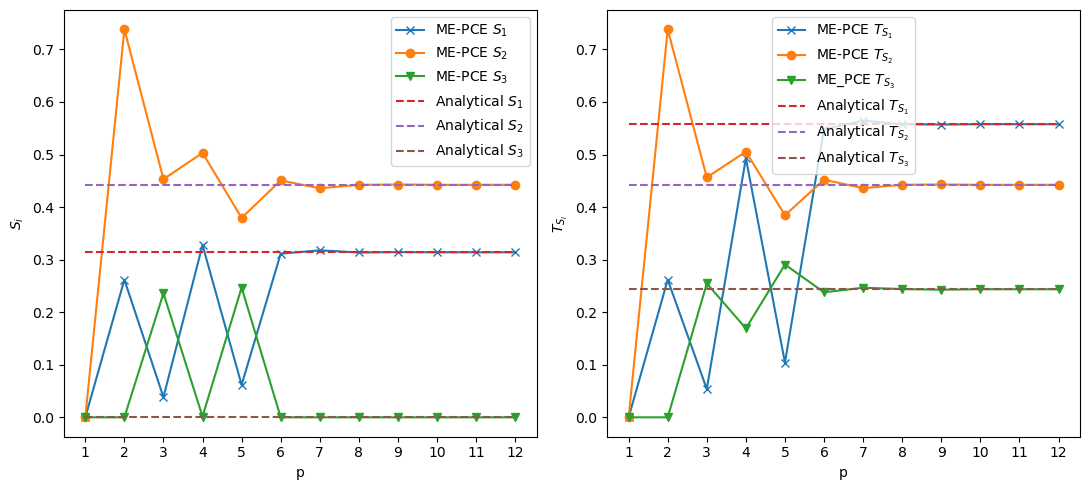

In [110]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)


ax[0].plot(p, np.array(results_Ishigami_VRVM_PCE_ME[2])[:,0], '-x', label = 'ME-PCE $S_1$')
ax[0].plot(p, np.array(results_Ishigami_VRVM_PCE_ME[2])[:,1], '-o', label = 'ME-PCE $S_2$')
ax[0].plot(p, np.array(results_Ishigami_VRVM_PCE_ME[2])[:,2], '-v', label = 'ME-PCE $S_3$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][0]]*12, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][1]]*12, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Ishigami['1st Order'][2]]*12, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Ishigami_VRVM_PCE_ME[3])[:,0], '-x', label = 'ME-PCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Ishigami_VRVM_PCE_ME[3])[:,1], '-o', label = 'ME-PCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Ishigami_VRVM_PCE_ME[3])[:,2], '-v', label = 'ME_PCE $T_{S_3}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][0]]*12, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][1]]*12, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Ishigami['Total Order'][2]]*12, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Ishigami_VRVM_PCE_ME_GSA.png')

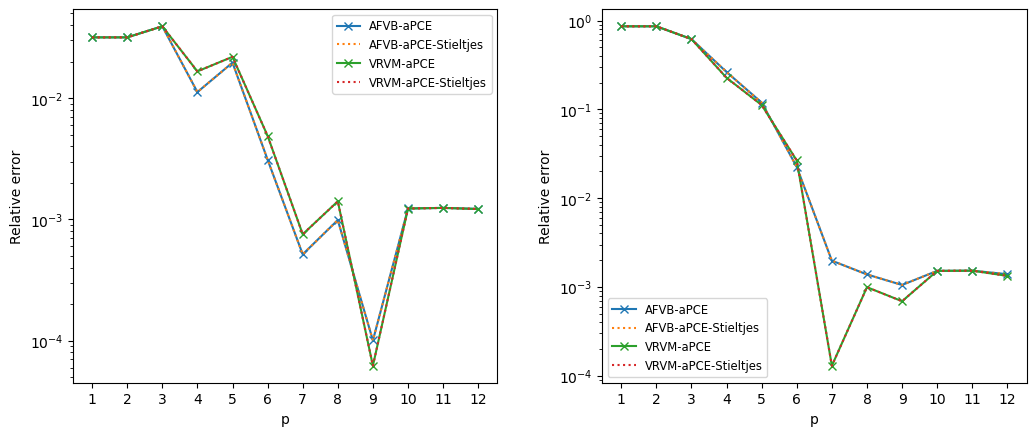

In [433]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[4])-3.5)/3.5, '-x', label = 'AFVB-aPCE')
ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[4])-3.5)/3.5, ':', label = 'AFVB-aPCE-Stieltjes')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[4])-3.5)/3.5, '--', label = 'ME-AFVB-aPCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_ME[4])-3.5)/3.5, '--', label = 'ME-AFVB-aPCE-Stieltjes')

ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[4])-3.5)/3.5, '-x', label = 'VRVM-aPCE')
ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Stieltjes_Global[4])-3.5)/3.5, ':', label = 'VRVM-aPCE-Stieltjes')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_ME[4])-3.5)/3.5, '--', label = 'ME-VRVM-aPCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Stieltjes_ME[4])-3.5)/3.5, '--', label = 'ME-VRVM-aPCE-Stieltjes')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative error")
ax[0].legend(fontsize = 'small')


ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Global[5])-V_Ishigami)/V_Ishigami, '-x', label = 'AFVB-aPCE')
ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', label = 'AFVB-aPCE-Stieltjes')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_aPCE_ME[5])-V_Ishigami)/V_Ishigami, '--', label = 'ME-AFVB-aPCE')

ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[5])-V_Ishigami)/V_Ishigami, '-x', label = 'VRVM-aPCE')
ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', label = 'VRVM-aPCE-Stieltjes')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_ME[5])-V_Ishigami)/V_Ishigami, '--', label = 'ME-VRVM-aPCE')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Relative error")
ax[1].legend(fontsize = 'small', loc = 'lower left')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_aPCE_mean_and_variance.png')

In [176]:
results_Ishigami_VRVM_PCE_Global[4]

[]

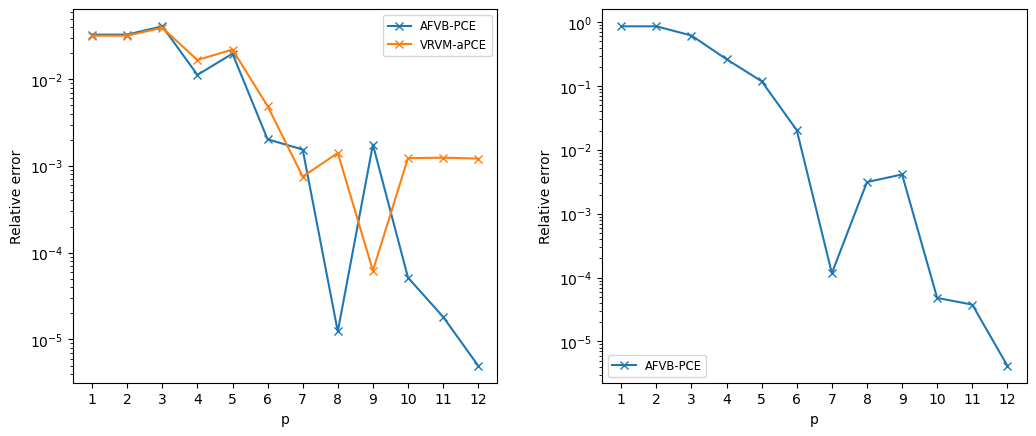

In [434]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[4])-3.5)/3.5, '-x', label = 'AFVB-PCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Stieltjes_Global[4])-3.5)/3.5, ':', label = 'AFVB-PCE-Stieltjes')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_ME[4])-3.5)/3.5, '--', label = 'ME-AFVB-PCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Stieltjes_ME[4])-3.5)/3.5, '--', label = 'ME-AFVB-PCE-Stieltjes')

ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_aPCE_Global[4])-3.5)/3.5, '-x', label = 'VRVM-aPCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Stieltjes_Global[4])-3.5)/3.5, ':', label = 'VRVM-PCE-Stieltjes')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_ME[4])-3.5)/3.5, '--', label = 'ME-VRVM-PCE')
#ax[0].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Stieltjes_ME[4])-3.5)/3.5, '--', label = 'ME-VRVM-PCE-Stieltjes')

ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative error")
ax[0].legend(fontsize = 'small')


ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Global[5])-V_Ishigami)/V_Ishigami, '-x', label = 'AFVB-PCE')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', label = 'AFVB-PCE-Stieltjes')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_ME[5])-V_Ishigami)/V_Ishigami, '--', label = 'ME-AFVB-PCE')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_AFVB_PCE_Stieltjes_ME[5])-V_Ishigami)/V_Ishigami, '-.', label = 'ME-AFVB-PCE-Stieltjes')

#ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Global[5])-V_Ishigami)/V_Ishigami, '-x', label = 'VRVM-PCE')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Stieltjes_Global[5])-V_Ishigami)/V_Ishigami, ':', label = 'VRVM-PCE-Stieltjes')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_ME[5])-V_Ishigami)/V_Ishigami, '--', label = 'ME-VRVM-PCE')
#ax[1].plot(p, np.abs(np.array(results_Ishigami_VRVM_PCE_Stieltjes_ME[5])-V_Ishigami)/V_Ishigami, '-.', label = 'ME-VRVM-PCE-Stieltjes')

ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Relative error")
ax[1].legend(fontsize = 'small', loc = 'lower left')

fig.tight_layout(pad = 3.0);
plt.savefig(wd + '/Ishigami_PCE_mean_and_variance.png')

# Example 2: Cantilever Tube Structure

Note: Need to modify ME_PCE algorithm to allow values from non-uniform distribution and change it so that the aPCE algorithms are entering ifnormation from data not from knowledge of pdf!!!!!!!

In [578]:
N_train = 200 # Sample size
N_test = 50
N_pol = 100000
N_mc = 1000000 #10^6 samples

d = 7

In [579]:
np.random.seed(2357)

X_train = tf.cantilever_data(N_train)
X_pol = tf.cantilever_data(N_pol)

Y_train = tf.cantilever(X_train)

X_test = tf.cantilever_data(N_test)
X_mc = tf.cantilever_data(N_mc)
Y_test = tf.cantilever(X_test)

X_train_uniform = np.random.uniform(-1,1,(N_train,d))
X_test_uniform = np.random.uniform(-1,1,(N_test,d))

In [580]:
uniform_models = []

for i in range(d):
    temp_model = PCE_Full_Model('PCE_Legendre', d=1, p=6, domain=[[-1,1]], aPCE_model = None, P = None)
    temp_model.fit(np.c_[X_train_uniform[:,i]], np.c_[X_train[:,i]])
    uniform_models.append(temp_model)


def Y_uniform(X):
    d = X.shape[1]
    N = X.shape[0]
    X_uniform = np.zeros((N,d))
    for i in range(d):
        X_uniform[:,i] = uniform_models[i].predict(np.c_[X[:,i]]).reshape(N)
    
    return tf.cantilever(X_uniform)

In [581]:
def normal_pdf(x, mu, sigma):
    return multivariate_normal.pdf

def v_i(mu, cov, B):
    result = scipy.stats.norm.cdf(B[1], mu, cov) - scipy.stats.norm.cdf(B[0], mu, cov)
    #result = multivariate_normal.cdf(np.array(B)[:,1], np.array(mu_vals), cov) \
    #- multivariate_normal.cdf(np.array(B)[:,0], np.array(mu_vals), cov)
    return result

In [582]:
def data_cantilever(N, d, B):

    n_samples = 100000

    samples = np.zeros((0,d))    # empty for now

    while samples.shape[0] < N: 
        s = np.random.normal(mu_vals, sigma_vals, size=(n_samples,d))
        for i in range(d):
            accepted = s[( B[i][0] <= s[:,i]) & (s[:,i] <= B[i][1])]
        samples = np.concatenate((samples, accepted), axis=0)
    samples = samples[:N]
    return samples

In [583]:
def data_cantilever_full(N, d, B):

    return tf.cantilever_data(N)

In [584]:
def data_uniform(N, d, B):
    np.random.seed(2357)
    X = np.zeros((N, d))
    for i in range(d):
        X[:,i] = np.random.uniform(B[i][0], B[i][1], size = N)
    return X

In [585]:
mu_vals = [42, 5, 560, 1800, 1800, 1000, 1900]
sigma_vals = [42*0.0119, 5*0.02, 56, 180, 180, 100, 190]

In [586]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])

In [587]:
p = list(range(1,5))

### MC GSA

In [493]:
dataA = pd.DataFrame(tf.cantilever_data(N_mc)).values
dataB = pd.DataFrame(tf.cantilever_data(N_mc)).values

GSA_Cantilever, V_Cantilever = sobol_GSA(d, tf.cantilever).sobol_MC(dataA, dataB)

In [494]:
mean_Cantilever = np.mean(tf.cantilever(X_pol))
mean_Cantilever

8.132610753707045

In [495]:
V_Cantilever

1.08899212

In [496]:
GSA_Cantilever

,Partial Variance,Total Variance,1st Order,Total Order
0,0.050793,0.072841,0.046642,0.066889
1,0.011061,0.029348,0.010157,0.026950
2,0.661318,0.672339,0.607275,0.617395
3,0.072413,0.096665,0.066495,0.088766
4,0.286401,0.310496,0.262996,0.285123
5,0.000216,0.019222,0.000198,0.017652
6,-0.000203,0.018968,-0.000186,0.017418


# AFVB

## Global Models

### aPCE

In [588]:
# Optimized Hyper-Parameters: slurm-10259858
best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 0.0031345940965261877), ('B_0', 9.731502957374272e-06), ('C_0', 0.01), ('D_0', 1e-06)]), 
                                OrderedDict([('A_0', 0.009045287467164105), ('B_0', 1.0068688996432784e-06), ('C_0', 0.007056479413530125), ('D_0', 3.5061498797193106e-06)]), 
                                OrderedDict([('A_0', 0.006191259089303629), ('B_0', 3.3764963001637265e-06), ('C_0', 0.009996112871203326), ('D_0', 8.543390525107157e-06)]),
                                
                                OrderedDict([('A_0', 0.004680312351945669), ('B_0', 1.1715344899734257e-06), ('C_0', 0.0051292491987772765), ('D_0', 9.878006017843746e-06)])]
                                #OrderedDict([('A_0', 0.009923541955208236), ('B_0', 1.0872919706624057e-06), ('C_0', 0.007147107259789429), ('D_0', 1.366016320861581e-06)])]


In [589]:
results_Cantilever_AFVB_aPCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE', AFVB_PCE, None)

0.17026710510253906
7
0.8283360004425049
23
2.854295015335083
44
36.60520672798157
66


### aPCE_Stieltjes

In [522]:
# Optimized Hyper-Parameters: slurm-10259858
best_params_AFVB_Global_aPCE_Stieltjes = [OrderedDict([('A_0', 0.0031345940965261877), ('B_0', 9.731502957374272e-06), ('C_0', 0.01), ('D_0', 1e-06)]), 
                                          OrderedDict([('A_0', 0.009045287467164105), ('B_0', 1.0068688996432784e-06), ('C_0', 0.007056479413530125), ('D_0', 3.5061498797193106e-06)]),
                                          OrderedDict([('A_0', 0.006191259089303629), ('B_0', 3.3764963001637265e-06), ('C_0', 0.009996112871203326), ('D_0', 8.543390525107157e-06)]),
                                          OrderedDict([('A_0', 0.009923541955208236), ('B_0', 1.0872919706624057e-06), ('C_0', 0.007147107259789429), ('D_0', 1.366016320861581e-06)])]


In [523]:
results_Cantilever_AFVB_aPCE_Stieltjes_Global = collect_results_PCE(p, d, tf.cantilever, best_params_AFVB_Global_aPCE_Stieltjes, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', AFVB_PCE, None)

0.1721210479736328
7
0.8944520950317383
23
3.111445188522339
44
28.923855781555176
329


### PCE

In [532]:
# Optimized Hyper-Parameters: slurm-10259853
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.006861855677360967), ('B_0', 1.4219496227403725e-06), ('C_0', 0.01), ('D_0', 1.1925199813988907e-06)]), 
                               OrderedDict([('A_0', 0.007895516673627445), ('B_0', 9.824252435802395e-06), ('C_0', 0.009488196923435284), ('D_0', 2.2351647319359217e-06)]),
                               OrderedDict([('A_0', 0.007678591229709838), ('B_0', 1.3813412963951497e-06), ('C_0', 0.006916483724842317), ('D_0', 9.767043801389096e-06)]),
                               OrderedDict([('A_0', 0.017597711582703463), ('B_0', 1.180484772638315e-06), ('C_0', 0.08301548676390783), ('D_0', 9.413055651954584e-06)])]


In [533]:
results_Cantilever_AFVB_PCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_AFVB_Global_PCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Hermite', AFVB_PCE, 
                                                       B_init = None, sigma_vals = sigma_vals, mu_vals = mu_vals)


0.23482894897460938
7
1.1077978610992432
23
3.075801134109497
44
18.80680513381958
328


## Local Models

### aPCE

In [535]:
# Optimized Hyper-Parameters: slurm-8832063
best_params_AFVB_ME_aPCE = [OrderedDict([('alpha', 0.3611812623938191), ('arg1', 0.1), ('arg2', 0.0008614482803213012), ('arg3', 0.013883139421924439), ('arg4', 0.0008987467965716963), ('theta1', 1e-06), ('theta2', 0.0007225708333840805)]), 
                            OrderedDict([('alpha', 0.9), ('arg1', 0.05991127236082708), ('arg2', 1e-05), ('arg3', 0.1), ('arg4', 0.001), ('theta1', 5.450037518218782e-05), ('theta2', 0.001)]), 
                            OrderedDict([('alpha', 0.4224424476205154), ('arg1', 0.0001), ('arg2', 7.727764370567817e-05), ('arg3', 0.0001), ('arg4', 0.0009034020966874479), ('theta1', 2.911043409428725e-05), ('theta2', 1e-05)]), 
                            OrderedDict([('alpha', 0.13386052399309367), ('arg1', 0.013937597554286163), ('arg2', 0.00026788515017499954), ('arg3', 0.07068670072078319), ('arg4', 0.000977751237836217), ('theta1', 9.323593765535027e-05), ('theta2', 0.0004447146825604417)]), 
                            
                            OrderedDict([('alpha', 0.10121504515021398), ('arg1', 0.05615665294125695), ('arg2', 0.0008836962502007533), ('arg3', 0.08893049006933768), ('arg4', 0.0008393581524243025), ('theta1', 1e-06), ('theta2', 1e-06)]), 
                            OrderedDict([('alpha', 1e-06), ('arg1', 0.0001), ('arg2', 1e-05), ('arg3', 0.0001), ('arg4', 1e-05), ('theta1', 0.6569785721502304), ('theta2', 1e-06)])]


In [536]:
results_Cantilever_AFVB_aPCE_ME = collect_results_ME(p, d, tf.cantilever, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE', AFVB_PCE, 50, N_pol, data_cantilever, 
                                                  B_init, None, None, n_iter = 1)

time = 15.790024995803833
M = 64
0    4.457715e-02
1    6.479645e-03
2    6.680770e-01
3    6.816633e-02
4    2.983290e-01
5    1.568564e-05
6    6.283862e-14
Name: Partial Variance, dtype: float64
0    0.052211
1    0.014568
2    0.682739
3    0.078350
4    0.310637
5    0.005774
6    0.000000
Name: Total Variance, dtype: float64
1.1082816999645069 8.036663339502752
time = 51.578967809677124
M = 32
0    4.604635e-02
1    3.894670e-03
2    6.693796e-01
3    6.473366e-02
4    2.823708e-01
5    5.817569e-14
6    5.817569e-14
Name: Partial Variance, dtype: float64
0    0.069329
1    0.024749
2    0.697152
3    0.090421
4    0.315604
5    0.000000
6    0.000000
Name: Total Variance, dtype: float64
1.113441512293173 8.041691505761523
time = 9.674623012542725
M = 2
0    0.048835
1    0.011123
2    0.681157
3    0.073901
4    0.300528
5    0.000000
6    0.000000
Name: Partial Variance, dtype: float64
0    0.049016
1    0.011126
2    0.682755
3    0.074652
4    0.303062
5    0.000000
6    0.00

/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:175: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)


time = 1924.6922352313995
M = 128
0    0.421856
1    0.403537
2    0.560579
3    1.147686
4    1.193808
5    0.600372
6    0.238528
Name: Partial Variance, dtype: float64
0    1.512114
1    1.512515
2    1.745256
3    2.366014
4    2.394858
5    1.684413
6    1.247080
Name: Total Variance, dtype: float64
6.783166307991088 3.5436479728702492


### aPCE_Stieltjes

In [83]:
p = list(range(1,2))

### PCE

!!!!!!!!I need to change the code and follow the theory of the paper to do this method with non-uniform inputs

In [79]:
##
best_params_AFVB_ME_PCE = [OrderedDict([('alpha', 0.99), ('arg1', 0.1), ('arg2', 1e-05), ('arg3', 0.0001), ('arg4', 0.001), ('theta1', 0.08043203003518433), ('theta2', 0.9252659457190413)]), OrderedDict([('alpha', 1e-06), ('arg1', 0.0001), ('arg2', 0.0005684881039365652), ('arg3', 0.1), ('arg4', 0.0008407516303635204), ('theta1', 0.06397533439726394), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.47704925055729386), ('arg1', 0.03971105606488364), ('arg2', 0.0003859536050021338), ('arg3', 0.016993479628607283), ('arg4', 0.001), ('theta1', 0.5183133732825721), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.03402065371791565), ('arg1', 0.013619214652677885), ('arg2', 0.000871673108127642), ('arg3', 0.01598214521107242), ('arg4', 0.000532382062614476), ('theta1', 0.6879815902469141), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.18663501163033464), ('arg1', 0.015025258400153433), ('arg2', 0.0008751556536341962), ('arg3', 0.03773603302366409), ('arg4', 0.001), ('theta1', 0.10935420152185793), ('theta2', 0.0011325930066576632)]), OrderedDict([('alpha', 1e-06), ('arg1', 0.010872063502441237), ('arg2', 0.001), ('arg3', 0.0001), ('arg4', 1e-05), ('theta1', 0.8169908033144114), ('theta2', 1e-06)]), OrderedDict([('alpha', 1e-06), ('arg1', 0.0001), ('arg2', 0.001), ('arg3', 0.0296975676538757), ('arg4', 0.001), ('theta1', 0.5244720139740752), ('theta2', 0.7609044884317252)]), OrderedDict([('alpha', 0.004371101102211365), ('arg1', 0.062129855994121845), ('arg2', 3.131995811011989e-05), ('arg3', 0.013551002244505277), ('arg4', 1e-05), ('theta1', 0.3718511810568011), ('theta2', 0.99)]), OrderedDict([('alpha', 0.5157136553726823), ('arg1', 0.09862662040293543), ('arg2', 0.0004242533411670947), ('arg3', 0.013895170596246348), ('arg4', 7.428524755438866e-05), ('theta1', 0.971331032867251), ('theta2', 0.18388612817054437)]), OrderedDict([('alpha', 1e-06), ('arg1', 0.1), ('arg2', 0.0004998207990877132), ('arg3', 0.0001), ('arg4', 0.001), ('theta1', 0.99), ('theta2', 0.99)])]


In [77]:
?collect_results_ME

In [84]:
B_init = [[-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]]
results_Cantilever_AFVB_PCE_ME = collect_results_ME(p, d, Y_uniform, best_params_AFVB_ME_PCE, 
                                                  X_test_uniform, 'PCE_Legendre', AFVB_PCE, 120, None, data_uniform,
                                                    B_init, n_iter = 2)

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:175: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)


time = 305.1584701538086
M = 720
0   -3.321665e+01
1   -3.107262e+01
2    1.354961e-02
3   -3.107260e+01
4   -1.658412e+01
5   -2.481479e+01
6    4.915804e-07
Name: Partial Variance, dtype: float64
0     8.248799
1     0.007236
2    33.453693
3     0.008052
4    16.445291
5     0.002682
6     0.002407
Name: Total Order, dtype: float64
0.015348733894567316 8.150789150064131


## Plots for AFVB - Cantilever

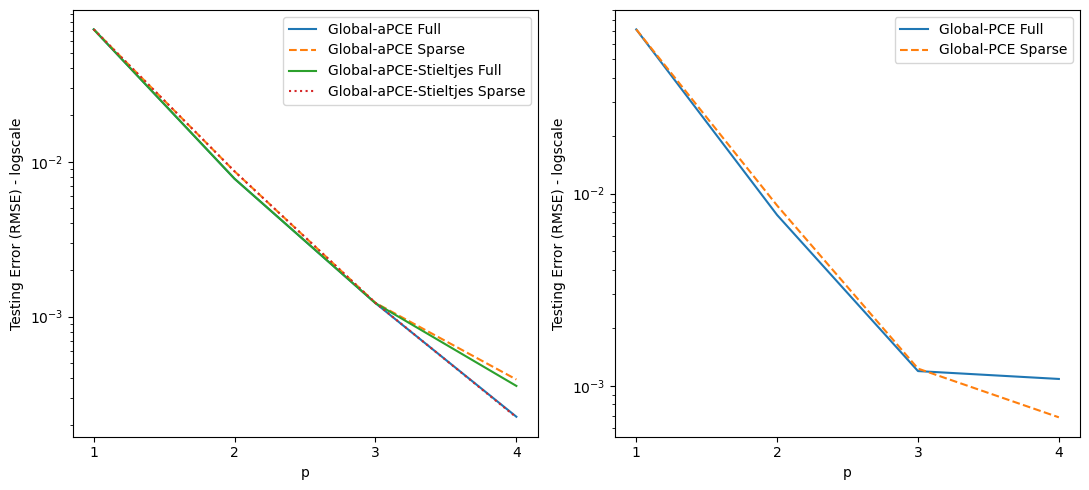

In [590]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Cantilever_AFVB_aPCE_Global[0], '-', label = 'Global-aPCE Full')
ax[0].plot(p, results_Cantilever_AFVB_aPCE_Global[1], '--', label = 'Global-aPCE Sparse')
ax[0].plot(p, results_Cantilever_AFVB_aPCE_Stieltjes_Global[0], '-', label = 'Global-aPCE-Stieltjes Full')
ax[0].plot(p, results_Cantilever_AFVB_aPCE_Stieltjes_Global[1], ':', label = 'Global-aPCE-Stieltjes Sparse')
#ax[0].plot(p, results_Cantilever_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
#ax[0].plot(p, results_Cantilever_AFVB_aPCE_ME[1], '-.', label = 'ME-aPCE Sparse')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

ax[1].plot(p, results_Cantilever_AFVB_PCE_Global[0], '-', label = 'Global-PCE Full')
ax[1].plot(p, results_Cantilever_AFVB_PCE_Global[1], '--', label = 'Global-PCE Sparse')
#ax[1].plot(p, results_Cantilever_AFVB_PCE_ME[0], '-x', label = 'ME-PCE Full')
#ax[1].plot(p, results_Cantilever_AFVB_PCE_ME[1], '-.', label = 'ME-PCE Sparse')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_AFVB_Error.png')

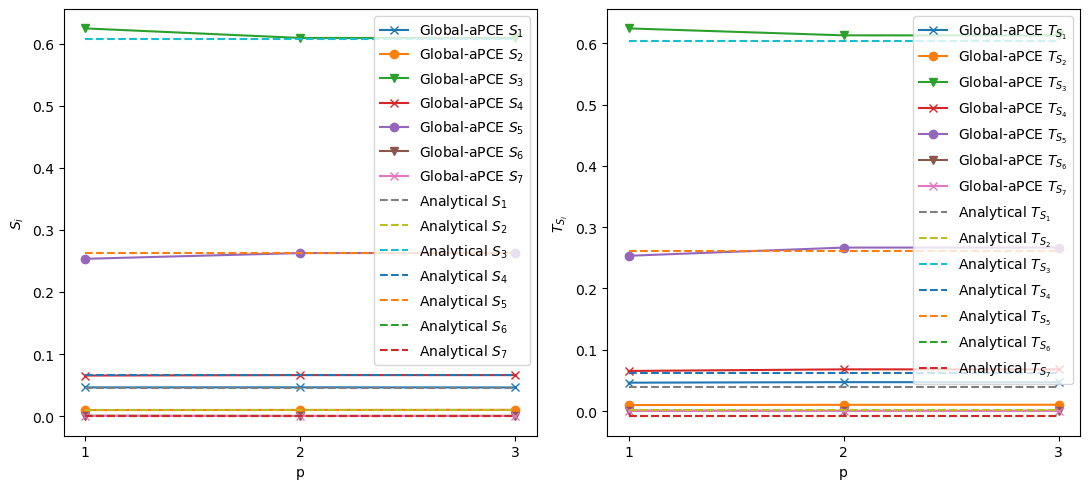

In [300]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,0], '-x', label = 'Global-aPCE $S_1$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,1], '-o', label = 'Global-aPCE $S_2$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,2], '-v', label = 'Global-aPCE $S_3$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,3], '-x', label = 'Global-aPCE $S_4$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,4], '-o', label = 'Global-aPCE $S_5$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,5], '-v', label = 'Global-aPCE $S_6$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[2])[:,6], '-x', label = 'Global-aPCE $S_7$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][0]]*3, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][1]]*3, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][2]]*3, '--', label = 'Analytical $S_3$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][3]]*3, '--', label = 'Analytical $S_4$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][4]]*3, '--', label = 'Analytical $S_5$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][5]]*3, '--', label = 'Analytical $S_6$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][6]]*3, '--', label = 'Analytical $S_7$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,0], '-x', label = 'Global-aPCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,1], '-o', label = 'Global-aPCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,2], '-v', label = 'Global-aPCE $T_{S_3}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,3], '-x', label = 'Global-aPCE $T_{S_4}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,4], '-o', label = 'Global-aPCE $T_{S_5}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,5], '-v', label = 'Global-aPCE $T_{S_6}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_Global[3])[:,6], '-x', label = 'Global-aPCE $T_{S_7}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][0]]*3, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][1]]*3, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][2]]*3, '--', label = 'Analytical $T_{S_3}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][3]]*3, '--', label = 'Analytical $T_{S_4}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][4]]*3, '--', label = 'Analytical $T_{S_5}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][5]]*3, '--', label = 'Analytical $T_{S_6}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][6]]*3, '--', label = 'Analytical $T_{S_7}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_AFVB_aPCE_GSA.png')

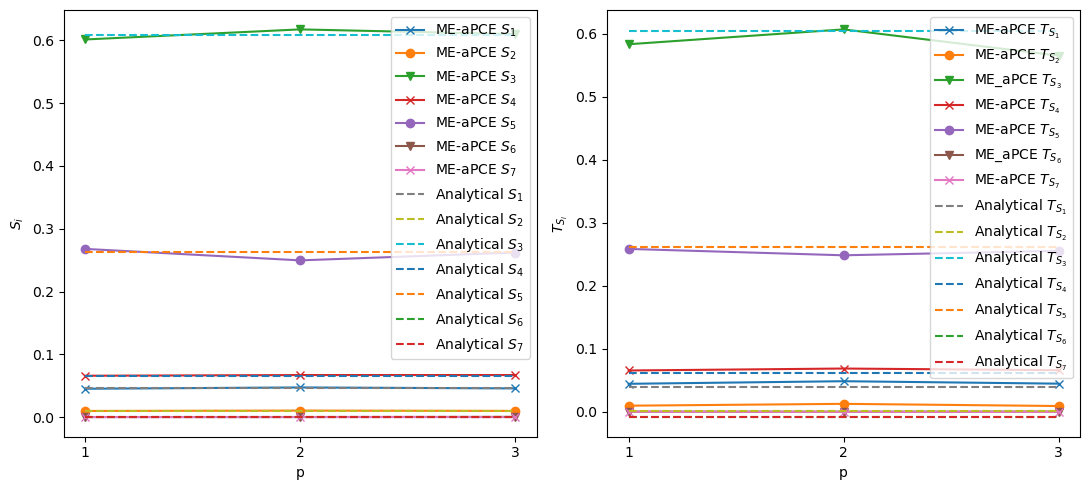

In [301]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)


ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,0], '-x', label = 'ME-aPCE $S_1$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,1], '-o', label = 'ME-aPCE $S_2$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,2], '-v', label = 'ME-aPCE $S_3$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,3], '-x', label = 'ME-aPCE $S_4$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,4], '-o', label = 'ME-aPCE $S_5$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,5], '-v', label = 'ME-aPCE $S_6$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[2])[:,6], '-x', label = 'ME-aPCE $S_7$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][0]]*3, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][1]]*3, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][2]]*3, '--', label = 'Analytical $S_3$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][3]]*3, '--', label = 'Analytical $S_4$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][4]]*3, '--', label = 'Analytical $S_5$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][5]]*3, '--', label = 'Analytical $S_6$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][6]]*3, '--', label = 'Analytical $S_7$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,0], '-x', label = 'ME-aPCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,1], '-o', label = 'ME-aPCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,2], '-v', label = 'ME_aPCE $T_{S_3}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,3], '-x', label = 'ME-aPCE $T_{S_4}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,4], '-o', label = 'ME-aPCE $T_{S_5}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,5], '-v', label = 'ME_aPCE $T_{S_6}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_aPCE_ME[3])[:,6], '-x', label = 'ME-aPCE $T_{S_7}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][0]]*3, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][1]]*3, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][2]]*3, '--', label = 'Analytical $T_{S_3}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][3]]*3, '--', label = 'Analytical $T_{S_4}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][4]]*3, '--', label = 'Analytical $T_{S_5}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][5]]*3, '--', label = 'Analytical $T_{S_6}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][6]]*3, '--', label = 'Analytical $T_{S_7}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_AFVB_aPCE_ME_GSA.png')

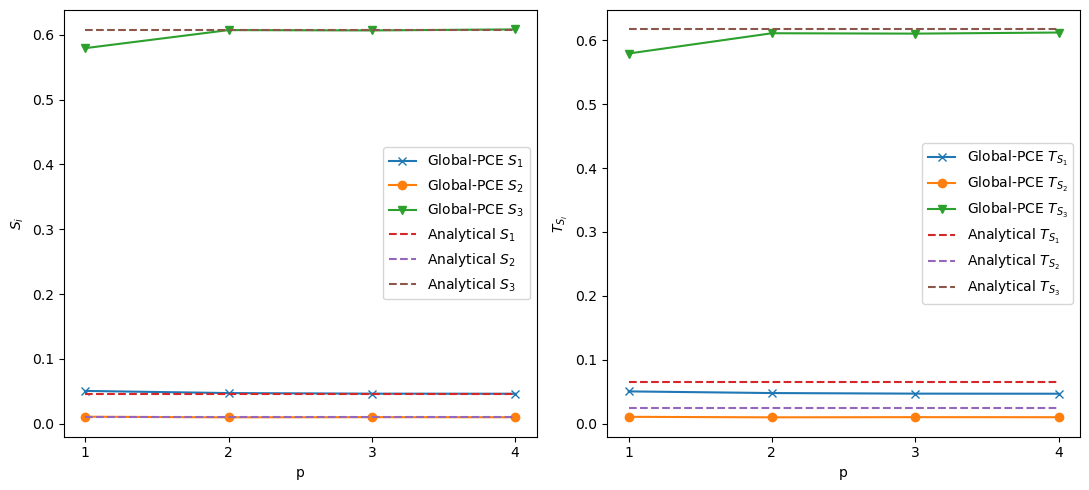

In [205]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.array(results_Cantilever_AFVB_PCE_Global[2])[:,0], '-x', label = 'Global-PCE $S_1$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_PCE_Global[2])[:,1], '-o', label = 'Global-PCE $S_2$')
ax[0].plot(p, np.array(results_Cantilever_AFVB_PCE_Global[2])[:,2], '-v', label = 'Global-PCE $S_3$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][0]]*4, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][1]]*4, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][2]]*4, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Cantilever_AFVB_PCE_Global[3])[:,0], '-x', label = 'Global-PCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_PCE_Global[3])[:,1], '-o', label = 'Global-PCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Cantilever_AFVB_PCE_Global[3])[:,2], '-v', label = 'Global-PCE $T_{S_3}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][0]]*4, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][1]]*4, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][2]]*4, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_AFVB_PCE_GSA.png')

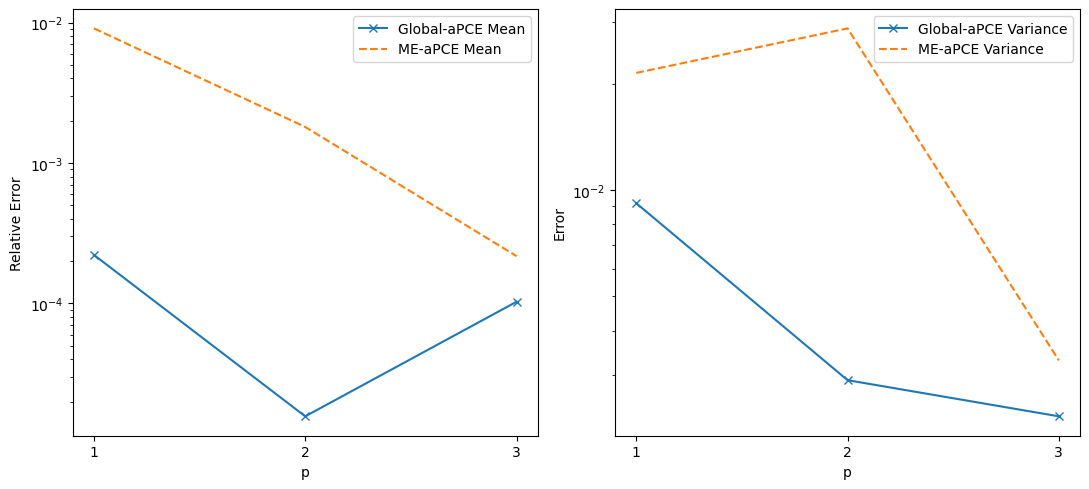

In [306]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global[4])-mean_Cantilever)/mean_Cantilever, '-x', label = 'Global-aPCE Mean')
ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_ME[4])-mean_Cantilever)/mean_Cantilever, '--', label = 'ME-aPCE Mean')

#ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[4])-mean_Cantilever)/mean_Cantilever, '-', label = 'Global-PCE Mean')
#ax[0].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_ME[4])-mean_Cantilever), '-.', label = 'ME-PCE Mean')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative Error")
ax[0].legend()

ax[1].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_Global[5])-V_Cantilever)/V_Cantilever, '-x', label = 'Global-aPCE Variance')
ax[1].plot(p, np.abs(np.array(results_Cantilever_AFVB_aPCE_ME[5])-V_Cantilever), '--', label = 'ME-aPCE Variance')

#ax[1].plot(p, np.abs(np.array(results_Cantilever_AFVB_PCE_Global[5])-V_Cantilever)/V_Cantilever, '-', label = 'Global-PCE Variance')
#ax[1].plot(range(1,11), np.abs(np.array(results_Cantilever_AFVB_PCE_ME[5])-V_Cantilever), '-.', label = 'ME-PCE Variance')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Error")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_AFVB_mean_V.png')

# VRVM 

## Global Models

### aPCE

In [9]:
# Optimized Hyper-Parameters: slurm-8832059
best_params_VRVM_Global_aPCE = [OrderedDict([('omega_a', 9.66376982461816e-06), ('omega_b', 6.369738478102248e-05), ('tau_a', 8.471065380628878e-05), ('tau_b', 0.009588683813530896)]), OrderedDict([('omega_a', 4.132592413748156e-06), ('omega_b', 6.098516732600181e-05), ('tau_a', 6.322428626726107e-05), ('tau_b', 0.005007421639694194)]), OrderedDict([('omega_a', 7.5946222396262055e-06), ('omega_b', 3.3010315600909255e-05), ('tau_a', 7.286899857351162e-05), ('tau_b', 0.005326320434218932)]), OrderedDict([('omega_a', 6.794750479588157e-06), ('omega_b', 2.5338618927647273e-05), ('tau_a', 3.6546781001136605e-05), ('tau_b', 0.004402844199148435)]), OrderedDict([('omega_a', 4.865373170995837e-06), ('omega_b', 9.24721397504968e-05), ('tau_a', 1.8334479447123527e-05), ('tau_b', 0.0015579645904136028)]), OrderedDict([('omega_a', 1.326270397918835e-06), ('omega_b', 7.733219275668981e-05), ('tau_a', 4.804734876289435e-05), ('tau_b', 0.00742123474304691)]), OrderedDict([('omega_a', 4.756967623853363e-06), ('omega_b', 6.460272259808157e-05), ('tau_a', 8.558300879720383e-05), ('tau_b', 0.0011710165003649036)]), OrderedDict([('omega_a', 2.6876509614545712e-06), ('omega_b', 8.912035197411411e-05), ('tau_a', 7.118934269926533e-05), ('tau_b', 0.00966268842163787)]), OrderedDict([('omega_a', 4.220192494966279e-06), ('omega_b', 4.3601423284303914e-05), ('tau_a', 3.065221650835922e-05), ('tau_b', 0.0014962542538943036)]), OrderedDict([('omega_a', 9.56024438764536e-06), ('omega_b', 6.553844942701352e-05), ('tau_a', 4.608382475782043e-05), ('tau_b', 0.0034648003953459423)]), OrderedDict([('omega_a', 6.888057395610939e-06), ('omega_b', 2.861319514998039e-05), ('tau_a', 2.9398170990979133e-05), ('tau_b', 0.0035472741093233347)]), OrderedDict([('omega_a', 3.7156839217061784e-06), ('omega_b', 6.058703527621388e-05), ('tau_a', 6.841583112348452e-05), ('tau_b', 0.007768768880858947)])]


In [ ]:
results_Cantilever_VRVM_aPCE_Global = collect_results_PCE(p, d, tf.cantilever, best_params_VRVM_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE', VRVM_PCE, None)

### PCE

In [ ]:
best_params_VRVM_Global_PCE = [OrderedDict([('omega_a', 1.5331650696884767e-05), ('omega_b', 9.227577445542909e-05), ('tau_a', 7.100854733675451e-05), ('tau_b', 6.602475146521386e-05)]), OrderedDict([('omega_a', 8.685745485376447e-06), ('omega_b', 9.749357994193433e-05), ('tau_a', 2.593261153111384e-05), ('tau_b', 7.279774432414233e-05)]), OrderedDict([('omega_a', 3.354304528850806e-05), ('omega_b', 1.7314618536025147e-05), ('tau_a', 5.466085468115754e-05), ('tau_b', 4.792281164681451e-05)]), OrderedDict([('omega_a', 8.188602063993157e-06), ('omega_b', 4.035819086901198e-05), ('tau_a', 6.574031205543258e-05), ('tau_b', 3.141887291296671e-06)]), OrderedDict([('omega_a', 1.4088972141302867e-05), ('omega_b', 4.1724395886751565e-05), ('tau_a', 5.3722579738355214e-05), ('tau_b', 2.01034642853206e-05)]), OrderedDict([('omega_a', 3.7657165865598554e-05), ('omega_b', 6.418320114595561e-05), ('tau_a', 9.624547491241109e-06), ('tau_b', 5.7414436959582974e-05)]), OrderedDict([('omega_a', 2.626482172666417e-05), ('omega_b', 7.760889730630263e-05), ('tau_a', 9.567938639240661e-05), ('tau_b', 3.407375072731916e-05)]), OrderedDict([('omega_a', 8.089587503775322e-05), ('omega_b', 2.1697620451632497e-05), ('tau_a', 4.750638754187007e-05), ('tau_b', 6.440128199410328e-05)]), OrderedDict([('omega_a', 7.382154543197795e-05), ('omega_b', 4.114919670341607e-05), ('tau_a', 1.6628916456461474e-05), ('tau_b', 7.686909746443789e-05)]), OrderedDict([('omega_a', 9.427894581298408e-05), ('omega_b', 9.572982420711138e-05), ('tau_a', 7.685276017538369e-05), ('tau_b', 4.814149211831182e-05)]), OrderedDict([('omega_a', 8.599473524106895e-05), ('omega_b', 5.292124597145868e-05), ('tau_a', 2.6715456076691473e-05), ('tau_b', 1.3788971891034581e-05)]), OrderedDict([('omega_a', 4.4508966683109065e-07), ('omega_b', 2.6887561301817605e-05), ('tau_a', 8.965705165694681e-05), ('tau_b', 5.7262752721173696e-05)]), OrderedDict([('omega_a', 4.686752149492646e-05), ('omega_b', 3.625034611105466e-05), ('tau_a', 8.044083067461392e-05), ('tau_b', 2.201350776375482e-05)]), OrderedDict([('omega_a', 9.940200151181392e-05), ('omega_b', 8.326823410958093e-05), ('tau_a', 6.280661539079046e-05), ('tau_b', 3.450666677254366e-05)])]


In [ ]:
results_Cantilever_VRVM_PCE_Global = collect_results_PCE(p, d, tf.cantilver, best_params_VRVM_Global_PCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Hermite', VRVM_PCE, 
                                                B_init = None, sigma_vals = sigma_vals, mu_vals = mu_vals)


## Local Models

### aPCE

In [10]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])


NameError: name 'd' is not defined

In [11]:
# Optimized Hyper-Parameters: slurm-8832064
best_params_VRVM_ME_aPCE = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), OrderedDict([('alpha', 0.035936313473569695), ('arg1', 1e-08), ('arg2', 2.655146354315031e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.8459693119306863), ('theta2', 0.04928222881285478)]), OrderedDict([('alpha', 1e-06), ('arg1', 6.842778231943695e-06), ('arg2', 7.781776387101613e-05), ('arg3', 2.022494965579457e-05), ('arg4', 6.911547620607852e-05), ('theta1', 0.8908168405773248), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.1565896386478665), ('arg1', 3.6691669112488755e-05), ('arg2', 3.666862211983487e-05), ('arg3', 5.722070880687537e-05), ('arg4', 6.831456628904052e-05), ('theta1', 0.42683953588204293), ('theta2', 0.08783128546219385)]), OrderedDict([('alpha', 0.5984529977308706), ('arg1', 3.6297762726049333e-05), ('arg2', 1.8814666390312428e-05), ('arg3', 7.202381543212009e-05), ('arg4', 2.303265940477397e-05), ('theta1', 0.9721868447583709), ('theta2', 0.7238330823343102)]), OrderedDict([('alpha', 0.17802959776874175), ('arg1', 5.855314779894947e-05), ('arg2', 2.496342435264212e-05), ('arg3', 4.89810809593937e-05), ('arg4', 8.666174664280051e-05), ('theta1', 0.5217987441992685), ('theta2', 0.7547399615484185)]), OrderedDict([('alpha', 0.5918806969293593), ('arg1', 1e-08), ('arg2', 3.3242655831437976e-05), ('arg3', 2.060187672010659e-05), ('arg4', 1e-08), ('theta1', 0.40442717574986653), ('theta2', 0.99)]), OrderedDict([('alpha', 0.25310562992270563), ('arg1', 3.915041494086702e-06), ('arg2', 4.317704582651805e-06), ('arg3', 8.324783135039999e-05), ('arg4', 3.532265925491864e-05), ('theta1', 0.19715023375961194), ('theta2', 0.5468975944050383)]), OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 1e-08), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.99), ('theta2', 0.99)]), OrderedDict([('alpha', 0.6482056324001543), ('arg1', 1e-08), ('arg2', 8.274670219152423e-05), ('arg3', 4.919889671614638e-05), ('arg4', 0.0001), ('theta1', 0.4867735801550905), ('theta2', 0.49294063313494696)])]


In [ ]:
results_Cantilever_VRVM_aPCE_ME = collect_results_ME(p, d, tf.cantilver, best_params_VRVM_ME_aPCE, 
                                                  X_train, X_pol, X_test, Y_train, 'aPCE', 
                                                  VRVM_PCE, B_init)

### PCE

In [ ]:
# Optimized Hyper-Parameters: slurm-8832062
#best_params_VRVM_ME_PCE = [OrderedDict([('alpha', 0.5632993961653334), ('arg1', 2.4710286258524645e-05), ('arg2', 8.287538093870098e-05), ('arg3', 7.167616444254344e-05), ('arg4', 1.656790852681137e-05), ('theta1', 0.7725763934762547), ('theta2', 0.1778266388284838)]), OrderedDict([('alpha', 0.5289437986914474), ('arg1', 1e-08), ('arg2', 0.0001), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.99), ('theta2', 0.6854114075800615)]), OrderedDict([('alpha', 0.99), ('arg1', 1e-08), ('arg2', 1.4867705384443327e-05), ('arg3', 1e-08), ('arg4', 0.0001), ('theta1', 0.4309897861424597), ('theta2', 1e-06)]), OrderedDict([('alpha', 0.13149842388851093), ('arg1', 2.858617221177075e-05), ('arg2', 1.9819140489252086e-05), ('arg3', 9.769346103224226e-05), ('arg4', 8.963112432413811e-05), ('theta1', 0.41901501810660696), ('theta2', 0.43084482438144067)]), OrderedDict([('alpha', 1e-06), ('arg1', 7.289738264009899e-05), ('arg2', 0.0001), ('arg3', 0.0001), ('arg4', 1e-08), ('theta1', 0.8579155099950342), ('theta2', 0.839801088286929)]), OrderedDict([('alpha', 1e-06), ('arg1', 1e-08), ('arg2', 2.6629814791561958e-05), ('arg3', 3.950895687160405e-05), ('arg4', 0.0001), ('theta1', 0.9659821744393433), ('theta2', 0.99)]), OrderedDict([('alpha', 0.23536533983669095), ('arg1', 1e-08), ('arg2', 4.3401574409528914e-05), ('arg3', 5.732709462579834e-07), ('arg4', 2.0164777873082108e-05), ('theta1', 0.583055632347364), ('theta2', 0.7640704380072287)]), OrderedDict([('alpha', 1e-06), ('arg1', 8.705489426977751e-07), ('arg2', 1.6797466983276716e-05), ('arg3', 1e-08), ('arg4', 5.5616270847537436e-05), ('theta1', 0.5569867953480909), ('theta2', 0.4303116952740246)]), OrderedDict([('alpha', 0.8155245997271127), ('arg1', 5.282755343067723e-05), ('arg2', 4.5899236653516115e-06), ('arg3', 1.4351811332222484e-06), ('arg4', 3.585608446971019e-05), ('theta1', 0.19913907035441367), ('theta2', 0.7850467522022636)]), OrderedDict([('alpha', 0.336504742387436), ('arg1', 9.333871305245319e-05), ('arg2', 8.546855404608885e-05), ('arg3', 5.066332825398189e-05), ('arg4', 7.209845076479927e-05), ('theta1', 0.4720998283860188), ('theta2', 0.8783985766775352)])]


In [ ]:
#results_Cantilever_VRVM_PCE_ME = collect_results_ME(p, d, tf.cantilever, best_params_VRVM_ME_PCE, 
#                                                  X_train, X_pol, X_test, Y_train, 'PCE_Hermite', VRVM_PCE, 
#                                                    B_init, sigma_vals = sigma_vals, mu_vals = mu_vals)

## Plots for VRVM - Cantilever

In [ ]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_Cantilever_VRVM_aPCE_Global[0], '-', label = 'Global-aPCE Full')
ax[0].plot(p, results_Cantilever_VRVM_aPCE_Global[1], '--', label = 'Global-aPCE Sparse')
ax[0].plot(p, results_Cantilever_VRVM_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
ax[0].plot(p, results_Cantilever_VRVM_aPCE_ME[1], '-.', label = 'ME-aPCE Sparse')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

ax[1].plot(p, results_Cantilever_VRVM_PCE_Global[0], '-', label = 'Global-PCE Full')
ax[1].plot(p, results_Cantilever_VRVM_PCE_Global[1], '--', label = 'Global-PCE Sparse')
ax[1].plot(p, results_Cantilever_VRVM_PCE_ME[0], '-x', label = 'ME-PCE Full')
ax[1].plot(p, results_Cantilever_VRVM_PCE_ME[1], '-.', label = 'ME-PCE Sparse')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_VRVM_Error.png')

In [ ]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.array(results_Cantilever_VRVM_aPCE_Global[2])[:,0], '-x', label = 'Global-aPCE $S_1$')
ax[0].plot(p, np.array(results_Cantilever_VRVM_aPCE_Global[2])[:,1], '-o', label = 'Global-aPCE $S_2$')
ax[0].plot(p, np.array(results_Cantilever_VRVM_aPCE_Global[2])[:,2], '-v', label = 'Global-aPCE $S_3$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][0]]*6, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][1]]*6, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][2]]*6, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Cantilever_VRVM_aPCE_Global[3])[:,0], '-x', label = 'Global-aPCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Cantilever_VRVM_aPCE_Global[3])[:,1], '-o', label = 'Global-aPCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Cantilever_VRVM_aPCE_Global[3])[:,2], '-v', label = 'Global-aPCE $T_{S_3}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][0]]*6, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][1]]*6, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][2]]*6, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_VRVM_aPCE_GSA.png')

In [ ]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)


ax[0].plot(range(1,11), np.array(results_Cantilever_VRVM_aPCE_ME[2])[:,0], '-x', label = 'ME-aPCE $S_1$')
ax[0].plot(range(1,11), np.array(results_Cantilever_VRVM_aPCE_ME[2])[:,1], '-o', label = 'ME-aPCE $S_2$')
ax[0].plot(range(1,11), np.array(results_Cantilever_VRVM_aPCE_ME[2])[:,2], '-v', label = 'ME-aPCE $S_3$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][0]]*6, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][1]]*6, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][2]]*6, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(range(1,11), np.array(results_Cantilever_VRVM_aPCE_ME[3])[:,0], '-x', label = 'ME-aPCE $T_{S_1}$')
ax[1].plot(range(1,11), np.array(results_Cantilever_VRVM_aPCE_ME[3])[:,1], '-o', label = 'ME-aPCE $T_{S_2}$')
ax[1].plot(range(1,11), np.array(results_Cantilever_VRVM_aPCE_ME[3])[:,2], '-v', label = 'ME_aPCE $T_{S_3}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][0]]*6, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][1]]*6, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][2]]*6, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_VRVM_aPCE_ME_GSA.png')

In [ ]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.array(results_Cantilever_VRVM_PCE_Global[2])[:,0], '-x', label = 'Global-PCE $S_1$')
ax[0].plot(p, np.array(results_Cantilever_VRVM_PCE_Global[2])[:,1], '-o', label = 'Global-PCE $S_2$')
ax[0].plot(p, np.array(results_Cantilever_VRVM_PCE_Global[2])[:,2], '-v', label = 'Global-PCE $S_3$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][0]]*6, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][1]]*6, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_Cantilever['1st Order'][2]]*6, '--', label = 'Analytical $S_3$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_Cantilever_VRVM_PCE_Global[3])[:,0], '-x', label = 'Global-PCE $T_{S_1}$')
ax[1].plot(p, np.array(results_Cantilever_VRVM_PCE_Global[3])[:,1], '-o', label = 'Global-PCE $T_{S_2}$')
ax[1].plot(p, np.array(results_Cantilever_VRVM_PCE_Global[3])[:,2], '-v', label = 'Global-PCE $T_{S_3}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][0]]*6, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][1]]*6, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_Cantilever['Total Order'][2]]*6, '--', label = 'Analytical $T_{S_3}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_VRVM_PCE_GSA.png')

In [ ]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[4])-3.5), '-x', label = 'Global-aPCE Mean')
ax[0].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_ME[4])-3.5), '--', label = 'ME-aPCE Mean')

ax[0].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[4])-3.5), '-', label = 'Global-PCE Mean')
#ax[0].plot(range(1,11), np.abs(np.array(results_Cantilever_VRVM_PCE_ME[4])-3.5), '-.', label = 'ME-PCE Mean')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Error")
ax[0].legend()

ax[1].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_Global[5])-V_Cantilever), '-x', label = 'Global-aPCE Variance')
ax[1].plot(p, np.abs(np.array(results_Cantilever_VRVM_aPCE_ME[5])-V_Cantilever), '--', label = 'ME-aPCE Variance')

ax[1].plot(p, np.abs(np.array(results_Cantilever_VRVM_PCE_Global[5])-V_Cantilever), '-', label = 'Global-PCE Variance')
#ax[1].plot(range(1,11), np.abs(np.array(results_Cantilever_VRVM_PCE_ME[5])-V_Cantilever), '-.', label = 'ME-PCE Variance')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Error")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/Cantilever_VRVM_mean_V.png')

# Example 3: Wing Weight Model

In [139]:
import openturns as ot
import openturns.viewer as otv
from openturns.usecases.wingweight_function import WingWeightModel

In [140]:
N_train = 120 # Sample size
N_test = 30
N_pol = 100000
N_mc = 1000000 #10^6 samples

d = 10

#### Fix the seed, it isn't working with this package!!!!!!!!

In [141]:
#inputNames = m.distributionX.getDescription()
ot.RandomGenerator.SetSeed(2357)

m = WingWeightModel()
X_train = np.array(m.distributionX.getSample(N_train))
X_pol = np.array(m.distributionX.getSample(N_pol))

Y_train = np.array(m.model(X_train))
X_test = np.array(m.distributionX.getSample(N_test))
Y_test = np.array(m.model(X_test))

X_mc = np.array(m.distributionX.getSample(N_mc))



In [142]:
def WingWeight(X):
    return np.array(m.model(X))

def data_wingweight(N, d, B):
    np.random.seed(2357)
    X = np.zeros((N, d))
    for i in range(d):
        X[:,i] = np.random.uniform(B[i][0], B[i][1], size = N)
    return X

In [143]:
p = list(range(1,4))

## MC GSA

In [64]:
dataA = pd.DataFrame(np.array(m.distributionX.getSample(N_mc))).values
dataB = pd.DataFrame(np.array(m.distributionX.getSample(N_mc))).values

GSA_WingWeight, V_WingWeight = sobol_GSA(d, WingWeight).sobol_MC(dataA, dataB)

In [65]:
mean_WingWeight = np.mean(WingWeight(X_mc))
#- mean=[268.091]
#- std-dev=[48.0753]

In [66]:
48.0753**2

2311.23447009

In [67]:
V_WingWeight

2310.66090189

In [68]:
mean_WingWeight

267.99725990423315

# AFVB

## Global Models

### aPCE

In [144]:
# Optimized Hyper-Parameters: slurm-10259858
best_params_AFVB_Global_aPCE = [OrderedDict([('A_0', 0.0013365316957040135), ('B_0', 5.18695850892141e-05), ('C_0', 0.004161241641895608), ('D_0', 9.993162375927729e-05)]), 
                                OrderedDict([('A_0', 0.0001), ('B_0', 2.6985682159963946e-05), ('C_0', 0.0001), ('D_0', 0.0001)]), 
                                OrderedDict([('A_0', 0.0006287916732470642), ('B_0', 6.113324628805371e-05), ('C_0', 0.0008528004848965614), ('D_0', 3.1161933543505305e-05)])]


In [145]:
results_WingWeight_AFVB_aPCE_Global = collect_results_PCE(p, d, WingWeight, best_params_AFVB_Global_aPCE, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE', AFVB_PCE, None)

0.10595893859863281
7
0.7244329452514648
23
18.969184160232544
23


### aPCE_Steiltjes

In [52]:
best_params_AFVB_Global_aPCE_Stieltjes = [OrderedDict([('A_0', 0.001142146949244737), ('B_0', 8.284499465394204e-05), ('C_0', 0.0030256236717219245), ('D_0', 9.996610355787171e-05)]), OrderedDict([('A_0', 0.01), ('B_0', 2.8313327494619468e-05), ('C_0', 0.001), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.005683355443806697), ('B_0', 1.9020835509471732e-05), ('C_0', 0.008799417749647914), ('D_0', 4.383937786730185e-05)])]


In [53]:
results_WingWeight_AFVB_aPCE_Stieltjes_Global = collect_results_PCE(p, d, WingWeight, best_params_AFVB_Global_aPCE_Stieltjes, 
                                                X_train, X_pol, X_test, Y_train, 'aPCE_Stieltjes', AFVB_PCE, None)

0.11315298080444336
7
0.93743896484375
23
17.941102981567383
31


### PCE

In [50]:
# Optimized Hyper-Parameters: slurm-10259853
best_params_AFVB_Global_PCE = [OrderedDict([('A_0', 0.0015689762921115673), ('B_0', 5.837244622676542e-05), ('C_0', 0.003963669994712426), ('D_0', 9.998331476126445e-05)]), OrderedDict([('A_0', 0.01), ('B_0', 2.463292434974256e-05), ('C_0', 0.001), ('D_0', 0.0001)]), OrderedDict([('A_0', 0.0030194406613090895), ('B_0', 1e-05), ('C_0', 0.009067163468127817), ('D_0', 3.730213614138297e-05)])]

B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]


In [51]:
results_WingWeight_AFVB_PCE_Global = collect_results_PCE(p, d, WingWeight, best_params_AFVB_Global_PCE, 
                                                X_train, X_pol, X_test, Y_train, 'PCE_Legendre', AFVB_PCE, B_init)


0.16826391220092773
7
0.8806707859039307
23
21.509188175201416
25


## Local Models

### aPCE

In [17]:
B_init = []
for i in range(d):
    B_init.append([np.min([X_train[:,i].min(), X_test[:,i].min(), X_pol[:,i].min()]), np.max([X_train[:,i].max(), X_test[:,i].max(), X_pol[:,i].max()])])


In [ ]:
p = list(range(1,2))
# Optimized Hyper-Parameters: slurm-8832063
best_params_AFVB_ME_aPCE = [OrderedDict([('alpha', 0.1), ('arg1', 0.01), ('arg2', 0.0001), ('arg3', 0.001), ('arg4', 0.0001), ('theta1', 1e-06), ('theta2', 1e-05)]), 
                            OrderedDict([('alpha', 0.3462017632943005), ('arg1', 0.008397493277779711), ('arg2', 9.648337354957665e-05), ('arg3', 0.004218682442134313), ('arg4', 7.919009150225524e-05), ('theta1', 7.796650974399749e-05), ('theta2', 0.0006589744845616483)]),
                            OrderedDict([('alpha', 0.6821553244638301), ('arg1', 0.00625318599363403), ('arg2', 7.901028774757963e-05), ('arg3', 0.005597507215949772), ('arg4', 1.0072406806288887e-05), ('theta1', 6.517078239420147e-05), ('theta2', 1e-05)]),
                            
                            OrderedDict([('alpha', 0.6821553244638301), ('arg1', 0.00625318599363403), ('arg2', 7.901028774757963e-05), ('arg3', 0.005597507215949772), ('arg4', 1.0072406806288887e-05), ('theta1', 6.517078239420147e-05), ('theta2', 1e-05)])]

results_WingWeight_AFVB_aPCE_ME = collect_results_ME(p, d, WingWeight, best_params_AFVB_ME_aPCE, 
                                                  X_test, 'aPCE', 
                                                  AFVB_PCE, N_t = 120, N_p = 100000, data_fun = data_wingweight,
                                                  B_init = B_init, n_iter = 2)


### aPCE_Stieltjes

In [44]:
results_WingWeight_AFVB_aPCE_Stieltjes_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_PCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  AFVB_PCE, data_ishigami, N_t = 100, N_p = None, 
                                                  B_init = B_init, n_iter = 1)

22.42189121246338
32
37.125842332839966
32
138.96673107147217
4


### PCE

In [43]:
B_init = [[150,200], [220,300], [6,10], [-10,10], [16,45], [0.5,1], [0.08,0.18], [2.5,6], [1700,2500], [0.025,0.08]]

results_WingWeight_AFVB_PCE_ME = collect_results_ME(p, d, tf.ishigami, best_params_AFVB_ME_PCE, 
                                                  X_test, 'PCE_Legendre', 
                                                  AFVB_PCE, data_ishigami, N_t = 100, N_p = None, 
                                                  B_init = B_init, n_iter = 1)

0.7184629440307617
1
3.24796724319458
1
64.39355111122131
1


In [60]:
sizePCE = 800
inputDesignPCE = m.distributionX.getSample(sizePCE)
outputDesignPCE = m.model(inputDesignPCE)

algo = ot.FunctionalChaosAlgorithm(inputDesignPCE, outputDesignPCE, m.distributionX)

algo.run()
result = algo.getResult()
print(result.getResiduals())
print(result.getRelativeErrors())

[0.000344543]
[4.32412e-08]


In [66]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
print(sensitivityAnalysis)

FunctionalChaosSobolIndices
- input dimension=10
- output dimension=1
- basis size=761
- mean=[268.074]
- std-dev=[48.0634]

| Index | Multi-index   | Variance part |
|-------|---------------|---------------|
|     8 | [0,0,0,0,0,0,0,1,0,0]| 0.410151      |
|     3 | [0,0,1,0,0,0,0,0,0,0]| 0.220277      |
|     7 | [0,0,0,0,0,0,1,0,0,0]| 0.138338      |
|     1 | [1,0,0,0,0,0,0,0,0,0]| 0.124595      |
|     9 | [0,0,0,0,0,0,0,0,1,0]| 0.0847323     |

| Input | Name          | Sobol' index  | Total index   |
|-------|---------------|---------------|---------------|
|     0 | Sw            | 0.124602      | 0.128014      |
|     1 | Wfw           | 2.16904e-06   | 8.96096e-06   |
|     2 | A             | 0.220427      | 0.226238      |
|     3 | Lambda        | 0.000489921   | 0.000511032   |
|     4 | q             | 9.20234e-05   | 0.000101967   |
|     5 | l             | 0.00183476    | 0.00191017    |
|     6 | tc            | 0.140907      | 0.145035      |
|     7 | Nz           

In [88]:
GSA_WingWeight

,Partial Variance,Total Variance,1st Order,Total Order
0,288.175428,295.102050,0.124600,0.127595
1,0.571313,-0.544259,0.000247,-0.000235
2,510.151729,523.948832,0.220577,0.226543
3,1.691333,0.521949,0.000731,0.000226
4,0.781403,-0.294278,0.000338,-0.000127
5,4.754389,3.679243,0.002056,0.001591
6,326.514677,335.022923,0.141177,0.144856
7,952.033985,968.933858,0.411637,0.418944
8,197.176348,200.356191,0.085254,0.086629
9,8.268610,7.473875,0.003575,0.003232


# Plots AFVB - Wing Weight Function

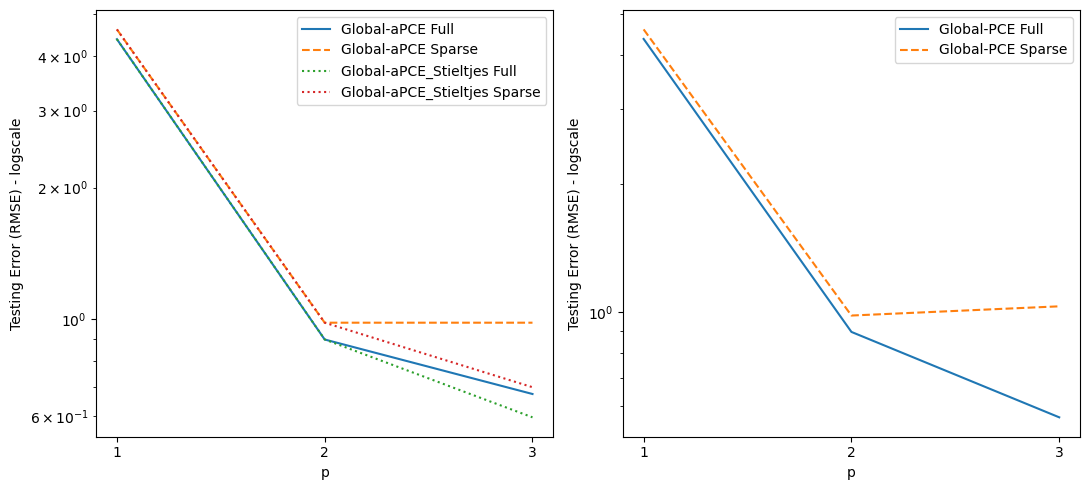

In [146]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, results_WingWeight_AFVB_aPCE_Global[0], '-', label = 'Global-aPCE Full')
ax[0].plot(p, results_WingWeight_AFVB_aPCE_Global[1], '--', label = 'Global-aPCE Sparse')
ax[0].plot(p, results_WingWeight_AFVB_aPCE_Stieltjes_Global[0], ':', label = 'Global-aPCE_Stieltjes Full')
ax[0].plot(p, results_WingWeight_AFVB_aPCE_Stieltjes_Global[1], ':', label = 'Global-aPCE_Stieltjes Sparse')
#ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_ME[0], '-x', label = 'ME-aPCE Full')
#ax[0].plot(range(1,4), results_WingWeight_AFVB_aPCE_ME[1], '-.', label = 'ME-aPCE Sparse')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Testing Error (RMSE) - logscale")
ax[0].legend()

ax[1].plot(p, results_WingWeight_AFVB_PCE_Global[0], '-', label = 'Global-PCE Full')
ax[1].plot(p, results_WingWeight_AFVB_PCE_Global[1], '--', label = 'Global-PCE Sparse')
#ax[1].plot(p, (results_WingWeight_AFVB_PCE_ME[0]), '-x', label = 'ME-PCE Full')
#ax[1].plot(p, (results_WingWeight_AFVB_PCE_ME[1]), '-.', label = 'ME-PCE Sparse')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Testing Error (RMSE) - logscale")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/WingWeight_AFVB_Error.png')

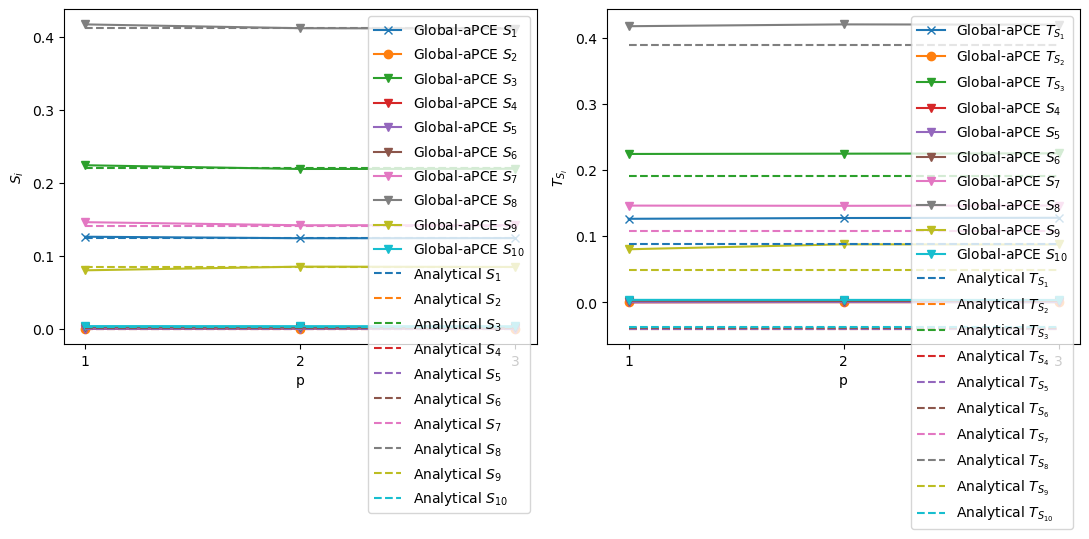

In [34]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,0], '-x', label = 'Global-aPCE $S_1$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,1], '-o', label = 'Global-aPCE $S_2$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,2], '-v', label = 'Global-aPCE $S_3$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,3], '-v', label = 'Global-aPCE $S_4$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,4], '-v', label = 'Global-aPCE $S_5$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,5], '-v', label = 'Global-aPCE $S_6$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,6], '-v', label = 'Global-aPCE $S_7$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,7], '-v', label = 'Global-aPCE $S_8$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,8], '-v', label = 'Global-aPCE $S_9$')
ax[0].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[2])[:,9], '-v', label = 'Global-aPCE $S_{10}$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][0]]*3, '--', label = 'Analytical $S_1$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][1]]*3, '--', label = 'Analytical $S_2$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][2]]*3, '--', label = 'Analytical $S_3$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][3]]*3, '--', label = 'Analytical $S_4$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][4]]*3, '--', label = 'Analytical $S_5$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][5]]*3, '--', label = 'Analytical $S_6$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][6]]*3, '--', label = 'Analytical $S_7$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][7]]*3, '--', label = 'Analytical $S_8$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][8]]*3, '--', label = 'Analytical $S_9$')
ax[0].plot(p, [GSA_WingWeight['1st Order'][9]]*3, '--', label = 'Analytical $S_{10}$')
ax[0].set_xticks(p)
#plt.yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$S_i$")
ax[0].legend()

ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,0], '-x', label = 'Global-aPCE $T_{S_1}$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,1], '-o', label = 'Global-aPCE $T_{S_2}$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,2], '-v', label = 'Global-aPCE $T_{S_3}$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,3], '-v', label = 'Global-aPCE $S_4$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,4], '-v', label = 'Global-aPCE $S_5$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,5], '-v', label = 'Global-aPCE $S_6$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,6], '-v', label = 'Global-aPCE $S_7$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,7], '-v', label = 'Global-aPCE $S_8$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,8], '-v', label = 'Global-aPCE $S_9$')
ax[1].plot(p, np.array(results_WingWeight_AFVB_aPCE_Global[3])[:,9], '-v', label = 'Global-aPCE $S_{10}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][0]]*3, '--', label = 'Analytical $T_{S_1}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][1]]*3, '--', label = 'Analytical $T_{S_2}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][2]]*3, '--', label = 'Analytical $T_{S_3}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][3]]*3, '--', label = 'Analytical $T_{S_4}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][4]]*3, '--', label = 'Analytical $T_{S_5}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][5]]*3, '--', label = 'Analytical $T_{S_6}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][6]]*3, '--', label = 'Analytical $T_{S_7}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][7]]*3, '--', label = 'Analytical $T_{S_8}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][8]]*3, '--', label = 'Analytical $T_{S_9}$')
ax[1].plot(p, [GSA_WingWeight['Total Order'][9]]*3, '--', label = 'Analytical $T_{S_{10}}$')
ax[1].set_xticks(p)
#plt.yscale("log")
ax[1].set_xlabel("p")
plt.ylabel("$T_{S_i}$")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/WingWeight_AFVB_aPCE_GSA.png')

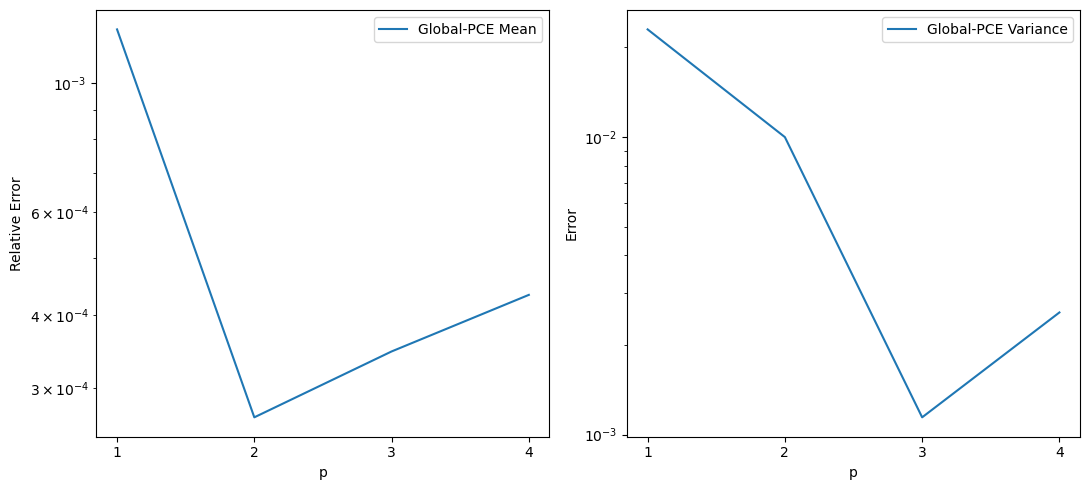

In [252]:
plt.rcParams['figure.figsize'] = (11,5) # (width, height)
fig, ax = plt.subplots(1, 2)

#ax[0].plot(p, np.abs(np.array(results_WingWeight_AFVB_aPCE_Global[4])-mean_WingWeight)/mean_WingWeight, '-x', label = 'Global-aPCE Mean')
#ax[0].plot(p, np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[4])-mean_WingWeight)/mean_WingWeight, '--', label = 'ME-aPCE Mean')

ax[0].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_Global[4])-mean_WingWeight)/mean_WingWeight, '-', label = 'Global-PCE Mean')
#ax[0].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[4])-mean_WingWeight), '-.', label = 'ME-PCE Mean')
ax[0].set_xticks(p)
ax[0].set_yscale("log")
ax[0].set_xlabel("p")
ax[0].set_ylabel("Relative Error")
ax[0].legend()

#ax[1].plot(p, np.abs(np.array(results_WingWeight_AFVB_aPCE_Global[5])-V_WingWeight)/V_WingWeight, '-x', label = 'Global-aPCE Variance')
#ax[1].plot(p, np.abs(np.array(results_WingWeight_AFVB_aPCE_ME[5])-V_WingWeight), '--', label = 'ME-aPCE Variance')

ax[1].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_Global[5])-V_WingWeight)/V_WingWeight, '-', label = 'Global-PCE Variance')
#ax[1].plot(p, np.abs(np.array(results_WingWeight_AFVB_PCE_ME[5])-V_WingWeight), '-.', label = 'ME-PCE Variance')
ax[1].set_xticks(p)
ax[1].set_yscale("log")
ax[1].set_xlabel("p")
ax[1].set_ylabel("Error")
ax[1].legend()

fig.tight_layout();
#plt.savefig(wd + '/WingWeight_AFVB_mean_and_Variance.png')

# Example 4: Flood Model

In [93]:
import openturns as ot
import openturns.viewer as otv
from openturns.usecases import flood_model

In [94]:
N_train = 320 # Sample size
N_test = 80
N_pol = 100000
N_mc = 1000000 #10^6 samples

d = 8

In [95]:
#inputNames = m.distributionX.getDescription()
ot.RandomGenerator.SetSeed(2357)

fm = flood_model.FloodModel()
X_train = np.array(fm.distributionX.getSample(N_train))
X_pol = np.array(fm.distributionX.getSample(N_pol))

Y_train = np.array(fm.model(X_train))
X_test = np.array(fm.distributionX.getSample(N_test))
Y_test = np.array(fm.model(X_test))

X_mc = np.array(fm.distributionX.getSample(N_mc))

AttributeError: 'FloodModel' object has no attribute 'distributionX'

In [97]:
print("Output:", fm.model.getOutputDescription())

Output: [H,S,C]


In [95]:
from sklearn.linear_model import LinearRegression
import math
from itertools import product
from scipy.special import legendre
from scipy.special import hermitenorm
from sklearn.metrics import mean_squared_error
import sys
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aPCE
import AFVB_PCE
import VRVM_PCE
import ME_PCE
from numpy import polynomial as pol
from sympy import symbols, lambdify, diff
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from collections import OrderedDict

In [2]:
import skopt
from skopt import BayesSearchCV

In [3]:
import scipy.integrate as integrate
import scipy.special as special
import time

In [6]:
## Directory where I want the plots saved
wd = '/Users/chave/Desktop/ThesisFiles/SparseBayesianLearning'

# Basis Functions

In [15]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [6]:
def basis(Z, p, PCE_method, aPCE_model = None, P = None, domain = None):
    """
    PCE_method: aPCE or PCE_Legendre
    aPCE_model: mod or None
    P: P or P_Steiltjs or None
    domain: Looks like np.array([[a,b], [a,b], [a,b], ...])
    """
    
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    Phi = np.ones((N, n))
    idx = multivariate_pce_index(d, p)
    
    if (PCE_method == 'aPCE'):
        for i in range(n):
            for j in range(d):
                Phi[:,i] *=  aPCE_model.Pol_eval(P[j][idx[i][j]], Z[:,j])
                
    elif (PCE_method == 'PCE_Legendre'):
        a = domain[:,0]
        b = domain[:,1]
        for i in range(n):
            for j in range(d):
                Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])((a[j]+b[j]-2*Z[:,j])/(a[j]-b[j]))
    else: 
        print('Proper PCE_method not given')
            
    return Phi

# Results Function

In [7]:
def GSA(a, idx, active_cols):
    
    V = np.sum(a[1:]**2)
    V_Partial = []
    V_Total = []
    S_Partial = []
    S_Total = []
    
    l = [0,1,2]
    
    for k in range(d):
        l = list(range(d))
        l.remove(k)
        
        temp = np.full(idx[active_cols].shape[0], True, dtype = bool)
        
        for i in range(idx[active_cols].shape[0]):
            temp[i] = (idx[active_cols][i][k] != 0) & (sum(idx[active_cols][i][l]) == 0)
            
        V_Partial.append(np.sum(a[temp]**2))
        S_Partial.append(np.sum(a[temp]**2)/V)

        for i in range(idx[active_cols].shape[0]):
            temp[i] = idx[active_cols][i][k] != 0

        V_Total.append(np.sum(a[temp]**2))
        S_Total.append(np.sum(a[temp]**2)/V)

        GSA_df = pd.DataFrame({
            #"variable" : list(range(1,d+1)),
            "Partial Variance" : V_Partial,
            "Total Variance" : V_Total,
            "1st Order" : S_Partial,
            "Total Order" : S_Total
        })
    
    
    return V, GSA_df

In [8]:
def Results(X_train, X_test, Y_train, Y_test, model_init, idx):
    
    N_train = X_train.shape[0]
    ## Fitting Model
    t0 = time.time()
    model = model_init.fit(X_train, Y_train.reshape(N_train))
    t_final = time.time() - t0
    
    ## RMSE
    RMSE_full_Train = np.sqrt(mean_squared_error(Y_train, model.predict(X_train, sparse = False)))
    RMSE_sparse_Train = np.sqrt(mean_squared_error(Y_train, model.predict(X_train)))
    
    RMSE_full_Test = np.sqrt(mean_squared_error(Y_test, model.predict(X_test, sparse = False)))
    RMSE_sparse_Test = np.sqrt(mean_squared_error(Y_test, model.predict(X_test)))
    
    data_Error = [[N_pol, model.n_star, RMSE_full_Train, RMSE_sparse_Train, RMSE_full_Test, RMSE_sparse_Test, t_final/60]]
    df_Error = pd.DataFrame(data_Error, columns=['N_pol', 'n_star', 'RMSE_Train_full', 'RMSE_Train_sparse', 'RMSE_Test_full', 'RMSE_Test_sparse', 'time (min)'])

    ## GSA
    V, df_GSA = GSA(model.a_hat, idx, model.active_cols)

    
    return df_Error, df_GSA, model, V

In [9]:
def plot_Error(Error1, Error2, Error3, Error4, scale, scale_label, n):
    temp1 = pd.concat([Error1*scale, Error2*scale], 
                  ignore_index = True, sort = False)[['RMSE_Test_full', 'RMSE_Test_sparse']]
    temp1.index = ['aPCE', 'PCE']

    temp1.columns = (['Full Expansion', 'Sparse Expansion'])
    
    temp2 = pd.concat([Error3*scale, Error4*scale], 
                  ignore_index = True, sort = False)[['RMSE_Test_full', 'RMSE_Test_sparse']]
    temp2.index = ['aPCE', 'PCE']

    temp2.columns = (['Full Expansion', 'Sparse Expansion'])
    
    max_val = np.max(np.array([np.max(temp1.values), np.max(temp2.values)]))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.tight_layout(pad=5.0)
    ax1 = temp1.plot.bar(ax=axes[0], rot = 0, color = ['green', 'red'], fontsize = 15)
    ax1.set_ylim(0, max_val+2)
    ax1.set_title("AFVB", fontsize = 20)
    ax1.text(-0.5,max_val+1.6, scale_label)
    ax1.text(-0.48,max_val+1, 'n =' + str(n), 
             fontsize = 13, color = 'g', weight = 'bold')
    ax1.text(0,np.max(temp1.values)+0.1, 'n* =' + str(np.array(Error1['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax1.text(1,np.max(temp1.values)+0.1, 'n* =' + str(np.array(Error2['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax1.set_ylabel('Testing Error (RMSE)', fontsize = 15);
    
    ax2 = temp2.plot.bar(ax=axes[1], rot = 0, color = ['green', 'red'], fontsize = 15)
    ax2.set_ylim(0, max_val+2)
    ax2.set_title("VRVM", fontsize = 20)
    ax2.text(-0.5,max_val+1.6, scale_label)
    ax2.text(-0.48,max_val+1, 'n =' + str(n), 
             fontsize = 13, color = 'g', weight = 'bold')
    ax2.text(0,np.max(temp2.values)+0.1, 'n* =' + str(np.array(Error3['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax2.text(1,np.max(temp2.values)+0.1, 'n* =' + str(np.array(Error4['n_star'])[0]), 
             fontsize = 13, color = 'r', weight = 'bold')
    ax2.set_ylabel('Testing Error (RMSE)', fontsize = 15);

In [10]:
def plot_Sobol_Indices(GSA1, GSA2, GSA3, GSA4 = None, l = 1, ylimit = 100, fig_size = (6.4, 4.8), table_size = 1):

    
    if GSA4 is None:
        col = ['green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['1st Order']], GSA2[['1st Order']], GSA3[['1st Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Order']], GSA2[['Total Order']], GSA3[['Total Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp.columns = (['MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
    else:
        col = ['red', 'green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['1st Order']], GSA2[['1st Order']], GSA3[['1st Order']], GSA4[['1st Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Order']], GSA2[['Total Order']], GSA3[['Total Order']], GSA4[['Total Order']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp.columns = (['Analytical', 'MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
        
    
    ax1 = temp.plot.bar(rot = 0, color = col, fontsize = 15, figsize=fig_size)
    ax1.set_ylim(0, ylimit)
    ax1.get_legend().remove()

    #defining the attributes
    col_labels = l
    row_labels = temp.columns
    table_vals = temp.values
    row_colors = col
    #plotting
    my_table = plt.table(cellText = np.round(table_vals.T, 3),
                         colWidths = [0.12]*2*temp.shape[0], 
                         rowLabels = row_labels,
                         colLabels = col_labels,
                         rowColours = row_colors,
                         loc = 'upper right',
                         rowLoc = 'center')
    my_table.scale(table_size, 1.2)

In [11]:
def plot_Variances(GSA1, GSA2, GSA3, V1, V2, V3, V4 = None, GSA4 = None, 
                   l = 1, ylimit = 100, fig_size = (6.4, 4.8), table_size = 1):

    if GSA4 is None:
        V_all = pd.DataFrame([V1, V2, V3])
        col = ['green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['Partial Variance']], GSA2[['Partial Variance']], GSA3[['Partial Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Variance']], GSA2[['Total Variance']], GSA3[['Total Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp = pd.concat([V_all.T, temp], ignore_index = True, sort = False)
        temp.columns = (['MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
    else:
        V_all = pd.DataFrame([V1, V2, V3, V4])
        col = ['red', 'green', 'blue', 'orange']
        temp1 = pd.concat([GSA1[['Partial Variance']], GSA2[['Partial Variance']], GSA3[['Partial Variance']], GSA4[['Partial Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp2 = pd.concat([GSA1[['Total Variance']], GSA2[['Total Variance']], GSA3[['Total Variance']], GSA4[['Total Variance']]], 
                  axis = 1, ignore_index = True, sort = False)
        temp = pd.concat([temp1, temp2], ignore_index = True, sort = False)
        temp = pd.concat([V_all.T, temp], ignore_index = True, sort = False)
        temp.columns = (['Analytical', 'MCS', 'AFVB-aPCE', 'VRVM-aPCE'])
        temp.index = (l)
        
    ax1 = temp.plot.bar(rot = 0, color = col, fontsize = 15, figsize=fig_size)
    ax1.set_ylim(0, ylimit)
    ax1.get_legend().remove()

    #defining the attributes
    col_labels = l
    row_labels = temp.columns
    table_vals = temp.values
    row_colors = col
    #plotting
    my_table = plt.table(cellText = np.round(table_vals.T, 3),
                         colWidths = [0.12]*2*temp.shape[0], 
                         rowLabels = row_labels,
                         colLabels = col_labels,
                         rowColours = row_colors,
                         loc = 'upper right',
                         rowLoc = 'center')
    my_table.scale(table_size, 1.2)

## MC Sobol Indices Function

In [12]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

def sobol_indice_1st_and_total_order(model, variable_index, dataA, dataB):

    dataB_withA = create_dataAB(dataA, dataB, variable_index)

    N = len(dataA)

    y_A = model(dataA)
    y_AB = model(dataB_withA)
    y_B = model(dataB)
    V = np.var(model(dataA))

    num_1st_order = N*np.sum(np.multiply(y_A,y_AB)) - (np.sum(y_A)*np.sum(y_AB))
    num_tot = N*np.sum(np.multiply(y_B,y_AB)) - (np.sum(y_A)**2)
    deno = N*np.sum(y_A**2) - (np.sum(y_A))**2

    return np.round(V*num_1st_order/deno, 4), np.round(V*(1 - (num_tot/deno)), 4), np.round(num_1st_order/deno, 4), np.round((1 - (num_tot/deno)), 4), np.round(V, 4)


In [13]:
def create_dataAB(dataA, dataB, variable_index_to_fix):
    dataB_withA = dataB.copy()
    dataB_withA[:, variable_index_to_fix] = dataA[:, variable_index_to_fix]
    return dataB_withA

def sobol_indice_1st_and_total_order(model, variable_index, dataA, dataB):

    dataB_withA = create_dataAB(dataA, dataB, variable_index)

    N = len(dataA)

    y_A = model(dataA)
    y_AB = model(dataB_withA)
    y_B = model(dataB)
    V = np.var(model(dataA))

    num_1st_order = N*np.sum(np.multiply(y_A,y_AB)) - (np.sum(y_A)*np.sum(y_AB))
    num_tot = N*np.sum(np.multiply(y_B,y_AB)) - (np.sum(y_A)**2)
    deno = N*np.sum(y_A**2) - (np.sum(y_A))**2

    return np.round(V*num_1st_order/deno, 4), np.round(V*(1 - (num_tot/deno)), 4), np.round(num_1st_order/deno, 4), np.round((1 - (num_tot/deno)), 4), np.round(V, 4)


def MC_Sobol(fun, dataA, dataB):
    V_partial = []
    V_total = []
    st_order = []
    total = []
    for i in range(d):
        results = sobol_indice_1st_and_total_order(fun, i, dataA, dataB)
        V_partial.append(results[0])
        V_total.append(results[1])
        st_order.append(results[2])
        total.append(results[3])
        V = results[4]

    df_result = pd.DataFrame({
        "Partial Variance" : V_partial,
        "Total Variance" : V_total,
        "1st Order" : st_order,
        "Total Order" : total
        })
    
    return df_result, V

## Variables for AFVB Model

In [14]:
T_ell = 0.001 # T_ell --> threshold value for the VLB (for the error e_ell) in percent
e = 1000

In [15]:
N_train = 320 # Sample size
N_test = 80
N_pol = 1000000
N_mc = 1000000 #10^6 samples

# Example 1: Ishigami Function

In [16]:
d = 3  # d --> number of random variables
#p = 5 # p --> degree of PCE polynomial
#n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [17]:
V_Ishigami = 7**2/8 + 0.1*np.pi**4/5 + 0.1**2*np.pi**8/18 + 1/2
GSA_Ishigami = ([1/2*(1+0.1*np.pi**4/5)**2, 7**2/8, 0],
                [1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225, 7**2/8, 8*0.1**2*np.pi**8/225],
                [1/2*(1+0.1*np.pi**4/5)**2/V_Ishigami, 7**2/8/V_Ishigami, 0],
                [(1/2*(1+0.1*np.pi**4/5)**2 + 8*0.1**2*np.pi**8/225)/V_Ishigami, 7**2/8/V_Ishigami, 8*0.1**2*np.pi**8/225/V_Ishigami])
GSA_Ishigami = pd.DataFrame(GSA_Ishigami).T
GSA_Ishigami.columns = ['Partial Variance', 'Total Variance', '1st Order', 'Total Order']

## Data

In [1]:
def Ishigami_Function(dat):
    Z = dat
    return np.c_[np.sin(Z[:,0]) + 7*(np.sin(Z[:,1]))**2 + 0.1*(Z[:,2])**4*np.sin(Z[:,0])]

In [19]:
np.random.seed(2357)

N_train = 320 # Sample size
N_test = 80
N_pol = 1000000
N_mc = 1000000 #10^6 samples

X_train = np.random.uniform(-np.pi, np.pi, size=(N_train, d))
X_test = np.random.uniform(-np.pi, np.pi, size=(N_test, d))
Y_train = Ishigami_Function(X_train)
Y_test = Ishigami_Function(X_test)

X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

## MC Estimation of GSA

In [3]:
dataA = pd.DataFrame(np.random.uniform(-np.pi, np.pi, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(-np.pi, np.pi, size=(N_mc, d))).values

#Sobol_MC_Ishigami, V_MC_Ishigami = MC_Sobol(Ishigami_Function, dataA, dataB)

In [4]:
Ishigami_GSA_MC = sa.sobol_GSA(3, Ishigami_Function)

In [5]:
Ishigami_GSA_MC.sobol_MC(dataA, dataB)

,Partial Variance,Total Variance,1st Order,Total Order
0,4.333810,7.712377,0.313317,0.557575
1,6.105450,6.131410,0.441400,0.443277
2,-0.005944,3.384606,-0.000430,0.244694


In [127]:
np.random.uniform(-np.pi, np.pi, size=(N_mc, d))

array([[ 2.32038817, -2.64248877,  1.51218932],
       [ 1.5558718 ,  0.04015659,  2.7605449 ],
       [ 2.31657192,  1.95453281, -2.71503011],
       ...,
       [ 2.94590645, -0.36669985, -1.31144166],
       [-2.86912093,  0.56128968,  1.65762951],
       [-2.46470329,  2.44406893, -1.16516297]])

In [97]:
Sobol_MC_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.3381,7.7274,0.3133,0.5581
1,6.1097,6.1845,0.4413,0.4467
2,-0.0036,3.3918,-0.0003,0.2450


In [98]:
V_MC_Ishigami

13.845

## Tuning of Hyperparameters
### ME-PCE -  Tunning $\theta_1$, $\theta_2$, and $\alpha$

In [21]:
B_init = [[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]
p =[3, 4, 5, 6, 9, 12]

### AFVB-aPCE

In [22]:
param_space_AFVB = {'arg1': skopt.space.Real(0.00001, 0.1), # A_0
              'arg2': skopt.space.Real(0.00001, 0.1), # B_0
              'arg3': skopt.space.Real(0.00001, 0.1), # C_0
              'arg4': skopt.space.Real(0.00001, 0.1) # D_0
         }

In [23]:
param_space_AFVB = {'arg1': skopt.space.Real(0.00001, 0.1), # A_0
              'arg2': skopt.space.Real(0.00001, 0.1), # B_0
              'arg3': skopt.space.Real(0.00001, 0.1), # C_0
              'arg4': skopt.space.Real(0.00001, 0.1) # D_0
         }
param_space_ME = {'theta1': skopt.space.Real(0.00001, 0.9),
              'theta2': skopt.space.Real(0.00001, 0.9),
              'alpha': skopt.space.Real(0.00001, 0.9),
              'arg1': skopt.space.Real(0.00001, 0.1), # A_0
              'arg2': skopt.space.Real(0.00001, 0.1), # B_0
              'arg3': skopt.space.Real(0.00001, 0.1), # C_0
              'arg4': skopt.space.Real(0.00001, 0.1) # D_0
         }

In [74]:
def parameter_values(param_list, t):
    
    param1 = []
    param2 = []
    param3 = []
    param4 = []


    for j in range(t):
        param1.append(list(param_list[j].values())[0])
        param2.append(list(param_list[j].values())[1])
        param3.append(list(param_list[j].values())[2])
        param4.append(list(param_list[j].values())[3])
        
    return param1, param2, param3, param4

In [75]:
def parameter_values_ME(param_list, t):
    
    param1 = []
    param2 = []
    param3 = []
    param4 = []
    param5 = []
    param6 = []
    param7 = []

    for j in range(t):
        param1.append(list(param_list[j].values())[0])
        param2.append(list(param_list[j].values())[1])
        param3.append(list(param_list[j].values())[2])
        param4.append(list(param_list[j].values())[3])
        param5.append(list(param_list[j].values())[4])
        param6.append(list(param_list[j].values())[5])
        param7.append(list(param_list[j].values())[6])
        
    return param1, param2, param3, param4, param5, param6, param7

### Optimizing hyperparameters for the Local ME-aPCE

In [64]:
best_params_AFVB_ME_aPCE = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], False, size_restriction = 25, B_split = None),
                                search_spaces = param_space_ME,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_ME_aPCE.append(optimizer.best_params_)

103.53456070423127 min
73.30838203430176 min
149.1512567838033 min
119.71496556997299 min


/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)

220.16522312959034 min


/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:144: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)

755.6826229691505 min


In [70]:
best_params_AFVB_ME_aPCE

[OrderedDict([('alpha', 0.055667098847903),
              ('arg1', 0.08289707884368987),
              ('arg2', 0.08858728174559408),
              ('arg3', 0.1),
              ('arg4', 0.1),
              ('theta1', 1e-05),
              ('theta2', 1e-05)]),
 OrderedDict([('alpha', 0.8936437375401889),
              ('arg1', 0.03910499037216718),
              ('arg2', 0.024696671382808646),
              ('arg3', 1e-05),
              ('arg4', 0.047981024740018995),
              ('theta1', 0.13010921420875093),
              ('theta2', 0.3999378068670456)]),
 OrderedDict([('alpha', 0.17387606185921553),
              ('arg1', 0.09787864093175196),
              ('arg2', 0.085825873258539),
              ('arg3', 0.09077262764084736),
              ('arg4', 0.0901677983021646),
              ('theta1', 0.22764137820923638),
              ('theta2', 1e-05)]),
 OrderedDict([('alpha', 0.9),
              ('arg1', 1e-05),
              ('arg2', 0.09385359754333601),
              ('arg3'

In [76]:
alpha_AFVB_ME_aPCE,A0_AFVB_ME_aPCE,B0_AFVB_ME_aPCE,C0_AFVB_ME_aPCE,D0_AFVB_ME_aPCE,theta1_AFVB_ME_aPCE,theta2_AFVB_ME_aPCE = parameter_values_ME(best_params_AFVB_ME_aPCE, 6)

In [85]:
Error_AFVB_ME_aPCE_Full = []
Error_AFVB_ME_aPCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    temp = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], False, theta1_AFVB_ME_aPCE[i], theta2_AFVB_ME_aPCE[i], alpha_AFVB_ME_aPCE[i], 25, None, A0_AFVB_ME_aPCE[i], B0_AFVB_ME_aPCE[i], C0_AFVB_ME_aPCE[i], D0_AFVB_ME_aPCE[i])
    temp.fit(X_train, Y_train)
    temp2 = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], True, theta1_AFVB_ME_aPCE[i], theta2_AFVB_ME_aPCE[i], alpha_AFVB_ME_aPCE[i], 25, temp.B_split, A0_AFVB_ME_aPCE[i], B0_AFVB_ME_aPCE[i], C0_AFVB_ME_aPCE[i], D0_AFVB_ME_aPCE[i])
    temp2.fit(X_train, Y_train)
    print(temp.B_split.shape[0])
    Error_AFVB_ME_aPCE_Full.append(np.sqrt(mean_squared_error(Y_test, temp.predict(X_test, sparse = False))))
    Error_AFVB_ME_aPCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, temp2.predict(X_test, sparse = True))))


8
2
8
8
1
1


### Optimizing $A_0, B_0, C_0, D_0$ for the Global Models

We should optmize these via the ME_PCE method so that we can control the sparsity paramter

In [26]:
best_params_AFVB_Global_aPCE = []

for i in range(len(p)):
    t0 = time.time()
    idx = multivariate_pce_index(d, p[i])
    
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], False, size_restriction = 25, B_split = np.array([B_init])),
                                search_spaces = param_space_AFVB,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_Global_aPCE.append(optimizer.best_params_)

10.61694294611613 min
12.222197802861531 min
14.680719284216563 min
17.647820250193277 min
43.223819410800935 min
128.9874982158343 min


In [27]:
best_params_AFVB_Global_aPCE

[OrderedDict([('arg1', 1e-05),
              ('arg2', 0.1),
              ('arg3', 0.07973886571917664),
              ('arg4', 0.023000183742907916)]),
 OrderedDict([('arg1', 1e-05),
              ('arg2', 1e-05),
              ('arg3', 0.02974413597059982),
              ('arg4', 0.1)]),
 OrderedDict([('arg1', 0.08821618341800846),
              ('arg2', 0.09352861638156279),
              ('arg3', 0.061579208159629945),
              ('arg4', 1e-05)]),
 OrderedDict([('arg1', 0.1), ('arg2', 1e-05), ('arg3', 1e-05), ('arg4', 0.1)]),
 OrderedDict([('arg1', 0.09570708156509884),
              ('arg2', 0.07778479383079964),
              ('arg3', 0.09081591258844766),
              ('arg4', 0.03977596507381659)]),
 OrderedDict([('arg1', 0.09646054773386621),
              ('arg2', 1e-05),
              ('arg3', 0.042710863151665446),
              ('arg4', 0.004671815418315312)])]

In [63]:
#?OrderedDict

In [30]:
A0_AFVB_Global_aPCE,B0_AFVB_Global_aPCE,C0_AFVB_Global_aPCE,D0_AFVB_Global_aPCE = parameter_values(best_params_AFVB_Global_aPCE, 6)

In [31]:
Error_AFVB_Global_aPCE_Full = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    mod = aPCE(X_pol, p[i], idx) 
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    AFVB_model = AFVB_PCE(basis, B_init,'aPCE', mod, P, p[i], A0_AFVB_Global_aPCE[i], B0_AFVB_Global_aPCE[i], C0_AFVB_Global_aPCE[i], D0_AFVB_Global_aPCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_aPCE_Full.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = False))))

In [32]:
Error_AFVB_Global_aPCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    mod = aPCE(X_pol, p[i], idx) 
    P = mod.Create_Orthonormal_Polynomials(p[i])
    
    AFVB_model = AFVB_PCE(basis, B_init, 'aPCE', mod, P, p[i], A0_AFVB_Global_aPCE[i], B0_AFVB_Global_aPCE[i], C0_AFVB_Global_aPCE[i], D0_AFVB_Global_aPCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_aPCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = True))))

In [ ]:
# marker = 'o', '.', ',', 'x', '+', 'v', '^', '<', '>', 's', 'd'
# ^ is triangle 
# s is square
# d is diamond

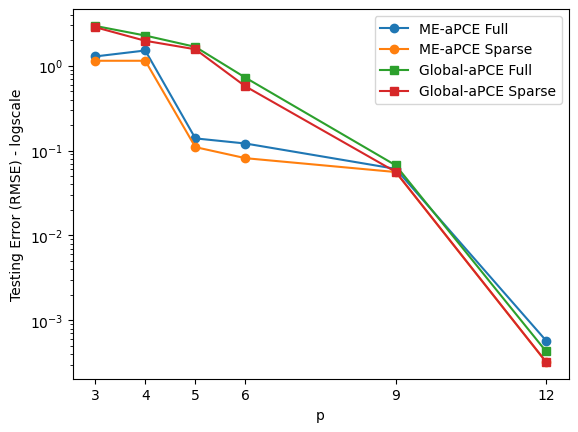

In [81]:
plt.plot(p, Error_AFVB_ME_aPCE_Full, '-o', label = 'ME-aPCE Full')
plt.plot(p, Error_AFVB_ME_aPCE_Sparse, '-o', label = 'ME-aPCE Sparse')
plt.plot(p, Error_AFVB_Global_aPCE_Full, '-s', label = 'Global-aPCE Full')
plt.plot(p, Error_AFVB_Global_aPCE_Sparse, '-s', label = 'Global-aPCE Sparse')
plt.xticks(p)
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("Testing Error (RMSE) - logscale")
plt.legend();

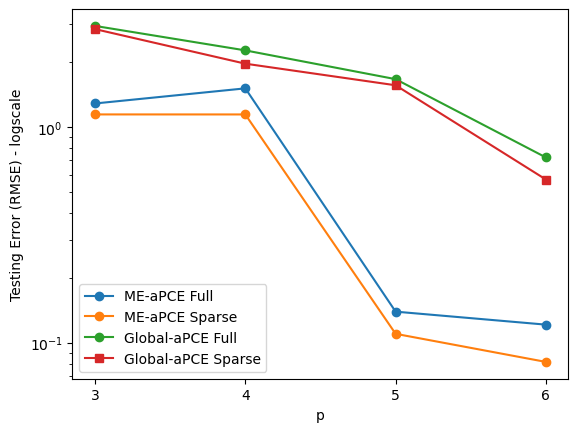

In [86]:
plt.plot(p[:4], Error_AFVB_ME_aPCE_Full[:4], '-o', label = 'ME-aPCE Full')
plt.plot(p[:4], Error_AFVB_ME_aPCE_Sparse[:4], '-o', label = 'ME-aPCE Sparse')
plt.plot(p[:4], Error_AFVB_Global_aPCE_Full[:4], '-o', label = 'Global-aPCE Full')
plt.plot(p[:4], Error_AFVB_Global_aPCE_Sparse[:4], '-s', label = 'Global-aPCE Sparse')
plt.xticks(range(3,7))
plt.yscale("log")
plt.xlabel("p")
plt.ylabel("Testing Error (RMSE) - logscale")
plt.legend();

## Optimizing hyperparameters for PCE

In [139]:
best_params_AFVB_ME_PCE = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], False, size_restriction = 25, B_split = None),
                                search_spaces = param_space_ME,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_ME_PCE.append(optimizer.best_params_)

91.02347344954809 min
100.26872749725977 min
147.9976473848025 min
125.91517752011617 min


In [143]:
alpha_AFVB_ME_PCE,A0_AFVB_ME_PCE,B0_AFVB_ME_PCE,C0_AFVB_ME_PCE,D0_AFVB_ME_PCE,theta1_AFVB_ME_PCE,theta2_AFVB_ME_PCE = parameter_values_ME(best_params_AFVB_ME_PCE, 4)


In [145]:
Error_AFVB_Global_PCE_Full = []
Error_AFVB_Global_PCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    temp = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], False, theta1_AFVB_ME_PCE[i], theta2_AFVB_ME_PCE[i], alpha_AFVB_ME_PCE[i], 25, None, A0_AFVB_ME_PCE[i], B0_AFVB_ME_PCE[i], C0_AFVB_ME_PCE[i], D0_AFVB_ME_PCE[i])
    temp.fit(X_train, Y_train)
    temp2 = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], True, theta1_AFVB_ME_PCE[i], theta2_AFVB_ME_PCE[i], alpha_AFVB_ME_PCE[i], 25, temp.B_split, A0_AFVB_ME_PCE[i], B0_AFVB_ME_PCE[i], C0_AFVB_ME_PCE[i], D0_AFVB_ME_PCE[i])
    temp2.fit(X_train, Y_train)
    Error_AFVB_Global_PCE_Full.append(np.sqrt(mean_squared_error(Y_test, temp.predict(X_test, sparse = False))))
    Error_AFVB_Global_PCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, temp2.predict(X_test, sparse = True))))


In [46]:
best_params_AFVB_Global_PCE = []

for i in range(len(p)):
    t0 = time.time()
    idx = multivariate_pce_index(d, p[i])
    
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, [B_init], Ishigami_Function, idx, AFVB_PCE, basis, 'PCE_Legendre', p[i], False, size_restriction = 25, B_split = np.array([B_init])),
                                search_spaces = param_space_AFVB,
                                n_iter = 30,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params_AFVB_Global_PCE.append(optimizer.best_params_)

10.809207916259766 min
12.860236267248789 min
15.303425749142965 min
18.994933915138244 min


In [102]:
A0_AFVB_Global_PCE, B0_AFVB_Global_PCE, C0_AFVB_Global_PCE, D0_AFVB_Global_PCE = parameter_values(best_params_AFVB_Global_PCE, 4)

In [82]:
Error_AFVB_Global_PCE_Full = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    
    AFVB_model = AFVB_PCE(basis, np.array(B_init),'PCE_Legendre', None, None, p[i], A0_AFVB_Global_PCE[i], B0_AFVB_Global_PCE[i], C0_AFVB_Global_PCE[i], D0_AFVB_Global_PCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_PCE_Full.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = False))))

In [83]:
Error_AFVB_Global_PCE_Sparse = []

for i in range(len(p)):
    idx = multivariate_pce_index(d, p[i])
    
    AFVB_model = AFVB_PCE(basis, np.array(B_init),'PCE_Legendre', None, None, p[i], A0_AFVB_Global_PCE[i], B0_AFVB_Global_PCE[i], C0_AFVB_Global_PCE[i], D0_AFVB_Global_PCE[i])
    AFVB_model.fit(X_train, Y_train)
    Error_AFVB_Global_PCE_Sparse.append(np.sqrt(mean_squared_error(Y_test, AFVB_model.predict(X_test, sparse = True))))

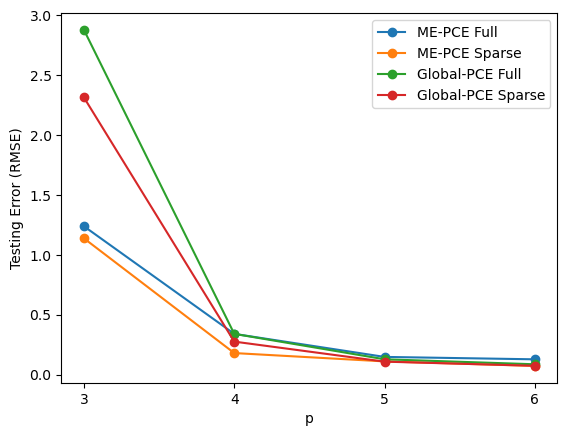

In [157]:
plt.plot(p, Error_MEaPCE_Full, '-o', label = 'ME-PCE Full')
plt.plot(p, Error_MEaPCE_Sparse, '-o', label = 'ME-PCE Sparse')
plt.plot(p, Error_AFVB_Global_PCE_Full, '-o', label = 'Global-PCE Full')
plt.plot(p, Error_AFVB_Global_PCE_Sparse, '-o', label = 'Global-PCE Sparse')
plt.xticks(p)
plt.xlabel("p")
plt.ylabel("Testing Error (RMSE)-logscale")
plt.legend();

In [64]:
best_params = []

for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], True, size_restriction = 25),
                                search_spaces = param_space,
                                n_iter = 10,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params.append(optimizer.best_params_)

53.34253256718318 min


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_v

65.0872655471166 min


In [65]:
best_params

[OrderedDict([('alpha', 0.20391206244448473),
              ('theta1', 0.6858732606158725),
              ('theta2', 0.2209684697392748)]),
 OrderedDict([('alpha', 0.3130196326711137),
              ('theta1', 0.8048727362391627),
              ('theta2', 0.15565739361085668)])]

In [70]:
theta1_aPCE_T = [0.69, 0.80]
theta2_aPCE_T = [0.22, 0.16]
alpha_aPCE_T = [0.20, 0.31]
error_aPCE_T = []

In [71]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p[i], True, theta1_aPCE_T[i], theta2_aPCE_T[i], alpha_aPCE_T[i], 25)
    ME_PCE_Ishigami.fit(X_train, Y_train)
    error_aPCE_T.append(np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test))))

In [66]:
best_params = []

for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], False, size_restriction = 25),
                                search_spaces = param_space,
                                n_iter = 10,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params.append(optimizer.best_params_)

39.435804001490276 min
47.60005807876587 min


In [67]:
best_params

[OrderedDict([('alpha', 0.3034680309980036),
              ('theta1', 0.446011507938946),
              ('theta2', 0.27483571983510474)]),
 OrderedDict([('alpha', 0.3539609193921903),
              ('theta1', 0.4574790101877664),
              ('theta2', 0.3899927325545569)])]

In [72]:
theta1_PCE_F = [0.45, 0.46]
theta2_PCE_F = [0.27, 0.39]
alpha_PCE_F = [0.30, 0.35]
error_PCE_F = []

In [73]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], False, theta1_PCE_F[i], theta2_PCE_F[i], alpha_PCE_F[i], 25)
    ME_PCE_Ishigami.fit(X_train, Y_train)
    error_PCE_F.append(np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test))))

In [68]:
best_params = []

for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    t0 = time.time()
    optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], True, size_restriction = 25),
                                search_spaces = param_space,
                                n_iter = 10,
                                scoring = 'neg_mean_squared_error',
                                cv = 5
    )

    optimizer.fit(X_train, Y_train)

    print((time.time()-t0)/60, 'min')
    
    best_params.append(optimizer.best_params_)

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: divide by zero encountered in scalar divide
  r_i = float(a

55.55139573415121 min


/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_v

59.875772635142006 min


In [69]:
best_params

[OrderedDict([('alpha', 0.8831283524160606),
              ('theta1', 0.019099222986992872),
              ('theta2', 0.7449926761649771)]),
 OrderedDict([('alpha', 0.19213422023327334),
              ('theta1', 0.7861319339683881),
              ('theta2', 0.830142078391273)])]

In [74]:
theta1_PCE_T = [0.02, 0.79]
theta2_PCE_T = [0.74, 0.83]
alpha_PCE_T = [0.88, 0.19]
error_PCE_T = []

In [75]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p[i], False, theta1_PCE_T[i], theta2_PCE_T[i], alpha_PCE_T[i], 25)
    ME_PCE_Ishigami.fit(X_train, Y_train)
    error_PCE_T.append(np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test))))

In [78]:
mod = aPCE(X_pol, p, idx) 
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [79]:
for i in range(2):
    idx = multivariate_pce_index(d, p[i])
    Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis, 'aPCE', mod, P, p[i]), idx)
    print(Error_AFVB_Ishigami)

In [ ]:
error_aPCE_Full = []
error_aPCE_Sparse = []

In [ ]:
for i in range(2);    
    Error_AFVB_Ishigami_PCE, GSA_AFVB_Ishigami_PCE, mod_AFVB_Ishigami_PCE, V_AFVB_Ishigami_PCE = Results(X_train, X_test, Y_train, Y_test, 
            AFVB_PCE(basis, 'PCE', mod, P, p[i]), idx)
    print(Error_AFVB_Ishigami_PCE)

In [ ]:
error_PCE_Full = []
error_PCE_Sparse = []

In [ ]:
# make errors to plot

In [ ]:
error_aPCE_Full = []
error_aPCE_Sparse = []

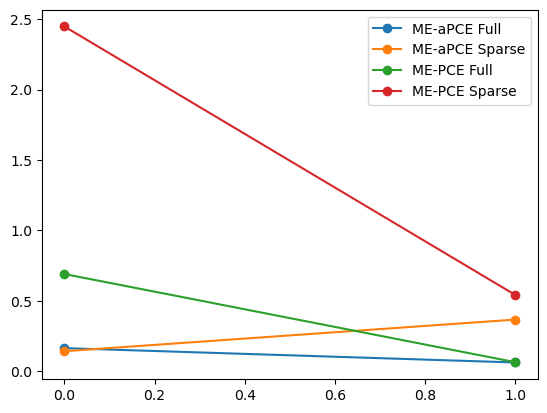

In [76]:
# label x-value as the p-values
plt.plot(error_aPCE_F, 'o-', label = 'ME-aPCE Full')
plt.plot(error_aPCE_T, 'o-', label = 'ME-aPCE Sparse')
plt.plot(error_PCE_F, 'o-', label = 'ME-PCE Full')
plt.plot(error_PCE_T, 'o-', label = 'ME-PCE Sparse')
#plt.plot(error_aPCE_Full, '.-', label = 'aPCE Full')
#plt.plot(error_aPCE_Sparse, '.-', label = 'aPCE Sparse')
#plt.plot(error_PCE_Full, '.-', label = 'PCE Full')
#plt.plot(error_PCE_Sparse, '.-', label = 'PCE Sparse')
plt.legend();

In [ ]:
### change the Legendre domain to the sub-domains as well

### VRVM

I still need to change the code from the VRVM class to accept the modified basis

In [22]:
mod = aPCE(X_pol, p, idx) 
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [23]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        SparseVariationalOptimizer(basis, 'PCE', mod, P, p), idx)

In [24]:
Error_AFVB_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,8,1.459842,1.461564,1.356184,1.356163,0.025421


In [23]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = ME_PCE(X_pol, B_init, Ishigami_Function, idx, SparseVariationalOptimizer, basis, 'PCE', p, True, size_restriction = 25),
                            search_spaces = param_space,
                            n_iter = 10,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print((time.time()-t0)/60, 'min')

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:103: RuntimeWarning: invalid value encountered in scalar divide
  eta_k = np.sum(a_vec[N_p_1:]**2)/np.sum(a_vec[1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:103: RuntimeWarning: invalid value encountered in scalar divide
  eta_k = np.sum(a_vec[N_p_1:]**2)/np.sum(a_vec[1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:113: RuntimeWarning: invalid value encountered in scalar divide
  r_i = float(a_vec[np.nonzero(np.sum(self.idx == l, 1) == self.d)])**2/np.sum(a_vec[N_p_1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/ME_PCE.py:103: RuntimeWarning: invalid value encountered in scalar divide
  eta_k = np.sum(a_vec[N_p_1:]**2)/np.sum(a_vec[1:]**2)
/Users/chave/CUDenver_Thesis/CUDenver-Thesi

KeyboardInterrupt: 

In [33]:
mod_AFVB_Ishigami.a_full[mod_AFVB_Ishigami.active_cols].shape

(8,)

## Models and Errors

In [90]:
B_init = [[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]]

In [93]:
theta1 = [0.9, 0.01, 0.001, 0.0001]
theta2 = [0.9, 0.01, 0.001, 0.0001]
alpha = [0.1, 0.5, 0.9]

In [45]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(B_init, Ishigami_Function, idx, AFVB_PCE, basis_Ishigami, 'aPCE', p, sparse = False)
            ME_PCE_Ishigami.fit(X_train, X_pol, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 1.576894845265857 [0.9, 0.9, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.9, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.9, 0.9] B_shape = 1
Error = 1.576894845265857 [0.9, 0.01, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.01, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.01, 0.9] B_shape = 1
Error = 1.576894845265857 [0.9, 0.001, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.001, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.001, 0.9] B_shape = 1
Error = 1.576894845265857 [0.9, 0.0001, 0.1] B_shape = 1
Error = 1.576894845265857 [0.9, 0.0001, 0.5] B_shape = 1
Error = 1.576894845265857 [0.9, 0.0001, 0.9] B_shape = 1
Error = 0.4570825241610843 [0.01, 0.9, 0.1] B_shape = 8
Error = 0.4570825241610843 [0.01, 0.9, 0.5] B_shape = 8
Error = 0.4570825241610843 [0.01, 0.9, 0.9] B_shape = 8
Error = 1.9330960022697807 [0.01, 0.01, 0.1] B_shape = 2
Error = 1.9330960022697807 [0.01, 0.01, 0.5] B_shape = 2
Error = 1.9330960022697807 [0.01, 0.01, 0.9] B_shape

In [ ]:
X_pol, B_init, fun, idx, alg_mod, basis, PCE_method, p = 5, sparse = True, theta1 = 0.001, theta2 = 0.01, alpha = 1/2, size_restriction = 25

In [94]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p, True, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            ME_PCE_Ishigami.fit(X_train, Y_train)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 1.5590055025581158 [0.9, 0.9, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.9, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.9, 0.9] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.01, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.01, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.01, 0.9] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.001, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.001, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.001, 0.9] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.0001, 0.1] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.0001, 0.5] B_shape = 1
Error = 1.5590055025581158 [0.9, 0.0001, 0.9] B_shape = 1
Error = 0.14634206301739172 [0.01, 0.9, 0.1] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.9, 0.5] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.9, 0.9] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.01, 0.1] B_shape = 8
Error = 0.14634206301739172 [0.01, 0.01, 0.5] B_shape = 8
Error = 0.14634206301739172 [0.01, 

In [75]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p, False, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            ME_PCE_Ishigami.fit(X_train, Y_train)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 0.6217471418279746 [0.1, 0.1, 0.1] B_shape = 7
Error = 0.5315668276358553 [0.1, 0.1, 0.5] B_shape = 3
Error = 0.4954049447467795 [0.1, 0.1, 0.9] B_shape = 2
Error = 0.6184937226229411 [0.1, 0.01, 0.1] B_shape = 6
Error = 0.46335189018711737 [0.1, 0.01, 0.5] B_shape = 4
Error = 0.46335189018711737 [0.1, 0.01, 0.9] B_shape = 4
Error = 0.6162870553914445 [0.1, 0.001, 0.1] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.001, 0.5] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.001, 0.9] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.0001, 0.1] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.0001, 0.5] B_shape = 8
Error = 0.6162870553914445 [0.1, 0.0001, 0.9] B_shape = 8
Error = 0.6217471418279746 [0.01, 0.1, 0.1] B_shape = 7
Error = 0.6217471418279746 [0.01, 0.1, 0.5] B_shape = 7
Error = 0.621096594138337 [0.01, 0.1, 0.9] B_shape = 5
Error = 0.6184937226229411 [0.01, 0.01, 0.1] B_shape = 6
Error = 0.6184937226229411 [0.01, 0.01, 0.5] B_shape = 6
Error = 0.6184937226229411 [0.01, 0.01,

KeyboardInterrupt: 

In [74]:
for i in range(4):
    for j in range(4):
        for k in range(3):
            ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'PCE', p, True, theta1 = theta1[i], theta2 = theta2[j], alpha = alpha[k], size_restriction = 25)
            ME_PCE_Ishigami.fit(X_train, Y_train)
            error = np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))
            print('Error =', error, [theta1[i], theta2[j], alpha[k]], 'B_shape =', ME_PCE_Ishigami.B_split.shape[0])

Error = 0.68430378437914 [0.1, 0.1, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.1, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.1, 0.9] B_shape = 8
Error = 0.68430378437914 [0.1, 0.01, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.01, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.01, 0.9] B_shape = 8
Error = 0.68430378437914 [0.1, 0.001, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.001, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.001, 0.9] B_shape = 8
Error = 0.68430378437914 [0.1, 0.0001, 0.1] B_shape = 8
Error = 0.68430378437914 [0.1, 0.0001, 0.5] B_shape = 8
Error = 0.68430378437914 [0.1, 0.0001, 0.9] B_shape = 8
Error = 0.68430378437914 [0.01, 0.1, 0.1] B_shape = 8
Error = 0.68430378437914 [0.01, 0.1, 0.5] B_shape = 8
Error = 0.68430378437914 [0.01, 0.1, 0.9] B_shape = 8
Error = 0.68430378437914 [0.01, 0.01, 0.1] B_shape = 8
Error = 0.68430378437914 [0.01, 0.01, 0.5] B_shape = 8
Error = 0.68430378437914 [0.01, 0.01, 0.9] B_shape = 8
Error = 0.684303784

In [33]:
mod = aPCE(X_pol, p, idx) 
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [47]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis, 'aPCE', mod, P, p), idx)

In [48]:
Error_AFVB_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,9,1.317248,1.438414,1.62913,1.456254,0.017873


In [23]:
ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, SparseVariationalOptimizer, basis, 'aPCE', p, False, 0.0001, 0.9, 1/2, 25)
ME_PCE_Ishigami.fit(X_train, Y_train)

In [24]:
### Error
np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))

0.1701655430832387

In [25]:
ME_PCE_Ishigami = ME_PCE(X_pol, B_init, Ishigami_Function, idx, AFVB_PCE, basis, 'aPCE', p, True, 0.0001, 0.9, 1/2, 25)
ME_PCE_Ishigami.fit(X_train, Y_train)

In [26]:
### Error
np.sqrt(mean_squared_error(Ishigami_Function(X_test), ME_PCE_Ishigami.predict(X_test)))

0.12340794028367318

In [10]:
def split_data(X, B_k):
    'X: data to split'
    'B_k: domains, needs to be an array of size d x 2'
    B_k = np.array(B_k)
    
    N = X.shape[0]
    d = X.shape[1]
    X_k = []
    
    for i in range(N):
        if np.sum((B_k[:,0] <= X[i]) & (X[i] <= B_k[:,1])) == 3:
            X_k.append(list(X[i]))
    return np.c_[np.array(X_k)]

In [11]:
#mod_alg = AFVB_PCE
mod_alg = AFVB_PCE

In [12]:
Ishigami_Function = tf.ishigami

In [16]:
idx = multivariate_pce_index(3, 5)

In [17]:
theta1 = 0.00001
theta2 = 0.9
alpha = 1
p=5

B = [[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]]
#B = [[[-np.pi, 0], [-np.pi, np.pi], [-np.pi, np.pi]],[[0, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]]]

for j in range(5):
    B_k = []
    for k in range(len(B)):
        
        X_p = split_data(X_pol, np.array(B[k]))
        X_t = split_data(X_train, np.array(B[k]))
        Y_t = Ishigami_Function(X_t)

        mod = aPCE(X_p, p) 
        P = mod.Create_Orthonormal_Polynomials(p)

        model = mod_alg('aPCE', d, p = 5, domain = np.array(B[k]), aPCE_model = mod, P = P).fit(X_t, Y_t.reshape(X_t.shape[0]))

        # For each random element k, calculate eta_k and J_k
        N_p_1 = int(math.factorial(d + p-1)/(math.factorial(d)*math.factorial(p-1)))
        eta_k = np.sum(model.a_full[N_p_1:]**2)/np.sum(model.a_full[1:]**2) 
        J_k = 1
        
        for i in range(d):
            J_k *= (B[k][i][1] - B[k][i][0])/(2*np.pi)
        
        r = []
        for i in range(d):
            l = [0]*d
            l[i] = p
            r_i = float(model.a_full[np.nonzero(np.sum(idx == l, 1) == d)])**2/np.sum(model.a_full[N_p_1:]**2)
            r.append(r_i)

        if (eta_k**alpha*J_k >= theta1) & (X_t.shape[0]/2**np.sum(theta2*np.max(r)<=r) >= 25):
        #if (eta_k**alpha*J_k >= theta1): # If this isn't true then we don't split up B_k
            print('Splitting', 'time =', j)
        
            B_temp = []
            print(theta2*np.max(r)<=r, 'k =', k)
            
            for i in range(d):
                if (theta2*np.max(r)<=r[i]):
                    B_temp.append([[B[k][i][0], B[k][i][0] + (B[k][i][1]-B[k][i][0])/2], [B[k][i][0] + (B[k][i][1]-B[k][i][0])/2, B[k][i][1]]])
                else:
                    B_temp.append([B[k][i], B[k][i]])
                    
            for i in range(d):
                if (theta2*np.max(r)<=r[i]):
                    T_p = i
                    break

            B_new = []
            
            T_position = 0
            # Fill B_new with the first element
            if (theta2*np.max(r)<=r[0]):
                for m in range(int(2**(i+1)/2**T_p)):
                    for l in range(int(2**np.sum((theta2*np.max(r)<=r))/(2**(i+1)/2**T_p))):
                        B_new.append([B_temp[0][m%2]])
            else:
                for l in range(int(2**np.sum((theta2*np.max(r)<=r)))):
                    B_new.append([B_temp[0][0]])
            
            # Fill in for the rest of the elements
            for i in range(1,d):
                t = 0
                if (theta2*np.max(r)<=r[i]):
                    for m in range(int(len(B_new)/2**T_position)):
                        for l in range(int(2**T_position)):
                            B_new[t].append(B_temp[i][m%2])
                            t += 1
                    T_position += 1
                else:
                    for l in range(int(2**np.sum((theta2*np.max(r)<=r)))):
                        B_new[t].append(B_temp[i][0])
                        t += 1
            #print(B_new)
            B_k = B_k+B_new

        else:
            print('Not Splitting', 'time =', j, 'k =', k)
            B_new = B[k]
            #print(B_k)
            B_k = B_k+[B_new]
            #print(B_new)
        
    if B == B_k:
        break
    B = B_k.copy()

print(len(B))

Splitting time = 0
[ True False False] k = 0
Splitting time = 1
[False  True  True] k = 0
Splitting time = 1
[False False  True] k = 1
Not Splitting time = 2 k = 0
Not Splitting time = 2 k = 1
Not Splitting time = 2 k = 2
Not Splitting time = 2 k = 3
Splitting time = 2
[False False  True] k = 4
Splitting time = 2
[False False  True] k = 5
Not Splitting time = 3 k = 0
Not Splitting time = 3 k = 1
Not Splitting time = 3 k = 2
Not Splitting time = 3 k = 3
Not Splitting time = 3 k = 4
Not Splitting time = 3 k = 5
Not Splitting time = 3 k = 6
Not Splitting time = 3 k = 7
8


In [18]:
B

[[[-3.141592653589793, 0.0],
  [-3.141592653589793, 0.0],
  [-3.141592653589793, 0.0]],
 [[-3.141592653589793, 0.0],
  [0.0, 3.141592653589793],
  [-3.141592653589793, 0.0]],
 [[-3.141592653589793, 0.0],
  [-3.141592653589793, 0.0],
  [0.0, 3.141592653589793]],
 [[-3.141592653589793, 0.0],
  [0.0, 3.141592653589793],
  [0.0, 3.141592653589793]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [-3.141592653589793, -1.5707963267948966]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [-1.5707963267948966, 0.0]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [0.0, 1.5707963267948966]],
 [[0.0, 3.141592653589793],
  [-3.141592653589793, 3.141592653589793],
  [1.5707963267948966, 3.141592653589793]]]

In [37]:
model_local = []
P_local = []

for k in range(len(ME_PCE_Ishigami.B_split)):
    X_p = split_data(X_pol, ME_PCE_Ishigami.B_split[k])
    X_t = split_data(X_train, ME_PCE_Ishigami.B_split[k])
    print(X_t.shape[0], 'k =', k)
    Y_t = Ishigami_Function(X_t)

    mod = aPCE(X_p, p, idx) 
    P = mod.Create_Orthonormal_Polynomials(p)
    P_local.append(P)

    model = AFVB_PCE(basis_Ishigami, p, 'aPCE', mod).fit(X_t, Y_t.reshape(X_t.shape[0]))
    model_local.append(model)

36 k = 0


KeyboardInterrupt: 

In [40]:
ME_PCE_Ishigami.model_local[0].a_hat

array([[ 1.65297329],
       [ 1.4298195 ],
       [-0.77621001],
       [ 0.22091013],
       [-2.34657485],
       [ 0.73692121],
       [ 0.90691979],
       [-0.69464622],
       [ 0.34050717],
       [-0.08819909]])

In [51]:
for i in range(8):
    print(ME_PCE_Ishigami.model_local[i].a_hat.shape[0])

10
10
12
12
11
10
7
8


In [187]:
Y = np.zeros(X_test.shape[0])
for j in range(Y.shape[0]):
    for i in range(len(B)):
        if np.sum((B[i][:,0] <= X_test[j]) & (X_test[j] <= B[i][:,1])) == 3:
            P = P_local[i]
            Y[j] += model_local[i].predict(X_test[j:j+1], sparse = False)

In [188]:
np.mean(Y)

3.3701823162495956

In [189]:
np.mean(Y_test)

3.3668301094001913

In [190]:
Y

array([ 2.12471097,  4.66306677,  5.08999945,  4.81747481,  1.3560535 ,
        8.5873004 ,  4.27008071,  1.73107471,  0.4368262 ,  0.38627996,
       -0.18254094,  0.17417955, -0.6290512 ,  3.65345499,  6.17233814,
        2.6394742 ,  5.8056285 ,  6.0873554 ,  1.0797263 , -3.05958684,
        2.12833919, -0.87042245,  7.07830351,  4.43888587, -1.35093215,
        5.85243489,  0.57523994,  0.19259811,  2.35325694,  0.8659558 ,
        6.71474008,  2.45894378,  5.4207165 ,  5.04401748,  7.41365467,
       -0.25837579,  1.06920471,  2.53144419, 13.94664161,  2.73922832,
        1.79926854,  5.64893275,  0.78159136,  2.73629155, -0.15851717,
       -1.186637  ,  3.98914363,  1.07597987, -4.09818023,  0.60189927,
        4.80654461,  3.47091221,  1.95635804,  6.9928035 ,  6.60230875,
        4.09555402,  3.98139598,  7.9623679 ,  2.24227132,  3.85273761,
        4.03212749,  9.70053148,  1.30134139,  2.33052246,  7.86691852,
        2.04182525,  3.00236042,  1.28556896,  6.01835861,  5.98

In [27]:
ME_PCE_Ishigami.predict(X_test)

NameError: name 'ME_PCE_Ishigami' is not defined

In [191]:
### Error
np.sqrt(mean_squared_error(Ishigami_Function(X_test), Y))

0.17609461609535684

In [192]:
local_mean = 0
for i in range(B.shape[0]):
    local_mean += model_local[i].a_full[0]
    #print(model_local[i].a_hat[0])
local_mean/B.shape[0]

array([3.77799745])

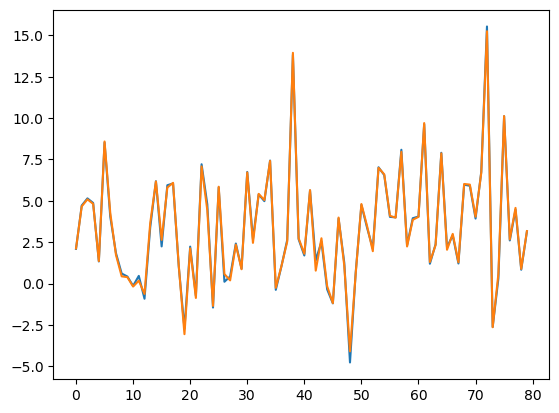

In [193]:
plt.plot(Ishigami_Function(X_test))
plt.plot(Y)

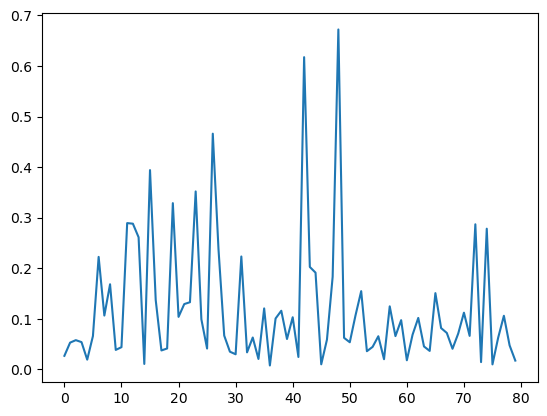

In [194]:
plt.plot(np.abs(Ishigami_Function(X_test)-Y.reshape(X_test.shape[0], 1)))

In [195]:
X_check = X_test[np.where(np.abs(Ishigami_Function(X_test)-Y.reshape(X_test.shape[0], 1))>=1)[0],:]

In [196]:
X_check

array([], shape=(0, 3), dtype=float64)

In [176]:
for i in range(len(B)):
    for j in range(X_check.shape[0]):
        if np.sum((B[i][:,0] <= X_check[j]) & (X_check[j] <= B[i][:,1])) == 3:
            print(i)

In [177]:
B[0]

array([[-3.14159265,  0.        ],
       [-3.14159265,  0.        ],
       [-3.14159265,  3.14159265]])

In [20]:
### comparing with other model
mod = aPCE(X_pol, p, idx) #changed to X_train
P = mod.Create_Orthonormal_Polynomials(p)

In [32]:
mod.Pol_eval(P[0][idx[0][1]],2)

1.0

In [ ]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_Ishigami, 'aPCE', mod, p), idx)

In [ ]:
Error_AFVB_Ishigami

In [27]:
Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_Ishigami, 'PCE', mod, p), idx)

In [28]:
Error_AFVB_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,8,1.354843,1.450074,1.473719,1.460269,0.017714


In [22]:
Error_VRVM_Ishigami, GSA_VRVM_Ishigami, mod_VRVM_Ishigami, V_VRVM_Ishigami = Results(X_train, X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_Ishigami, p), idx)

TypeError: basis_Ishigami() missing 1 required positional argument: 'method'

In [179]:
Error_VRVM_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,7,3.035623,3.050702,3.103694,3.050476,0.01934


In [112]:
A_0 = 0.07700
B_0 = 0.01653
C_0 = 0.04678
D_0 = 0.01422

Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [113]:
Error_AFVB_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,100000,11,0.386049,0.464838,0.794671,0.584777,0.022354


## AFVB

### Parameter Optimization

In [71]:
param_space = {'A_0': skopt.space.Real(0.000001, 0.1),
              'B_0': skopt.space.Real(0.000001, 0.1),
              'C_0': skopt.space.Real(0.000001, 0.1),
              'D_0': skopt.space.Real(0.000001, 0.1)
         }

t0 = time.time()
optimizer = BayesSearchCV(estimator = AFVB_PCE(basis = basis_aPCE, p = p),
                            search_spaces = param_space,
                            n_iter = 30,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print(time.time()-t0)

ValueError: math domain error

In [48]:
optimizer.best_params_

OrderedDict([('A_0', 0.07700216442475019),
             ('B_0', 0.016529139107592992),
             ('C_0', 0.046777431074088646),
             ('D_0', 0.014223674556344384)])

In [49]:
524/60/60

0.14555555555555555

In [38]:
# Best parameters based on CV for p = 12: 
#{'A_0': 0.1, 'B_0': 1e-05, 'C_0' =  0.1, 'D_0': 0.1}
A_0 = 0.07700
B_0 = 0.01653
C_0 = 0.04678
D_0 = 0.01422

Error_AFVB_Ishigami, GSA_AFVB_Ishigami, mod_AFVB_Ishigami, V_AFVB_Ishigami = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [39]:
Error_AFVB_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,22,0.000375,0.002591,0.00463,0.002943,0.526461


In [40]:
GSA_AFVB_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.340421,7.711965,0.313710,0.557394
1,6.123795,6.123795,0.442606,0.442606
2,0.000000,3.371544,0.000000,0.243683


In [41]:
GSA_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.345888,7.719588,0.313905,0.557589
1,6.125000,6.125000,0.442411,0.442411
2,0.000000,3.373700,0.000000,0.243684


In [42]:
# Best parameters based on CV for p = 12: 
#{'A_0': 0.1, 'B_0': 1e-05, 'C_0' =  0.1, 'D_0': 0.1}
A_0 = 0.07700
B_0 = 0.01653
C_0 = 0.04678
D_0 = 0.01422

Error_AFVB_Ishigami_S, GSA_AFVB_Ishigami_S, mod_AFVB_Ishigami_S, V_AFVB_Ishigami_S = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_aPCE_Stieltjes, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [43]:
Error_AFVB_Ishigami_S

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,22,0.000375,0.002591,0.00463,0.002943,0.552552


In [44]:
GSA_AFVB_Ishigami_S

,Partial Variance,Total Variance,1st Order,Total Order
0,4.340421,7.711965,0.313710,0.557394
1,6.123795,6.123795,0.442606,0.442606
2,0.000000,3.371544,0.000000,0.243683


In [45]:
GSA_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.345888,7.719588,0.313905,0.557589
1,6.125000,6.125000,0.442411,0.442411
2,0.000000,3.373700,0.000000,0.243684


In [423]:
idx[mod_AFVB_Ishigami.active_cols]

array([[ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  2,  0],
       [ 0,  4,  0],
       [ 0,  6,  0],
       [ 0,  8,  0],
       [ 0, 10,  0],
       [ 0, 12,  0],
       [ 1,  0,  0],
       [ 1,  0,  1],
       [ 1,  0,  2],
       [ 1,  0,  4],
       [ 2,  0,  0],
       [ 2,  0,  2],
       [ 3,  0,  0],
       [ 3,  0,  1],
       [ 3,  0,  2],
       [ 3,  0,  4],
       [ 5,  0,  0],
       [ 5,  0,  2],
       [ 5,  0,  4],
       [ 7,  0,  0],
       [ 7,  0,  2],
       [ 7,  0,  4]])

In [424]:
mod_AFVB_Ishigami.a_hat

array([[ 3.49872328e+00],
       [ 2.38525501e-03],
       [-5.97833203e-01],
       [-1.94703220e+00],
       [ 1.35698960e+00],
       [-3.38892256e-01],
       [ 4.58763024e-02],
       [-3.82986350e-03],
       [ 1.63617333e+00],
       [-4.34994622e-03],
       [ 1.37952630e+00],
       [ 4.10803310e-01],
       [-6.72496244e-03],
       [-5.56399669e-03],
       [-1.29456348e+00],
       [ 2.97279036e-03],
       [-1.09144844e+00],
       [-3.24881090e-01],
       [ 1.95250501e-01],
       [ 1.64101525e-01],
       [ 4.85782676e-02],
       [-1.23883771e-02],
       [-1.00559923e-02],
       [-2.57801434e-03]])

In [30]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = AFVB_PCE(basis = basis_PCE_Ishigami, p = p),
                            search_spaces = param_space,
                            n_iter = 50,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print(time.time()-t0)

1894.849053144455


In [31]:
optimizer.best_params_

OrderedDict([('A_0', 0.05428989456568009),
             ('B_0', 0.01834506550270264),
             ('C_0', 0.02201029030700765),
             ('D_0', 0.0015529842047863562)])

In [471]:
# Best parameters based on CV for p = 12: 
# These were based on 320 training data points
# {'A_0': 0.1, 'B_0': 1e-05, 'C_0' =  1e-05, 'D_0': 0.1} 
A_0 = 0.05429
B_0 = 0.01835
C_0 = 0.02201
D_0 = 0.00155

Error_AFVB_PCE_Ishigami, GSA_AFVB_PCE_Ishigami, mod_AFVB_PCE_Ishigami, V_AFVB_PCE_Ishigami = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_PCE_Ishigami, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [472]:
Error_AFVB_PCE_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,19,0.00029,0.000626,0.000783,0.000677,0.449014


In [473]:
GSA_AFVB_PCE_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.345752,7.719416,0.313904,0.557592
1,6.124790,6.124790,0.442408,0.442408
2,0.000000,3.373664,0.000000,0.243688


In [474]:
GSA_Ishigami

,Partial Variance,Total Variance,1st Order,Total Order
0,4.345888,7.719588,0.313905,0.557589
1,6.125000,6.125000,0.442411,0.442411
2,0.000000,3.373700,0.000000,0.243684


In [426]:
Error_AFVB_PCE_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,19,0.000307,0.000647,0.000945,0.00063,0.475238


In [427]:
idx[mod_AFVB_PCE_Ishigami.active_cols]

array([[ 0,  0,  0],
       [ 0,  2,  0],
       [ 0,  4,  0],
       [ 0,  6,  0],
       [ 0,  8,  0],
       [ 0, 10,  0],
       [ 0, 12,  0],
       [ 1,  0,  0],
       [ 1,  0,  2],
       [ 1,  0,  4],
       [ 3,  0,  0],
       [ 3,  0,  2],
       [ 3,  0,  4],
       [ 5,  0,  0],
       [ 5,  0,  2],
       [ 5,  0,  4],
       [ 7,  0,  0],
       [ 7,  0,  2],
       [ 7,  0,  4]])

In [428]:
mod_AFVB_PCE_Ishigami.a_hat

array([[ 3.49997552e+00],
       [-5.94758074e-01],
       [-1.95227290e+00],
       [ 1.35740954e+00],
       [-3.39352909e-01],
       [ 4.59292673e-02],
       [-3.82851205e-03],
       [ 1.62543858e+00],
       [ 1.37246761e+00],
       [ 4.09254282e-01],
       [-1.29071142e+00],
       [-1.08981270e+00],
       [-3.24946791e-01],
       [ 1.94899570e-01],
       [ 1.64586074e-01],
       [ 4.90202940e-02],
       [-1.25608734e-02],
       [-1.05074850e-02],
       [-2.94910094e-03]])

## VRVM

In [36]:
param_space = {'omega_a': skopt.space.Real(0.000001, 0.1),
              'omega_b': skopt.space.Real(0.000001, 0.1),
              'tau_a': skopt.space.Real(0.000001, 0.1),
              'tau_b': skopt.space.Real(0.000001, 0.1)
         }

In [39]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = SparseVariationalOptimizer(basis = basis_aPCE, p = p),
                            search_spaces = param_space,
                            n_iter = 50,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(data['xi'], data['y'])

print(time.time()-t0)

/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2961.5630259513855


In [40]:
optimizer.best_params_

OrderedDict([('omega_a', 0.028509534536848024),
             ('omega_b', 0.04281103620572389),
             ('tau_a', 0.04277575729693283),
             ('tau_b', 0.03615238968778503)])

In [52]:
Error_VRVM_Ishigami, GSA_VRVM_Ishigami, mod_VRVM_Ishigami, V_VRVM_Ishigami = Results(data['xi'], X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_aPCE, p, 0.02851, 0.04281, 0.04278, 0.03615, 0.2, 1.0), idx)

In [53]:
Error_VRVM_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,15,0.043304,0.014534,0.024371,0.018338,0.217324


In [54]:
Error_VRVM_Ishigami_S, GSA_VRVM_Ishigami_S, mod_VRVM_Ishigami_S, V_VRVM_Ishigami_S = Results(data['xi'], X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_aPCE_Stieltjes, p, 0.02851, 0.04281, 0.04278, 0.03615, 0.2, 1.0), idx)

In [55]:
Error_VRVM_Ishigami_S

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,15,0.043304,0.014534,0.024371,0.018338,0.21241


In [43]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = SparseVariationalOptimizer(basis = basis_PCE_Ishigami, p = p),
                            search_spaces = param_space,
                            n_iter = 50,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(data['xi'], data['y'])

print(time.time()-t0)

/Users/chave/anaconda3/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2637.820358991623


In [44]:
optimizer.best_params_

OrderedDict([('omega_a', 0.04540549874364945),
             ('omega_b', 0.054319259205855515),
             ('tau_a', 0.08302439423042468),
             ('tau_b', 0.04462844667792927)])

In [477]:
Error_VRVM_PCE_Ishigami, GSA_VRVM_PCE_Ishigami, mod_VRVM_PCE_Ishigami, V_VRVM_PCE_Ishigami = Results(data['xi'], X_test, Y_train, Y_test, 
        SparseVariationalOptimizer(basis_PCE_Ishigami, p, 0.04541, 0.05432, 0.08302, 0.04463, 0.2, 1.0), idx)

In [478]:
Error_VRVM_PCE_Ishigami

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,15,0.048921,0.015601,0.016979,0.014962,0.19544


# Plots: Ishigami Function

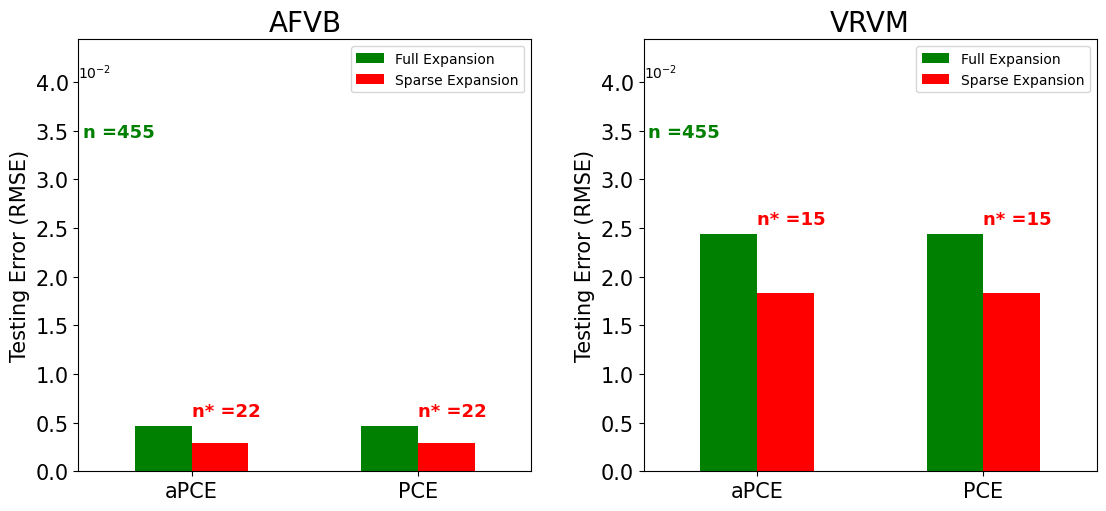

In [56]:
plot_Error(Error_AFVB_Ishigami, Error_AFVB_Ishigami_S, 
           Error_VRVM_Ishigami, Error_VRVM_Ishigami_S,
           100, '$10^{-2}$', mod_AFVB_Ishigami.n)
#plt.savefig(wd + '/RMSE_Ishigami.png')

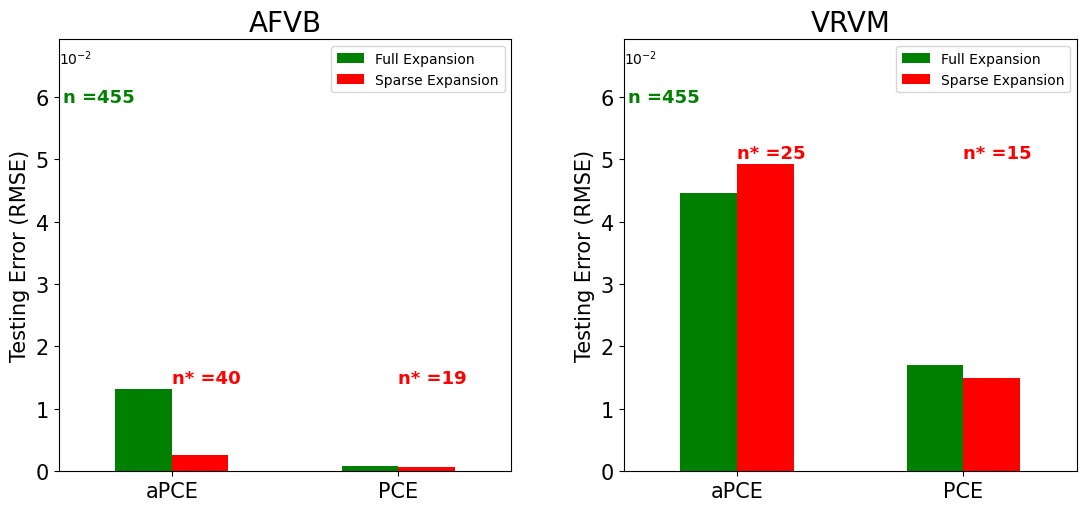

In [479]:
plot_Error(Error_AFVB_Ishigami, Error_AFVB_PCE_Ishigami, 
           Error_VRVM_Ishigami, Error_VRVM_PCE_Ishigami,
           100, '$10^{-2}$', mod_AFVB_Ishigami.n)
#plt.savefig(wd + '/RMSE_Ishigami.png')

# Activity Scores

In [352]:
def Activity_Scores(M, d, grad_fun):
    
    grad = grad_fun(X)
    C = np.zeros((d,d))
    
    for i in range(M):
        grad_i = grad[:,i].reshape((d,1))
        C += 1/M*grad_i@grad_i.T
        
    lam, W = np.linalg.eig(C)
    
    lam_sort = np.sort(lam)[::-1]
    W_sort = W[:,np.argsort(lam)[::-1]]
    
    for i in range(d):
        W_sort[:,i] = np.sign(W_sort[0,i])*W_sort[:,i]
    
    gap_list = np.zeros(d-1)
    for i in range(d-1):
        gap_list[i] = lam_sort[i] - lam_sort[i+1]
    gap_max = np.argmax(gap_list)
    
    alpha = np.zeros(d)
    for i in range(d):
        alpha[i] = np.sum(lam_sort[0:gap_max+1]*W_sort[i,0:gap_max+1]**2)
        
    return W_sort, lam_sort, alpha

In [353]:
def Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B):
    v1 = ((12*R_b2/(R_b1+R_b2) + 0.74)*B*(R_c2 + 9))/(B*(R_c2 + 9) + R_f)
    v2 = 11.35*R_f/(B*(R_c2 + 9) + R_f)
    v3 = 0.74*R_f*B*(R_c2 + 9)/((B*(R_c2 + 9) + R_f)*R_c1)
    return v1+v2+v3

R_b1, R_b2, R_f, R_c1, R_c2, B = symbols('R_b1 R_b2 R_f R_c1 R_c2 B')

V_Rb1 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_b1))
V_Rb2 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_b2))
V_Rf = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_f))
V_Rc1 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_c1))
V_Rc2 = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), R_c2))
V_B = lambdify([R_b1, R_b2, R_f, R_c1, R_c2, B], diff(Circuit(R_b1, R_b2, R_f, R_c1, R_c2, B), B))

def grad_Circuit(X):
    
    a_min = [50, 25, 0.5, 1.2, 0.25, 50]
    b_min = [150, 70, 3.0, 2.5, 1.2, 300]
    
    M = X.shape[0]
    d = X.shape[1]
    
    # scale to [a,b]
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    
    # derivative and scale back to [-1,1]
    grad_f = np.zeros((d,M))
    grad_f[0,:] = V_Rb1(x1, x2, x3, x4, x5, x6)*0.5*(b_min[0] - a_min[0])
    grad_f[1,:] = V_Rb2(x1, x2, x3, x4, x5, x6)*0.5*(b_min[1] - a_min[1])
    grad_f[2,:] = V_Rf(x1, x2, x3, x4, x5, x6)*0.5*(b_min[2] - a_min[2])
    grad_f[3,:] = V_Rc1(x1, x2, x3, x4, x5, x6)*0.5*(b_min[3] - a_min[3])
    grad_f[4,:] = V_Rc2(x1, x2, x3, x4, x5, x6)*0.5*(b_min[4] - a_min[4])
    grad_f[5,:] = V_B(x1, x2, x3, x4, x5, x6)*0.5*(b_min[5] - a_min[5])
    
    return grad_f

In [354]:
M = 10000
X = np.random.uniform(-1, 1, (M, 6))
W, lam, alpha = Activity_Scores(M, 6, grad_Circuit)

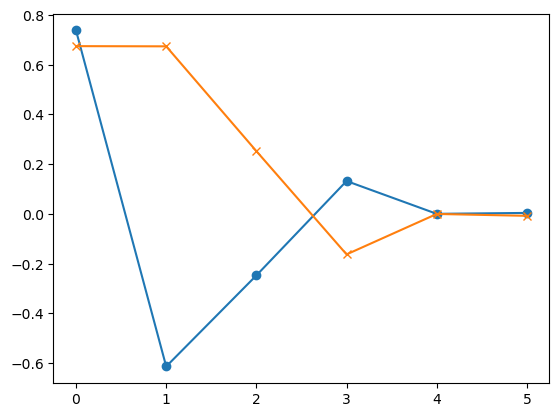

In [355]:
plt.plot(W[:,0],'o-')
plt.plot(W[:,1],'x-');

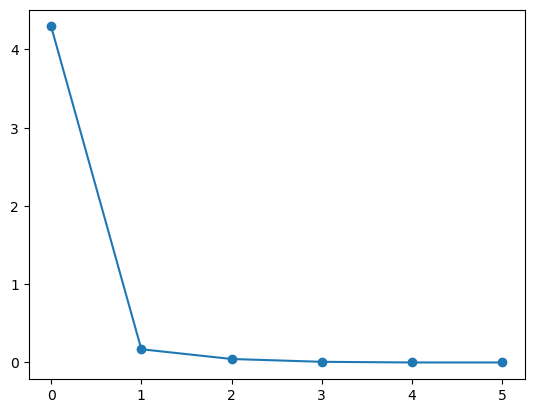

In [356]:
plt.plot(lam,'o-');

In [357]:
alpha

array([2.33696375e+00, 1.61803575e+00, 2.63093558e-01, 7.49293476e-02,
       1.14805546e-07, 6.40140108e-05])

### Ishigami Function

In [358]:
def grad_Ishigami(X):
    'Assuming X~U(-1,1)'
    
    M = X.shape[0]
    d = X.shape[1]
    
    a_min = [-np.pi]*3
    b_min = [np.pi]*3
    
    # change to [-pi,pi]
    x1 = 1/2*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 1/2*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 1/2*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    
    # Derivative and change back to [-1,1]
    grad_f = np.zeros((d, M))
    grad_f[0,:] = (np.cos(x1) + 0.1*x3**4*np.cos(x1))*0.5*(b_min[0] - a_min[0])
    grad_f[1,:] = (14*np.sin(x2)*np.cos(x2))*0.5*(b_min[1] - a_min[1])
    grad_f[2,:] = (0.4*x3**3*np.sin(x1))*0.5*(b_min[2] - a_min[2])
    
    return grad_f

In [390]:
M = 10000
X = np.random.uniform(-1, 1, (M, 3))
W_Ishigami, lam_Ishigami, alpha_Ishigami = Activity_Scores(M, 3, grad_Ishigami)

In [391]:
alpha_Ishigami

array([7.58037373e-02, 2.41776054e+02, 1.64051178e-03])

### aPCE

In [392]:
def Pol_eval(coeff, x):
    """
    Evaluates a polynomial at the value x.
    Polynomial is assumed to be in the form: c_0 + c_1*x + ... + c_n*x^n

    """

    val = 0
    for i in range(coeff.shape[0]):
        val += coeff[i]*x**i

    return val

In [393]:
def grad_Ishigami_aPCE(X):
    "Z ~ U(-1, 1)"
    
    M = X.shape[0]
    d = X.shape[1]
    
    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max()]
    
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     Pol_eval(np.polyder((P[0][idx_star[i][0]])[::-1])[::-1], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)
            
        grad_f[1,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(np.polyder((P[1][idx_star[i][1]])[::-1])[::-1], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)
        
        grad_f[2,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(np.polyder((P[2][idx_star[i][2]])[::-1])[::-1], x3)
    
    grad_f[0,:] *= 0.5*(b_min[0] - a_min[0])
    grad_f[1,:] *= 0.5*(b_min[1] - a_min[1])
    grad_f[2,:] *= 0.5*(b_min[2] - a_min[2])
    return grad_f


In [394]:
idx_star = idx[mod_AFVB_Ishigami.active_cols]
a_hat = mod_AFVB_Ishigami.a_hat
W_aPCE, lam_aPCE, alpha_aPCE = Activity_Scores(M, 3, grad_Ishigami_aPCE)

In [395]:
alpha_aPCE

array([7.18490098e-02, 2.40495772e+02, 9.66593024e-04])

### PCE

In [396]:
def grad_Ishigami_PCE(X):
    "Z ~ U(-1, 1)"
    
    a_min = [-np.pi]*3
    b_min = [np.pi]*3
    
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     math.sqrt((2*idx_star[i][0]+1)/1)*Pol_eval(np.polyder(np.array(legendre(idx_star[i][0])))[::-1], x1/np.pi)*\
                     math.sqrt((2*idx_star[i][1]+1)/1)*legendre(idx_star[i][1])(x2/np.pi)*\
                     math.sqrt((2*idx_star[i][2]+1)/1)*legendre(idx_star[i][2])(x3/np.pi)
            
        grad_f[1,:] += a_hat[i][0]*\
             math.sqrt((2*idx_star[i][0]+1)/1)*legendre(idx_star[i][0])(x1/np.pi)*\
             math.sqrt((2*idx_star[i][1]+1)/1)*Pol_eval(np.polyder(np.array(legendre(idx_star[i][1])))[::-1], x2/np.pi)*\
             math.sqrt((2*idx_star[i][2]+1)/1)*legendre(idx_star[i][2])(x3/np.pi)
        
        grad_f[2,:] += a_hat[i][0]*\
             math.sqrt((2*idx_star[i][0]+1)/1)*legendre(idx_star[i][0])(x1/np.pi)*\
             math.sqrt((2*idx_star[i][1]+1)/1)*legendre(idx_star[i][1])(x2/np.pi)*\
             math.sqrt((2*idx_star[i][2]+1)/1)*Pol_eval(np.polyder(np.array(legendre(idx_star[i][2])))[::-1], x3/np.pi)
    
    #grad_f[0] *= 0.5*(b_min[0] - a_min[0])
    #grad_f[1] *= 0.5*(b_min[1] - a_min[1])
    #grad_f[2] *= 0.5*(b_min[2] - a_min[2])
    return grad_f

In [397]:
idx_star = idx[mod_AFVB_PCE_Ishigami.active_cols]
a_hat = mod_AFVB_PCE_Ishigami.a_hat
W_PCE, lam_PCE, alpha_PCE = Activity_Scores(M, 3, grad_Ishigami_PCE)

In [398]:
alpha_PCE

array([7.58145106e-02, 2.41774598e+02, 1.66025622e-03])

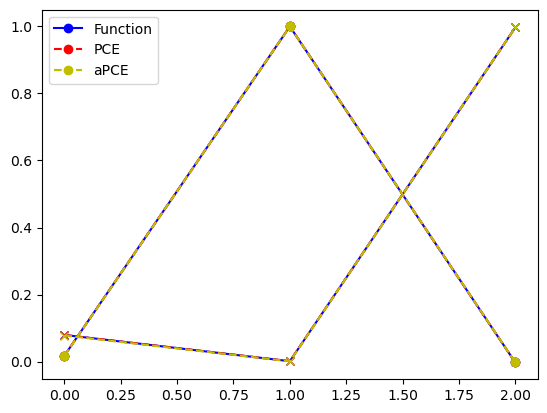

In [400]:
plt.plot(W_Ishigami[:,0],'o-', c = 'b', label = 'Function')
plt.plot(W_Ishigami[:,1],'x-', c = 'b')
plt.plot(W_PCE[:,0],'o--', c = 'r', label = 'PCE')
plt.plot(W_PCE[:,1],'x--', c = 'r')
plt.plot(W_aPCE[:,0],'o--', c = 'y', label = 'aPCE')
plt.plot(W_aPCE[:,1],'x--', c = 'y')
plt.legend()

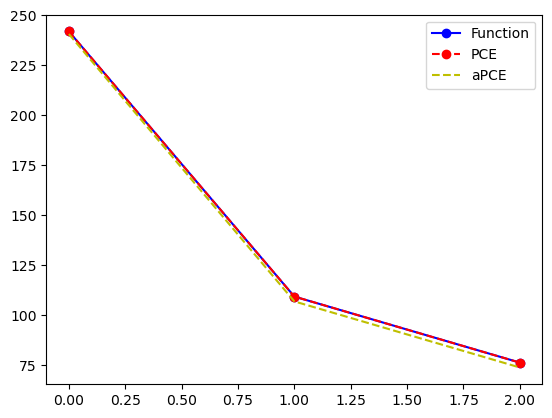

In [401]:
plt.plot(lam_Ishigami,'o-', c = 'b', label = 'Function')
plt.plot(lam_PCE,'o--', c = 'r', label = 'PCE')
plt.plot(lam_aPCE,'--', c = 'y', label = 'aPCE')
plt.legend()

In [402]:
alpha_df = pd.DataFrame([alpha_Ishigami, alpha_PCE, alpha_aPCE]).T

In [403]:
alpha_df.index = ['$a_1$', '$a_2$', '$a_3$']
alpha_df.columns = ['Function', 'PCE', 'aPCE']
alpha_df

,Function,PCE,aPCE
$a_1$,0.075804,0.075815,0.071849
$a_2$,241.776054,241.774598,240.495772
$a_3$,0.001641,0.001660,0.000967


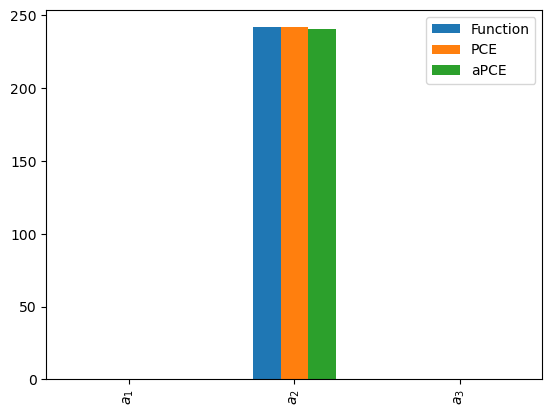

In [404]:
alpha_df.plot.bar();

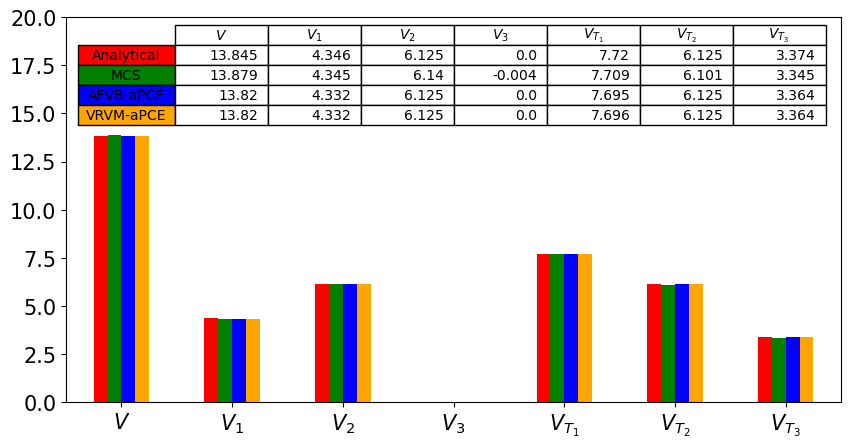

In [97]:
l = ['$V$', '$V_1$', '$V_2$','$V_3$', '$V_{T_1}$','$V_{T_2}$','$V_{T_3}$']
plot_Variances(GSA_Ishigami, Sobol_MC_Ishigami, GSA_AFVB_Ishigami, 
               V_Ishigami, V_MC_Ishigami, V_AFVB_Ishigami, V_VRVM_Ishigami,
               GSA_VRVM_Ishigami, l, 20, (10,5), 1);
#plt.savefig(wd + '/Variances_Ishigami.png')

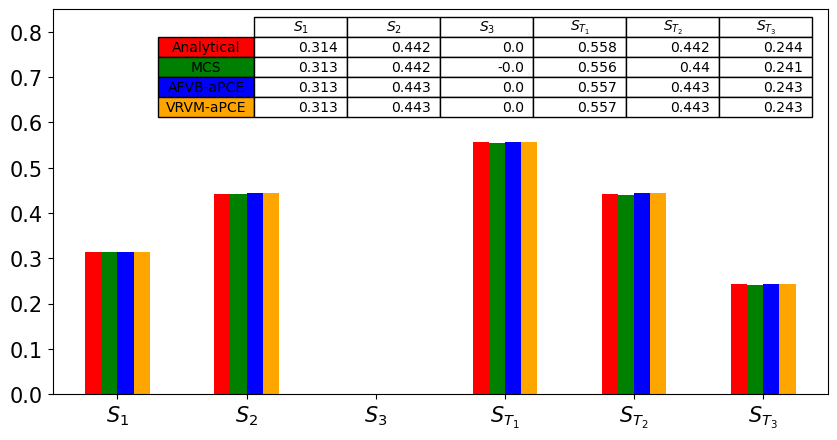

In [98]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$']
plot_Sobol_Indices(GSA_Ishigami, Sobol_MC_Ishigami, 
           GSA_AFVB_Ishigami, GSA_VRVM_Ishigami, l, 0.85, (10,5), 1);
#plt.savefig(wd + '/GSA_Ishigami.png')

### For the following plots we can:
* Plot the full expansion coefficients with the sparse expansion coefficients
* Plot the coeffients of both sparse models, AFVB and VRVM
* Plot the coefficients of one model for PCE and aPCE

Question: Why plot the x-axis with a log scale?

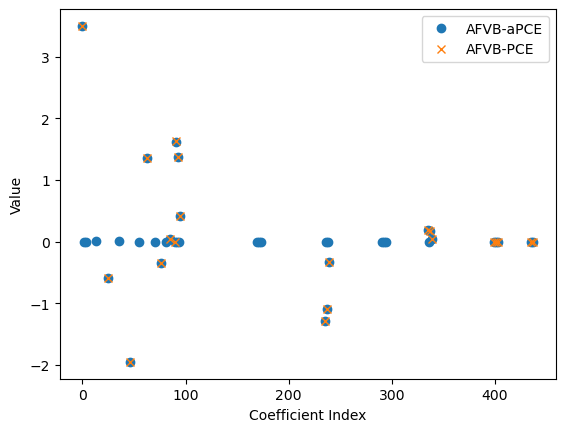

In [99]:
plt.plot(mod_AFVB_Ishigami.active_cols, mod_AFVB_Ishigami.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Ishigami.active_cols, mod_AFVB_PCE_Ishigami.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Ishigami.png')

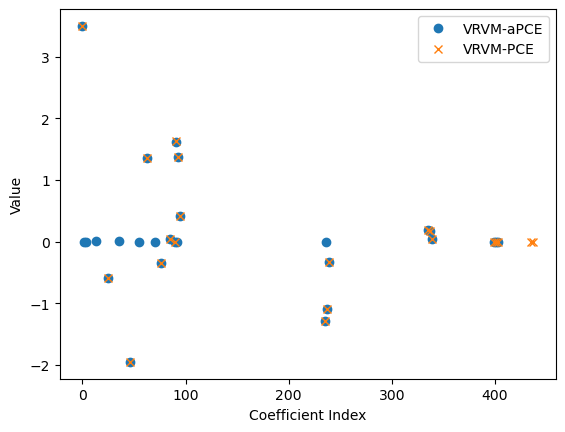

In [100]:
plt.plot(mod_VRVM_Ishigami.active_cols, mod_VRVM_Ishigami.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Ishigami.active_cols, mod_VRVM_PCE_Ishigami.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Ishigami.png')

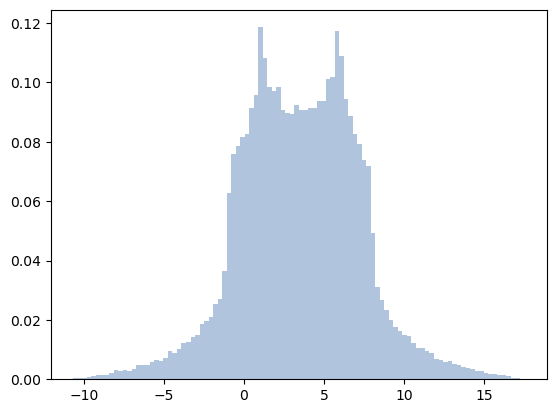

In [292]:
plt.hist(Ishigami_Function(X_dens).reshape(N_dens), density = True, bins = 100, color = 'lightsteelblue', label='Ishigmai Function')
#sns.kdeplot((mod_AFVB_Ishigami.predict(X_dens, mod_AFVB_Ishigami.active_cols)).reshape(N_dens), 
#            lw=2, color='r', label='AFVB-aPCE')
#sns.kdeplot((mod_VRVM_Ishigami.predict(X_dens, mod_VRVM_Ishigami.active_cols)).reshape(N_dens), 
#            lw=2, linestyle="--", color='g', label='VRVM-aPCE')
#plt.legend();
plt.savefig(wd + '/Density_Ishigami.png')

## Running with different values of N_pol

In [15]:
np.random.seed(100)

N_pol = N_train
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

Res_Error, Res_GSA, mod_save = Results(Ishigami_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)


N_pol_ls = [5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


for i in N_pol_ls:
    N_pol = i

    X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

    mod = aPCE(X_pol, p, idx)
    P = mod.Create_Orthonormal_Polynomials(p)

    Res1, Res2, mod_save = Results(Ishigami_Function, X_train, X_test, 
            AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)
    
    Res_Error = pd.concat([Res_Error, Res1], ignore_index = True, sort = False)
    Res_GSA = pd.concat([Res_GSA, Res2], ignore_index = True, sort = False)

In [16]:
Res_Error

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,320,49,0.000081,0.000315,0.000837,0.000669,0.852478
1,5000,45,0.000081,0.000298,0.000749,0.000650,0.640837
2,10000,44,0.000091,0.000273,0.000748,0.000650,0.773641
3,50000,46,0.000091,0.000275,0.000722,0.000649,0.783967
4,100000,44,0.000087,0.000270,0.000763,0.000567,0.820247
5,500000,43,0.000095,0.000280,0.000716,0.000587,0.999585
6,1000000,42,0.000092,0.000278,0.000662,0.000563,1.306579
7,5000000,37,0.000089,0.000275,0.000689,0.000553,1.434395
8,10000000,35,0.000092,0.000296,0.000721,0.000552,1.278801


In [17]:
Res_GSA

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.332465,4.399501,6.370637,2.483159e-03,7.959345,6.370637,3.562328,0.306960,0.444490,1.732542e-04,0.555337,0.444490,0.248550
1,14.116932,4.482868,6.094916,1.179173e-07,8.022015,6.094916,3.539147,0.317553,0.431745,8.352898e-09,0.568255,0.431745,0.250702
2,13.773153,4.383211,6.004761,8.230918e-05,7.768310,6.004761,3.385182,0.318243,0.435976,5.976059e-06,0.564018,0.435976,0.245781
3,13.804783,4.337431,6.115694,7.273424e-05,7.689016,6.115694,3.351658,0.314198,0.443013,5.268771e-06,0.556982,0.443013,0.242790
4,13.862851,4.362146,6.131230,8.412202e-06,7.731613,6.131230,3.369475,0.314664,0.442278,6.068161e-07,0.557722,0.442278,0.243058
5,13.853779,4.350173,6.127986,1.849383e-08,7.725793,6.127986,3.375620,0.314006,0.442333,1.334930e-09,0.557667,0.442333,0.243661
6,13.857016,4.350884,6.129607,5.466956e-07,7.727409,6.129607,3.376526,0.313984,0.442347,3.945262e-08,0.557653,0.442347,0.243669
7,13.840739,4.343700,6.123285,1.120902e-06,7.717454,6.123285,3.373755,0.313834,0.442410,8.098572e-08,0.557590,0.442410,0.243755
8,13.850794,4.349116,6.124486,1.455865e-07,7.726307,6.124486,3.377192,0.313998,0.442176,1.051106e-08,0.557824,0.442176,0.243827


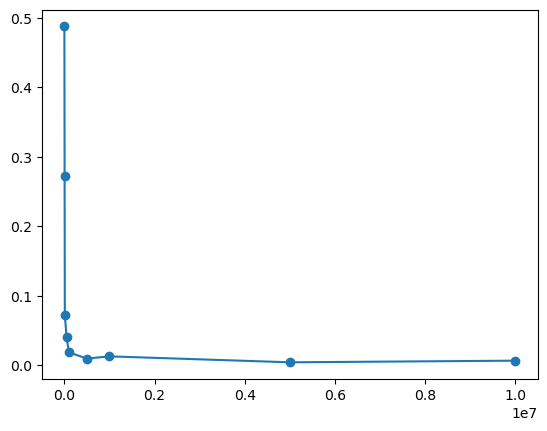

In [18]:
plt.plot(Res_Error['N_pol'], np.abs(Res_GSA[0]-GSA_Ishigami[0]), 'o-')

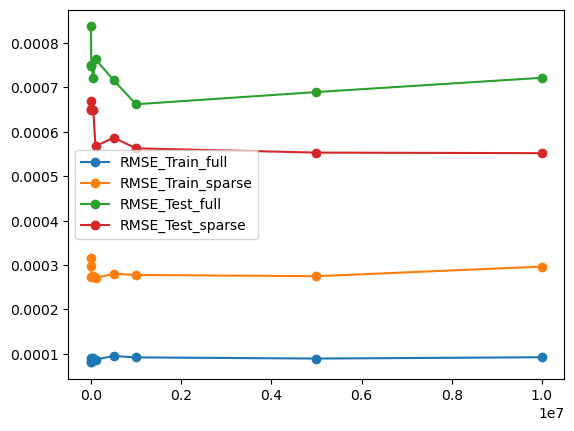

In [19]:
plt.plot(Res_Error['N_pol'], Res_Error[['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse']], 'o-',
        label = ['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse'])
plt.legend();

## Running with different values of N_pol

In [21]:
np.random.seed(100)

N_pol = 1000
X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))

mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

Res_Error, Res_GSA = Results(Ishigami_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)


N_pol_ls = [5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]


for i in N_pol_ls:
    N_pol = i

    X_pol = np.random.uniform(-np.pi, np.pi, size=(N_pol, d))
    mod = aPCE(X_pol, p, idx)
    P = mod.Create_Orthonormal_Polynomials(p)

    Res1, Res2 = Results(Ishigami_Function, X_train, X_test, 
            SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)
    
    Res_Error = pd.concat([Res_Error, Res1], ignore_index = True, sort = False)
    Res_GSA = pd.concat([Res_GSA, Res2], ignore_index = True, sort = False)

KeyboardInterrupt: 

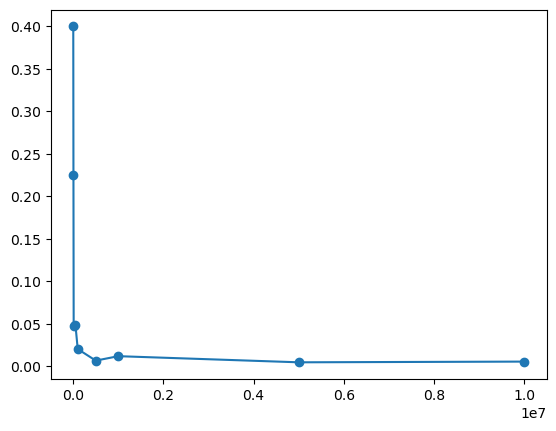

In [25]:
plt.plot(Res_Error['N_pol'], np.abs(Res_GSA[0]-GSA_Ishigami[0]), 'o-');

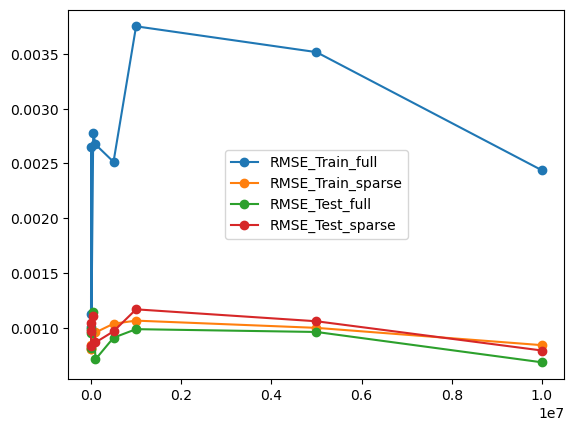

In [26]:
plt.plot(Res_Error['N_pol'], Res_Error[['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse']], 'o-',
        label = ['RMSE_Train_full', 'RMSE_Train_sparse',
                                    'RMSE_Test_full', 'RMSE_Test_sparse'])
plt.legend();

# Example 2: Morris Function
The morris function is given as

$$
Y = b_0 + \sum_{i=1}^{20}b_i \omega_i + \sum_{i<j}^{20}b_{ij}\omega_i\omega_j + \sum_{1<j<l}^{20}b_{ijl}\omega_i\omega_j\omega_l + \sum_{i<j<l<s}^{20}b_{ijls}\omega_i\omega_j\omega_l\omega_s
$$
where
$$
\omega_i = \left\{
        \begin{array}{ll}
            \frac{2.2X_i}{X_i+0.1} - 1 & \quad \text{if } i=3,5,7 \\
            2X_i - 1 & \quad \text{otherwise}
        \end{array}
    \right.
$$
The coefficients are given by

* $X_i \sim \mathcal{U}(0,1)$ for $i=1,\dots,20$
* $b_i = 20$ for $i=1,\dots, 10$
* $b_{ij} = -15$ for $i,j=1,\dots, 6 \phantom{xx} i<j$
* $b_{ijl} = -10$ for $i,j,l = 1,\dots, 5 \phantom{xx} i<j<l$
* $b_{ijls} = 5$ for $i,j,l,s = 1,\dots, 4 \phantom{xx} i<j<l<s$

The remaining coefficients are defined by

* $b_0 = 0$
* $b_i = (-1)^i$
* $b_{ij} = (-1)^{i+j}$
* 0 for all other

In [23]:
d = 20  # d --> number of random variables
p = 5 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [24]:
n

53130

In [25]:
def Morris_Function(X):
    
    N = X.shape[0]
    d = X.shape[1]
    # Making indexes for the sums
    index2 = []
    for j in range(1,20):
        for i in range(j):
            index2.append([i,j])
    index2 = np.array(index2)
    
    index3 = []
    for l in range(2,5):
        for j in range(1,l):
            for i in range(j):
                index3.append([i,j,l])
    index3 = np.array(index3)
    
    # Creating omega
    omega = np.zeros((N, d))
    for i in range(d):
        omega[:,i] = 2*X[:,i] - 1
    for i in [2,4,6]:
        omega[:,i] = 2.4*X[:,i]/(X[:,i] + 1) - 1
        
    # Sum with one index
    s1_1_to_10 = np.sum(20*omega[:,0:10], axis = 1)
    s1_11_to_20 = np.sum(omega[:,10:20], axis = 1)

    s1 = s1_1_to_10 + s1_11_to_20
    
    # Sum with two index
    s2_1_to_6 = np.zeros(N)
    s2_7_to_20 = np.zeros(N)
    for k in range(index2.shape[0]):
        if index2[k][1] <= 5:
            s2_1_to_6 += -15*omega[:,index2[k][0]]*omega[:,index2[k][1]]
        else:
            s2_7_to_20 += (-1)**(index2[k][0] + index2[k][1] + 2)\
            *omega[:,index2[k][0]]*omega[:,index2[k][1]]

    s2 = s2_1_to_6 + s2_7_to_20
    
    # Sum with three index
    s3 = np.zeros(N)
    for k in range(index3.shape[0]):
        s3 += (-10)*omega[:,index3[k][0]]*omega[:,index3[k][1]]*omega[:,index3[k][2]]
    
    # Sum with four index
    s4 = 5*omega[:,0]*omega[:,1]*omega[:,2]*omega[:,3]
    
    return s1 + s2 + s3 + s4

In [26]:
#np.random.seed(123)
X_train = np.random.uniform(0, 1, size=(N_train, d))
X_test = np.random.uniform(0, 1, size=(N_test, d))
X_pol = np.random.uniform(0, 1, size=(N_pol, d))

Y_train = Morris_Function(X_train)
Y_test = Morris_Function(X_test)

In [ ]:
idx = multivariate_pce_index(d, p)

In [ ]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg

    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed

    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])

    return index

In [34]:
multivariate_pce_index(20, 2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 2],
       ...,
       [3, 0, 1, ..., 0, 0, 0],
       [3, 1, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]])

In [32]:
multivariate_pce_index(5, 4)

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 3],
       [0, 0, 0, 0, 4],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 2],
       [0, 0, 0, 1, 3],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 2, 1],
       [0, 0, 0, 2, 2],
       [0, 0, 0, 3, 0],
       [0, 0, 0, 3, 1],
       [0, 0, 0, 4, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 0, 2],
       [0, 0, 1, 0, 3],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 1, 1, 2],
       [0, 0, 1, 2, 0],
       [0, 0, 1, 2, 1],
       [0, 0, 1, 3, 0],
       [0, 0, 2, 0, 0],
       [0, 0, 2, 0, 1],
       [0, 0, 2, 0, 2],
       [0, 0, 2, 1, 0],
       [0, 0, 2, 1, 1],
       [0, 0, 2, 2, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 3, 0, 1],
       [0, 0, 3, 1, 0],
       [0, 0, 4, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 1],
       [0, 1, 0, 0, 2],
       [0, 1, 0, 0, 3],
       [0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1],
       [0, 1, 0,

In [37]:
x = list(range(4))
[j for j in product(x, repeat = 12)]

[(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 3),
 (0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0),
 (0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [42]:
def basis_PCE_Morris(Z, p):
    "Z ~ U(0, 1)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

# MC Sobol Indices

In [43]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_Morris, V_MC_Morris = MC_Sobol(Morris_Function, dataA, dataB)

In [44]:
Sobol_MC_Morris

,Partial Variance,Total Variance,1st Order,Total Order
0,242.4323,313.4620,0.1353,0.1750
1,252.2283,323.5936,0.1408,0.1806
2,63.7909,99.4234,0.0356,0.0555
3,250.8887,323.2264,0.1400,0.1804
4,63.1509,99.0924,0.0352,0.0553
5,265.4501,361.3436,0.1482,0.2017
6,42.0369,44.8651,0.0235,0.0250
7,143.0528,147.6728,0.0798,0.0824
8,122.6619,126.0736,0.0685,0.0704
9,143.2527,148.4134,0.0800,0.0828


# AFVB

In [45]:
Error_AFVB_Morris, GSA_AFVB_Morris, mod_AFVB_Morris, V_AFVB_Morris = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_Morris

In [51]:
Error_AFVB_PCE_Morris, GSA_AFVB_PCE_Morris, mod_AFVB_PCE_Morris, V_AFVB_PCE_Morris = Results(Morris_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Morris, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_PCE_Morris

# VRVM

In [53]:
a_0 = 0.2
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Morris_Function(X_train).reshape(N_train)

In [54]:
Error_VRVM_Morris, GSA_VRVM_Morris, mod_VRVM_Morris, V_VRVM_Morris = Results(Morris_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:21: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:27: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:21: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:27: RuntimeWarning: invalid value encountered in scalar divide
  S_Total.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:21: RuntimeWarning: invalid value encountered in scalar divide
  S_Partial.append(np.sum(a[temp]**2)/V)
/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_85421/3325928519.py:27: Runtim

In [ ]:
GSA_VRVM_Morris

In [ ]:
Error_VRVM_PCE_Morris, GSA_VRVM_PCE_Morris, mod_VRVM_PCE_Morris, V_VRVM_PCE_Morris = Results(Morris_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Morris, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

In [ ]:
plot_Error(Error_AFVB_Morris, Error_AFVB_PCE_Morris, 
           Error_VRVM_Morris, Error_VRVM_PCE_Morris,
           10000, '$10^{-4}$')
#plt.savefig(wd + '/RMSE_Morris.png')

In [ ]:
#l = ['$S_1$', '$S_2$','$S_3$', '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$']
plot_Sobol_Indices(GSA_Morris, Sobol_MC_Morris, 
           GSA_AFVB_Morris, GSA_VRVM_Morris, l, 0.85);
#plt.savefig(wd + '/GSA_Morris.png')

In [ ]:
plt.plot(mod_AFVB_Morris.active_cols, mod_AFVB_Morris.a_hat, 'o')
plt.plot(mod_AFVB_PCE_Morris.active_cols, mod_AFVB_PCE_Morris.a_hat, 'x')

# Example 3: Borehole Function
 

$$
f(x) = \frac{2\pi*T_u(H_u-H_l)}{\ln(r/r_w)\left(1+\frac{2LT_u}{\ln(r/r_w)r_w^2K_w}+\frac{T_u}{T_l}\right)}
$$

* $r_w \sim \mathcal{N}(0.1, 0.0161812)$
* $r \sim \text{Lognormal}(7.71, 1.0056)$
* $T_u \sim \mathcal{U}(63070, 115600)$
* $H_u \sim \mathcal{U}(990, 1110)$
* $T_l \sim \mathcal{U}(63.1, 116)$
* $H_l \sim \mathcal{U}(700, 820)$
* $L \sim \mathcal{U}(1120, 1680)$
* $K_w \sim \mathcal{U}(9855, 12045)$

In [865]:
d = 8  # d --> number of random variables
p = 5 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [866]:
#np.random.seed(123)
def make_data_borehole(N):
    X = np.zeros((N, d))
    X[:,0] = np.random.normal(0.1, 0.0161812, size = N)
    X[:,1] = np.random.lognormal(7.71, 1.0056, size = N)
    X[:,2] = np.random.uniform(63070, 115600, size = N)
    X[:,3] = np.random.uniform(990, 1110, size = N)
    X[:,4] = np.random.uniform(63.1, 116, size = N)
    X[:,5] = np.random.uniform(700, 820, size = N)
    X[:,6] = np.random.uniform(1120, 1680, size = N)
    X[:,7] = np.random.uniform(9855, 12045, size = N)
    return X

In [867]:
X_train = make_data_borehole(N_train)
X_test = make_data_borehole(N_test)
X_pol = make_data_borehole(N_pol)

idx = multivariate_pce_index(d, p)

In [868]:
def Borehole_Function(X):
    r_w = X[:,0]
    r = X[:,1]
    T_u = X[:,2]
    H_u = X[:,3]
    T_l = X[:,4]
    H_l = X[:,5]
    L = X[:,6]
    K_w = X[:,7]
    
    return (2*np.pi*T_u*(H_u-H_l))/(np.log(r/r_w)*(1 + (2*L*T_u)/(np.log(r/r_w)*r_w**2*K_w) + T_u/T_l))

In [869]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [870]:
def basis_PCE_Borehole(Z, p):
    "Z as given in description"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    a_val = [0, 0, 63070, 990, 63.1, 700, 1120, 9855]
    b_val = [0, 0, 115600, 1110, 116, 820, 1680, 12045]
    
    for i in range(n):
        
        Phi[:,i] *= hermitenorm(idx[i][0])((Z[:,0] - 0.1)/0.0161812)
        Phi[:,i] *= hermitenorm(idx[i][1])((np.log(Z[:,1]) - 7.71)/1.0056)
        
        for j in range(2, d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])((a_val[j]+b_val[j]-2*Z[:,j])/(a_val[j]-b_val[j]))
                    
    return Phi

# MC Sobol Indices

In [871]:
dataA = pd.DataFrame(make_data_borehole(N_mc)).values
dataB = pd.DataFrame(make_data_borehole(N_mc)).values

Sobol_MC_Borehole, V_MC_Borehole = MC_Sobol(Borehole_Function, dataA, dataB)

# AFVB

In [872]:
Error_AFVB_Borehole, GSA_AFVB_Borehole, mod_AFVB_Borehole, V_AFVB_Borehole = Results(Borehole_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [875]:
Error_AFVB_PCE_Borehole, GSA_AFVB_PCE_Borehole, mod_AFVB_PCE_Borehole, V_AFVB_PCE_Borehole = Results(Borehole_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Borehole, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [876]:
a_0 = 0.3
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Borehole_Function(X_train).reshape(N_train)

In [877]:
Error_VRVM_Borehole, GSA_VRVM_Borehole, mod_VRVM_Borehole, V_VRVM_Borehole = Results(Borehole_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [878]:
Error_VRVM_PCE_Borehole, GSA_VRVM_PCE_Borehole, mod_VRVM_PCE_Borehole, V_VRVM_PCE_Borehole = Results(Borehole_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Borehole, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

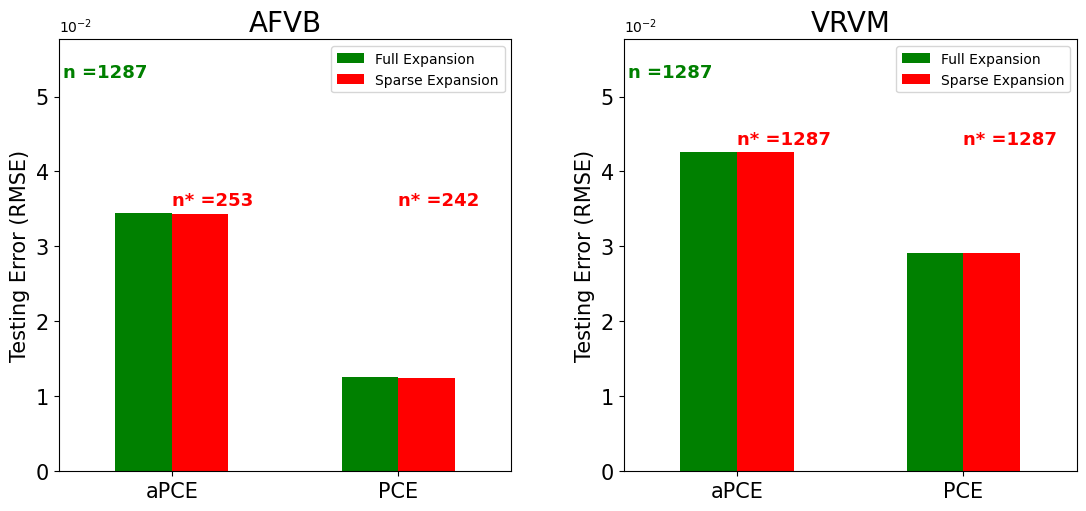

In [879]:
plot_Error(Error_AFVB_Borehole, Error_AFVB_PCE_Borehole, 
           Error_VRVM_Borehole, Error_VRVM_PCE_Borehole,
           100, '$10^{-2}$', mod_AFVB_Borehole.n)
#plt.savefig(wd + '/RMSE_Borehole.png')

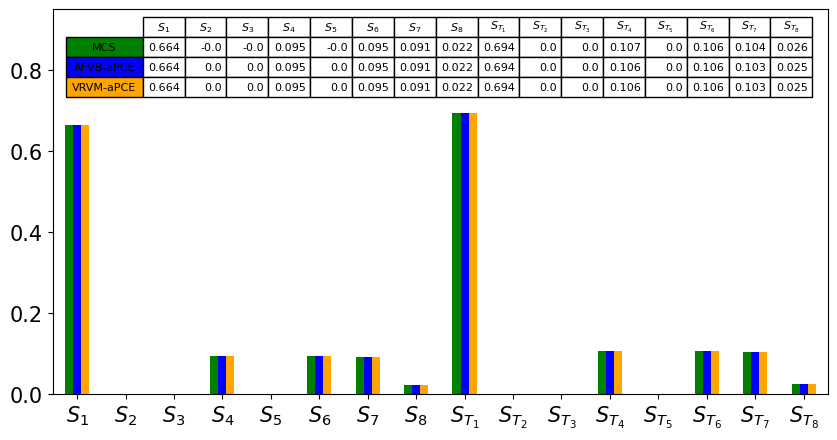

In [880]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$', '$S_8$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$','$S_{T_8}$']

plot_Sobol_Indices(Sobol_MC_Borehole, 
           GSA_AFVB_Borehole, GSA_VRVM_Borehole, GSA4 = None,
                   l=l, ylimit=0.95, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_Borehole.png')

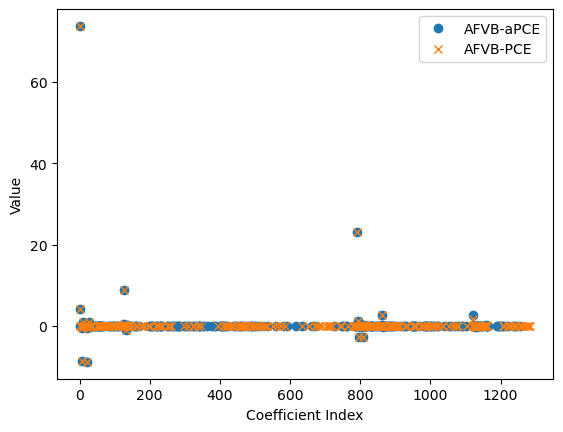

In [881]:
plt.plot(mod_AFVB_Borehole.active_cols, mod_AFVB_Borehole.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Borehole.active_cols, mod_AFVB_PCE_Borehole.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Borehole.png')

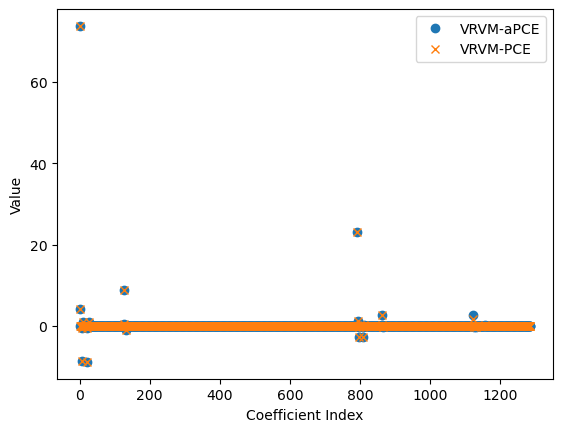

In [882]:
plt.plot(mod_VRVM_Borehole.active_cols, mod_VRVM_Borehole.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Borehole.active_cols, mod_VRVM_PCE_Borehole.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Borehole.png')

# Example 4: 1-dof Undamped Oscillator 

The performance function is

$$
G(X) = 3r-\left| \frac{2 F_1}{m\omega_0^2}\sin\left( \frac{\omega_0^2t_1}{2} \right) \right|
$$

where $\omega_0=\sqrt{\frac{c_1+c_2}{m}}$. The distribution of the random variables are as follow:

\begin{align*}
m &\sim \text{LogNormal}(1, 0.15^2) && \text{Mass} \\
c_1 &\sim \text{LogNormal}(1, 0.2^2) && \text{Stiffness of spring one} \\
c_2 &\sim \text{LogNormal}(0.1, 0.02^2) && \text{Stiffness of spring two} \\
r &\sim \text{LogNormal}(0.5, 0.1^2) && \text{Displacement yielded by one of the springs} \\
F_1 &\sim \text{LogNormal}(1, 0.2^2) && \text{Exciting force} \\
t_1 &\sim \text{LogNormal}(1, 0.1^2) && \text{Excitation time} 
\end{align*}

In [47]:
d = 6  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [48]:
n

924

In [49]:
#np.random.seed(123)
def make_data_oscillator(N):
    X = np.zeros((N, d))
    X[:,0] = np.random.lognormal(1, 0.15, size = N)
    X[:,1] = np.random.lognormal(1, 0.2, size = N)
    X[:,2] = np.random.lognormal(0.1, 0.02, size = N)
    X[:,3] = np.random.lognormal(0.5, 0.1, size = N)
    X[:,4] = np.random.lognormal(1, 0.2, size = N)
    X[:,5] = np.random.lognormal(1, 0.1, size = N)
    return X

In [50]:
X_train = make_data_oscillator(N_train)
X_test = make_data_oscillator(N_test)
X_pol = make_data_oscillator(N_pol)

idx = multivariate_pce_index(d, p)

In [51]:
def Oscillator_Function(X):
    m = X[:,0]
    c1 = X[:,1]
    c2 = X[:,2]
    r = X[:,3]
    F1 = X[:,4]
    t1 = X[:,5]
    
    w0 = np.sqrt((c1+c2)/m)
    
    return 3*r - np.abs(2*F1/(m*w0**2)*np.sin(w0**2*t1/2))

In [52]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [53]:
def basis_PCE_Oscillator(Z, p):
    "Z ~ LogNormal(.,.) as given in description"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [1, 1, 0.1, 0.5, 1, 1]
    sigma_vals = [0.15, 0.2, 0.02, 0.1, 0.2, 0.1]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((np.log(Z[:,j]) - mu_vals[j])/sigma_vals[j])
                    
    return Phi

## AFVB

In [54]:
Error_AFVB_Oscillator, GSA_AFVB_Oscillator, mod_AFVB_Oscillator, V_AFVB_Oscillator = Results(Oscillator_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [55]:
Error_AFVB_Oscillator

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,138,0.000051,0.000371,0.020878,0.021347,12.49754


In [242]:
Error_AFVB_PCE_Oscillator, GSA_AFVB_PCE_Oscillator, mod_AFVB_PCE_Oscillator, V_AFVB_PCE_Oscillator = Results(Oscillator_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Oscillator, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

## VRVM

In [243]:
a_0 = 0.2
b_0 = 1.0

sys.path.append('..')

data={'xi': X_train}
data['y'] = Oscillator_Function(X_train).reshape(N_train)

In [244]:
Error_VRVM_Oscillator, GSA_VRVM_Oscillator, mod_VRVM_Oscillator, V_VRVM_Oscillator = Results(Oscillator_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [245]:
Error_VRVM_PCE_Oscillator, GSA_VRVM_PCE_Oscillator, mod_VRVM_PCE_Oscillator, V_VRVM_PCE_Oscillator = Results(Oscillator_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Oscillator, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

## MC Sobol Indices

In [247]:
dataA = pd.DataFrame(make_data_oscillator(N_mc)).values
dataB = pd.DataFrame(make_data_oscillator(N_mc)).values

Sobol_MC_Oscillator = MC_Sobol(Oscillator_Function, dataA, dataB)

# Plots

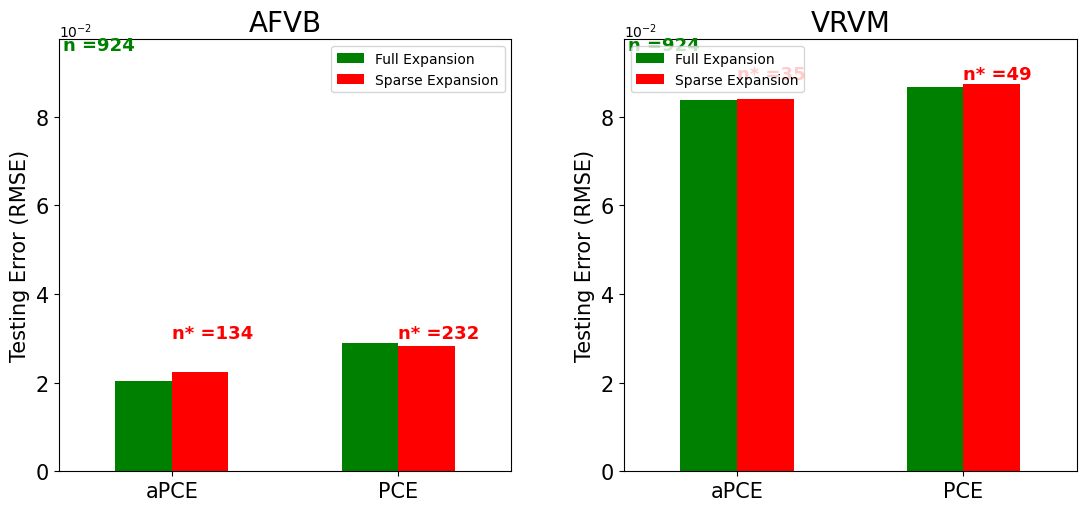

In [494]:
plot_Error(Error_AFVB_Oscillator, Error_AFVB_PCE_Oscillator, 
           Error_VRVM_Oscillator, Error_VRVM_PCE_Oscillator,
           100, '$10^{-2}$', mod_AFVB_Oscillator.n)
#plt.savefig(wd + '/RMSE_Oscillator.png')

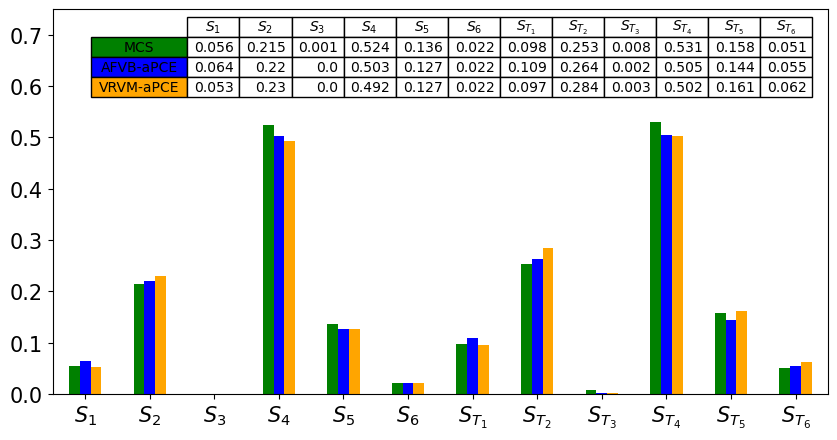

In [499]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$']

plot_Sobol_Indices(Sobol_MC_Oscillator[0], 
           GSA_AFVB_Oscillator, GSA_VRVM_Oscillator, GSA4 = None,
                   l=l, ylimit=0.75, fig_size=(10,5), table_size=0.56);
#plt.savefig(wd + '/GSA_Oscillator.png')

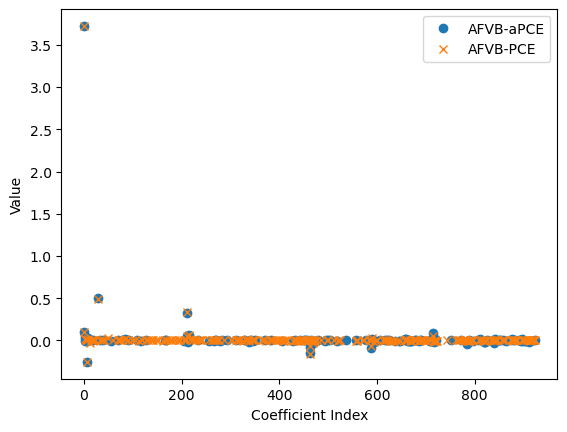

In [500]:
plt.plot(mod_AFVB_Oscillator.active_cols, mod_AFVB_Oscillator.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Oscillator.active_cols, mod_AFVB_PCE_Oscillator.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Oscillator.png')

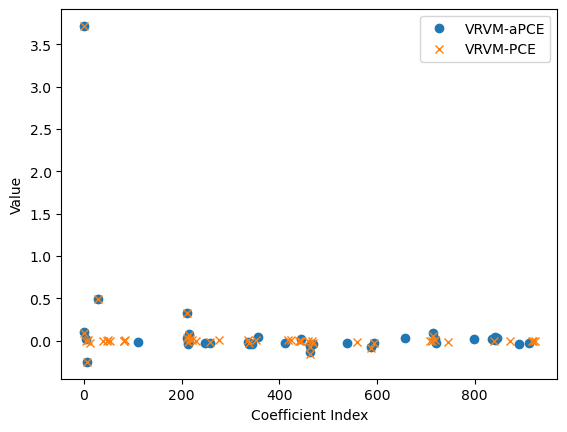

In [501]:
plt.plot(mod_VRVM_Oscillator.active_cols, mod_VRVM_Oscillator.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Oscillator.active_cols, mod_VRVM_PCE_Oscillator.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Oscillator.png')

# Example 5: Cantilever Tube Structure

A **cantilever** is a rigid structural element that extends horizontally and is supported at only one end. The structure is subjected to three random external forces $(F_1, F_2, P)$ and a random torque $T$. The structure fails when the maximum Von Mises stress $\sigma_{max}$ at the fixed end of the tube is greater than the yield strength $R$. The limit state function of the structure is expressed as:

$$
G = R-\sigma_{max} = R-\sqrt{\sigma_x^2+3\tau^2_{zx}}
$$

where 

\begin{align*}
\sigma_x &= \frac{F_1\sin\theta_1+F_2\sin\theta_2+P}{A} + \frac{Md}{2I} \\
M &= F_1\cos\theta_1L_1 + F_2\cos\theta_2L_2 \\
A &= \frac{\pi}{4}\left[d^2 - (d-2h)^2\right] \\
I &= \frac{\pi}{64}\left[d^4-(d-2h)^4\right] \\
\tau_{zx} &= \frac{Td}{4I}
\end{align*}

The **limit state function** $G(X)$ defines a failure criterion that is a function of all random variables $X$. Failure occurs when the load $L$ exceeds the capacity $R$ or when $G(X)<0$. The parameters have the following values:

\begin{align*}
L_1 &= 60 && \text{(mm)} \\
L_2 &= 120 && \text{(mm)} \\
\theta_1 &= 10^{\circ} = \frac{\pi}{18} \\
\theta_2 &= 5^{\circ} = \frac{\pi}{36} \\
d &\sim \mathcal{N}(42, 0.4998^2) && \text{(mm)} \\
h &\sim \mathcal{N}(5, 0.1^2) && \text{(mm)} \\
R_0 &\sim \mathcal{N}(560, 56^2) && \text{(MPa)} \\
F_1 &\sim \mathcal{N}(1800, 180^2) && \text{(N)} \\
F_2 &\sim \mathcal{N}(1800, 180^2) && \text{(N)} \\
P &\sim \mathcal{N}(1000, 100^2) && \text{(N)} \\
T &\sim \mathcal{N}(1900, 190^2) && \text{(Nm)} 
\end{align*}

In [75]:
d = 7  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

In [76]:
# From first paper
L1 = 0.06
L2 = 0.12
Theta1 = 10
Theta2 = 5

D_mu = 0.042
h_mu = 0.005
R0_mu = 560
F_mu = 1800
P_mu = 1000
T_mu = 1900

In [77]:
def make_data_cantilever(N):
    X = np.zeros((N, d))

    # D, h, R0, F1, F2, P, T
    X[:,0] = np.random.normal(D_mu, D_mu*0.0119, N)
    X[:,1] = np.random.normal(h_mu, h_mu*0.02, N)
    X[:,2] = np.random.normal(R0_mu, R0_mu*0.1, N)
    X[:,3] = np.random.normal(F_mu, F_mu*0.1, N)
    X[:,4] = np.random.normal(F_mu, F_mu*0.1, N)
    X[:,5] = np.random.normal(P_mu, P_mu*0.1, N)
    X[:,6] = np.random.normal(T_mu, T_mu*0.1, N)
    
    return X

In [78]:
def Cantilever_Function(X):
    
    D = X[:,0]
    h = X[:,1]
    R0 = X[:,2]
    F1 = X[:,3]
    F2 = X[:,4]
    P = X[:,5]
    T = X[:,6]
    
    
    M = F1*np.cos(Theta1)*L1 + F2*np.cos(Theta2)*L2
    A = np.pi/4*(D**2 - (D - 2*h)**2)
    I = np.pi/64*(D**4 - (D - 2*h)**4)
    sigma_x = (F1*np.sin(Theta1) + F2*np.sin(Theta2) + P)/A + M*D/(2*I)
    tau_zx = T*D/(4*I)
    
    return R0/(np.sqrt(sigma_x**2 + 3*tau_zx**2)*10**(-6)) # Units in MPa

In [79]:
#np.random.seed(100)
X_test = make_data_cantilever(N_test)
X_train = make_data_cantilever(N_train)
X_pol = make_data_cantilever(N_pol)

Y_test = Cantilever_Function(X_test)
Y_train = Cantilever_Function(X_train)

idx = multivariate_pce_index(d, p)

In [80]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)
P_Stieltjes = mod.Create_Orthonormal_Polynomials_Stieltjes(p)

In [108]:
P[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474776e+05,  1.75367590e+07, -4.17550750e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04238269e+07, -9.93408838e+08,  3.54976168e+10,
        -5.63672641e+11,  3.35602431e+12,  0.00000000e+00,
         0.00000000e+00],
       [ 4.89272557e+06, -3.33029425e+08,  3.97711090e+09,
         1.88161238e+11, -5.60547626e+12,  4.27032133e+13,
         0.00000000e+00],
       [-5.68305066e+06,  4.06661870e+08, -6.02174978e+09,
        -1.97482044e+11,  7.09707040e+12, -6.95220478e+13,
         1.5643274

In [109]:
P_Stieltjes[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474798e+05,  1.75367601e+07, -4.17550763e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04705747e+07, -9.97429961e+08,  3.56258122e+10,
        -5.65462552e+11,  3.36521982e+12,  0.00000000e+00,
         0.00000000e+00],
       [-3.99013174e+08,  4.75170234e+10, -2.26313702e+12,
         5.38867673e+13, -6.41450415e+14,  3.05382209e+15,
         0.00000000e+00],
       [ 1.38263582e+10, -1.97629096e+12,  1.17685377e+14,
        -3.73708220e+15,  6.67429108e+16, -6.35647292e+17,
         2.5220626

In [85]:
def basis_PCE_Cantilever(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-mu_vals[j])/sigma_vals[j])
                    
    return Phi

# MC Sobol Indices

In [87]:
dataA = pd.DataFrame(make_data_cantilever(N_mc)).values
dataB = pd.DataFrame(make_data_cantilever(N_mc)).values

Sobol_MC_Cantilever = MC_Sobol(Cantilever_Function, dataA, dataB)

## AFVB

In [71]:
param_space = {'A_0': skopt.space.Real(0.00001, 0.1),
              'B_0': skopt.space.Real(0.00001, 0.1),
              'C_0': skopt.space.Real(0.00001, 0.1),
              'D_0': skopt.space.Real(0.00001, 0.1)
         }

In [72]:
t0 = time.time()
optimizer = BayesSearchCV(estimator = AFVB_PCE(basis = basis_aPCE, p = p),
                            search_spaces = param_space,
                            n_iter = 10,
                            scoring = 'neg_mean_squared_error',
                            cv = 5
)

optimizer.fit(X_train, Y_train)

print(time.time()-t0)

/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)
/Users/chave/anaconda3/lib/python3.11/site-packages/numpy/linalg/linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)

/Users/chave/CUDenver_Thesis/CUDenver-Thesis/AFVB_PCE.py:140: RuntimeWarning: invalid value encountered in subtract
  e_L = np.abs(100*(float(L_r) - L_old)/L_old)


150972.72714066505


In [74]:
150972/60/60

41.93666666666666

In [73]:
optimizer.best_params_

OrderedDict([('A_0', 0.09096737022686904),
             ('B_0', 0.036338331017918696),
             ('C_0', 0.06870344677300601),
             ('D_0', 0.07996448478724165)])

In [99]:
A_0 = 0.1
B_0 = 0.00001 
C_0 = 0.1
D_0 = 0.1 

In [100]:
Error_AFVB_Cantilever, GSA_AFVB_Cantilever, mod_AFVB_Cantilever, V_AFVB_Cantilever = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [101]:
Error_AFVB_Cantilever

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,24,0.000005,0.000217,0.00336,0.001125,44.650299


In [104]:
idx[mod_AFVB_Cantilever.active_cols]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 3],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 2],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 2],
       [1, 0, 0, 0, 0, 0, 3],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0]])

In [102]:
Error_AFVB_Cantilever_S, GSA_AFVB_Cantilever_S, mod_AFVB_Cantilever_S, V_AFVB_Cantilever_S = Results(X_train, X_test, Y_train, Y_test,
        AFVB_PCE(basis_aPCE_Stieltjes, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [103]:
Error_AFVB_Cantilever_S

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,27,0.000005,0.000201,0.003343,0.000625,39.524697


In [105]:
idx[mod_AFVB_Cantilever_S.active_cols]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 4],
       [0, 0, 0, 0, 0, 0, 5],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 2],
       [0, 0, 1, 0, 0, 0, 3],
       [0, 0, 1, 0, 0, 0, 5],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 2],
       [0, 1, 1, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 1],
       [0, 2, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 2],
       [1, 0, 0, 0, 0, 0, 3],
       [1, 0, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 2],
       [1, 1, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0]])

In [106]:
P[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474776e+05,  1.75367590e+07, -4.17550750e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04238269e+07, -9.93408838e+08,  3.54976168e+10,
        -5.63672641e+11,  3.35602431e+12,  0.00000000e+00,
         0.00000000e+00],
       [ 4.89272557e+06, -3.33029425e+08,  3.97711090e+09,
         1.88161238e+11, -5.60547626e+12,  4.27032133e+13,
         0.00000000e+00],
       [-5.68305066e+06,  4.06661870e+08, -6.02174978e+09,
        -1.97482044e+11,  7.09707040e+12, -6.95220478e+13,
         1.5643274

In [107]:
P_Stieltjes[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-8.40798606e+01,  2.00186858e+03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 5.00918418e+03, -2.38552695e+05,  2.83975079e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.45474798e+05,  1.75367601e+07, -4.17550763e+08,
         3.31349787e+09,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.04705747e+07, -9.97429961e+08,  3.56258122e+10,
        -5.65462552e+11,  3.36521982e+12,  0.00000000e+00,
         0.00000000e+00],
       [-3.99013174e+08,  4.75170234e+10, -2.26313702e+12,
         5.38867673e+13, -6.41450415e+14,  3.05382209e+15,
         0.00000000e+00],
       [ 1.38263582e+10, -1.97629096e+12,  1.17685377e+14,
        -3.73708220e+15,  6.67429108e+16, -6.35647292e+17,
         2.5220626

In [169]:
A_0 = 0.1
B_0 = 0.00001 
C_0 = 0.1
D_0 = 0.1 

In [170]:
Error_AFVB_PCE_Cantilever, GSA_AFVB_PCE_Cantilever, mod_AFVB_PCE_Cantilever, V_AFVB_PCE_Cantilever = Results(X_train, X_test, Y_train, Y_test, 
        AFVB_PCE(basis_PCE_Cantilever, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [167]:
Error_AFVB_PCE_Cantilever

,N_pol,n_star,RMSE_Train_full,RMSE_Train_sparse,RMSE_Test_full,RMSE_Test_sparse,time (min)
0,1000000,24,0.000045,0.000196,0.634318,0.000866,812.463429


## VRVM

In [74]:
a_0 = 0.2
b_0 = 1.0

data={'xi': X_train}
data['y'] = Cantilever_Function(X_train).reshape(N_train)

In [126]:
Error_VRVM_Cantilever, GSA_VRVM_Cantilever, mod_VRVM_Cantilever, V_VRVM_Cantilever = Results(data['xi'], X_test, Y_train, Y_test,
        SparseVariationalOptimizer(basis_aPCE, p, 1e-7, 1e-7, 1e-7, 1e-7, a_0, b_0), idx)

In [133]:
Error_VRVM_PCE_Cantilever, GSA_VRVM_PCE_Cantilever, mod_VRVM_PCE_Cantilever, V_VRVM_Cantilever = Results(data['xi'], X_test, Y_train, Y_test, 
        SparseVariationalOptimizer(basis_PCE_Cantilever, p, 1e-8, 1e-8, 1e-8, 1e-8, a_0, b_0), idx)

# Plots

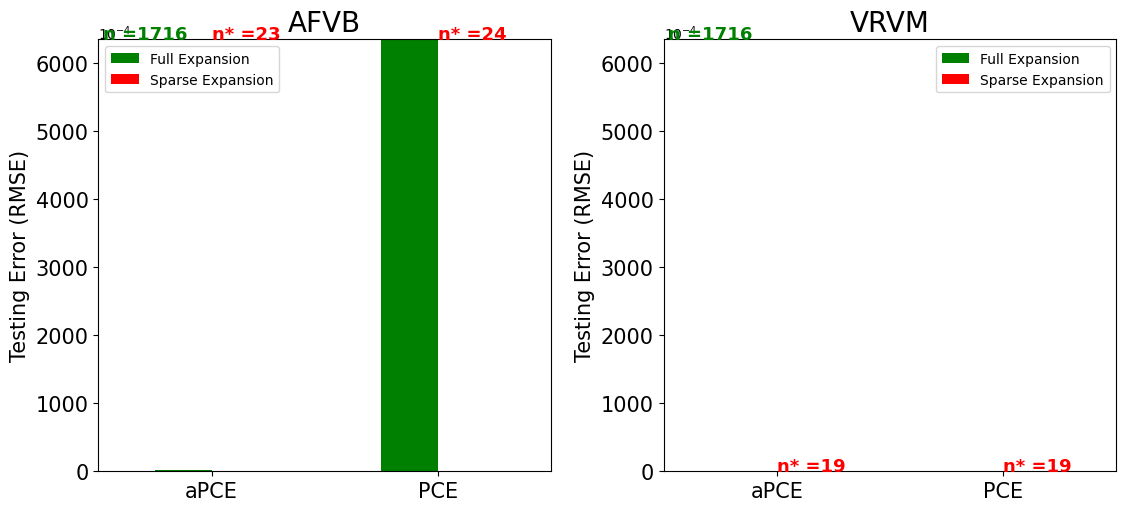

In [168]:
plot_Error(Error_AFVB_Cantilever, Error_AFVB_PCE_Cantilever, 
           Error_VRVM_Cantilever, Error_VRVM_PCE_Cantilever,
           10000, '$10^{-4}$', mod_AFVB_Cantilever.n)
#plt.savefig(wd + '/RMSE_Cantilever.png')

## Activity Scores

In [443]:
def Cantilever(d, h, R0, F1, F2, Pr, T):
    sig_x = (F1*np.sin(Theta1) + F2*np.sin(Theta2) + Pr)/(np.pi/4*(d**2 - (d-2*h)**2)) \
            + ((F1*np.cos(Theta1)*L1 + F2*np.cos(Theta2)*L2)*d)/(np.pi/32*(d**4 - (d-2*h)**4))
    tau_zx = T*d/(np.pi/16*(d**4 - (d - 2*h)**4))
    return R0 - (sig_x**2 + 3*tau_zx**2)**(1/2)

d, h, R0, F1, F2, Pr, T = symbols('d h R0 F1 F2 Pr T')

V_d = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), d))
V_h = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), h))
V_R0 = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), R0))
V_F1 = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), F1))
V_F2 = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), F2))
V_P = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), Pr))
V_T = lambdify([d, h, R0, F1, F2, Pr, T], diff(Cantilever(d, h, R0, F1, F2, Pr, T), T))

def grad_Cantilever(X):
    
    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min(), 
             X_train[:,3].min(), X_train[:,4].min(), X_train[:,5].min(), X_train[:,6].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max(), 
             X_train[:,3].max(), X_train[:,4].max(), X_train[:,5].max(), X_train[:,6].max()]
    
    M = X.shape[0]
    d = X.shape[1]
    
    # scale to [a,b]
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    x7 = 0.5*(X[:,6] + 1)*(b_min[6] - a_min[6]) + a_min[6]
    
    # derivative and scale back to [-1,1]
    grad_f = np.zeros((d,M))
    grad_f[0,:] = V_d(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[0] - a_min[0])
    grad_f[1,:] = V_h(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[1] - a_min[1])
    grad_f[2,:] = V_R0(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[2] - a_min[2])
    grad_f[3,:] = V_F1(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[3] - a_min[3])
    grad_f[4,:] = V_F2(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[4] - a_min[4])
    grad_f[5,:] = V_P(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[5] - a_min[5])
    grad_f[6,:] = V_T(x1, x2, x3, x4, x5, x6, x7)*0.5*(b_min[6] - a_min[6])
    
    return grad_f

In [446]:
M = 10000
X = np.random.uniform(-1, 1, (M, 7))
W_Cantilever, lam_Cantilever, alpha_Cantilever = Activity_Scores(M, 7, grad_Cantilever)

In [447]:
alpha_Cantilever

array([5.93105540e+14, 1.51391391e+14, 2.43178849e+04, 4.10955925e+10,
       7.98963801e+09, 2.09945601e+08, 7.40093316e+15])

### aPCE

In [448]:
def grad_Cantilever_aPCE(X):
    "Z ~ U(-1, 1)"
    
    M = X.shape[0]
    d = X.shape[1]
    
    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min(), 
             X_train[:,3].min(), X_train[:,4].min(), X_train[:,5].min(), X_train[:,6].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max(), 
             X_train[:,3].max(), X_train[:,4].max(), X_train[:,5].max(), X_train[:,6].max()]
    
    # scale to [a,b]
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    x7 = 0.5*(X[:,6] + 1)*(b_min[6] - a_min[6]) + a_min[6]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     Pol_eval(np.polyder((P[0][idx_star[i][0]])[::-1])[::-1], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
        
            
        grad_f[1,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(np.polyder((P[1][idx_star[i][1]])[::-1])[::-1], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
        
        
        grad_f[2,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(np.polyder((P[2][idx_star[i][2]])[::-1])[::-1], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
        
        grad_f[3,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(np.polyder((P[3][idx_star[i][3]])[::-1])[::-1], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
            
        grad_f[4,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(np.polyder((P[4][idx_star[i][4]])[::-1])[::-1], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
                
        grad_f[5,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(np.polyder((P[5][idx_star[i][5]])[::-1])[::-1], x6)*\
                     Pol_eval(P[6][idx_star[i][6]], x7)
                    
        grad_f[6,:] += a_hat[i][0]*\
                     Pol_eval(P[0][idx_star[i][0]], x1)*\
                     Pol_eval(P[1][idx_star[i][1]], x2)*\
                     Pol_eval(P[2][idx_star[i][2]], x3)*\
                     Pol_eval(P[3][idx_star[i][3]], x4)*\
                     Pol_eval(P[4][idx_star[i][4]], x5)*\
                     Pol_eval(P[5][idx_star[i][5]], x6)*\
                     Pol_eval(np.polyder((P[6][idx_star[i][6]])[::-1])[::-1], x7)
    
    grad_f[0,:] *= 0.5*(b_min[0] - a_min[0])
    grad_f[1,:] *= 0.5*(b_min[1] - a_min[1])
    grad_f[2,:] *= 0.5*(b_min[2] - a_min[2])
    grad_f[3,:] *= 0.5*(b_min[3] - a_min[3])
    grad_f[4,:] *= 0.5*(b_min[4] - a_min[4])
    grad_f[5,:] *= 0.5*(b_min[5] - a_min[5])
    grad_f[6,:] *= 0.5*(b_min[6] - a_min[6])
    
    return grad_f


In [450]:
idx_star = idx[mod_AFVB_Cantilever.active_cols]
a_hat = mod_AFVB_Cantilever.a_hat
W_aPCE, lam_aPCE, alpha_aPCE = Activity_Scores(M, 7, grad_Cantilever_aPCE)

In [451]:
alpha_aPCE

array([1.60418335e-02, 4.06541808e-03, 2.26506850e-01, 7.49722509e-07,
       0.00000000e+00, 0.00000000e+00, 2.35563346e-01])

### PCE

In [ ]:
def basis_PCE_Cantilever(Z, p):
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-mu_vals[j])/sigma_vals[j])
                    
    return Phi

In [ ]:
def grad_Cantilever_PCE(X):
    "Z ~ U(-1, 1)"

    a_min = [X_train[:,0].min(), X_train[:,1].min(), X_train[:,2].min(), 
             X_train[:,3].min(), X_train[:,4].min(), X_train[:,5].min(), X_train[:,6].min()]
    b_min = [X_train[:,0].max(), X_train[:,1].max(), X_train[:,2].max(), 
             X_train[:,3].max(), X_train[:,4].max(), X_train[:,5].max(), X_train[:,6].max()]
    
    mu_vals = [0.042, 0.005, 560, 1800, 1800, 1000, 1900]
    sigma_vals = [0.0004998, 0.0001, 56, 180, 180, 100, 190]
    
    x1 = 0.5*(X[:,0] + 1)*(b_min[0] - a_min[0]) + a_min[0]
    x2 = 0.5*(X[:,1] + 1)*(b_min[1] - a_min[1]) + a_min[1]
    x3 = 0.5*(X[:,2] + 1)*(b_min[2] - a_min[2]) + a_min[2]
    x4 = 0.5*(X[:,3] + 1)*(b_min[3] - a_min[3]) + a_min[3]
    x5 = 0.5*(X[:,4] + 1)*(b_min[4] - a_min[4]) + a_min[4]
    x6 = 0.5*(X[:,5] + 1)*(b_min[5] - a_min[5]) + a_min[5]
    x7 = 0.5*(X[:,6] + 1)*(b_min[6] - a_min[6]) + a_min[6]
    
    n_star = a_hat.shape[0]
    grad_f = np.zeros((d,M))
    for i in range(n_star):
        grad_f[0,:] += a_hat[i][0]*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][0])))[::-1], (x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])
            
        grad_f[1,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][1])))[::-1], (x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])
        
        grad_f[2,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][2])))[::-1], (x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        grad_f[3,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][3])))[::-1], (x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        
        grad_f[4,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][4])))[::-1], (x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        grad_f[5,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][5])))[::-1], (x6-mu_vals[5])/sigma_vals[5])*\
                     hermitenorm(idx_star[i][6])((x7-mu_vals[6])/sigma_vals[6])

        grad_f[6,:] += a_hat[i][0]*\
                     hermitenorm(idx_star[i][0])((x1-mu_vals[0])/sigma_vals[0])*\
                     hermitenorm(idx_star[i][1])((x2-mu_vals[1])/sigma_vals[1])*\
                     hermitenorm(idx_star[i][2])((x3-mu_vals[2])/sigma_vals[2])*\
                     hermitenorm(idx_star[i][3])((x4-mu_vals[3])/sigma_vals[3])*\
                     hermitenorm(idx_star[i][4])((x5-mu_vals[4])/sigma_vals[4])*\
                     hermitenorm(idx_star[i][5])((x6-mu_vals[5])/sigma_vals[5])*\
                     Pol_eval(np.polyder(np.array(hermitenorm(idx_star[i][6])))[::-1], (x7-mu_vals[6])/sigma_vals[6])

    #grad_f[0] *= 0.5*(b_min[0] - a_min[0])
    #grad_f[1] *= 0.5*(b_min[1] - a_min[1])
    #grad_f[2] *= 0.5*(b_min[2] - a_min[2])
    return grad_f

In [ ]:
idx_star = idx[mod_AFVB_PCE_Cantilever.active_cols]
a_hat = mod_AFVB_PCE_Cantilever.a_hat
W_PCE, lam_PCE, alpha_PCE = Activity_Scores(M, 7, grad_Cantilever_PCE)

In [ ]:
plt.plot(W_Ishigami[:,0],'o-', c = 'b', label = 'Function')
plt.plot(W_Ishigami[:,1],'x-', c = 'b')
plt.plot(W_PCE[:,0],'o--', c = 'r', label = 'PCE')
plt.plot(W_PCE[:,1],'x--', c = 'r')
plt.plot(W_aPCE[:,0],'o--', c = 'y', label = 'aPCE')
plt.plot(W_aPCE[:,1],'x--', c = 'y')
plt.legend()

In [ ]:
plt.plot(lam_Ishigami,'o-', c = 'b', label = 'Function')
plt.plot(lam_PCE,'o--', c = 'r', label = 'PCE')
plt.plot(lam_aPCE,'--', c = 'y', label = 'aPCE')
plt.legend()

In [ ]:
alpha_df = pd.DataFrame([alpha_Ishigami, alpha_PCE, alpha_aPCE]).T

In [ ]:
alpha_df.index = ['$a_1$', '$a_2$', '$a_3$']
alpha_df.columns = ['Function', 'PCE', 'aPCE']
alpha_df

In [ ]:
alpha_df.plot.bar();

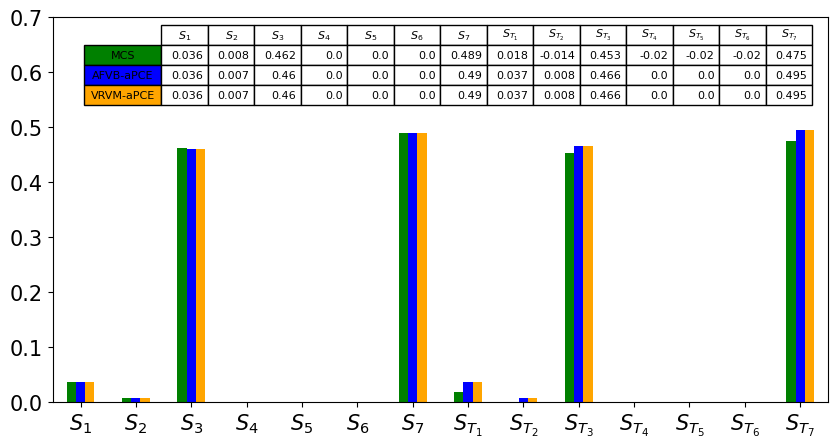

In [112]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$']

plot_Sobol_Indices(Sobol_MC_Cantilever[0], 
           GSA_AFVB_Cantilever, GSA_VRVM_Cantilever, GSA4 = None,
                   l=l, ylimit=0.7, fig_size=(10,5), table_size=0.5);
#plt.savefig(wd + '/GSA_Cantilever.png')

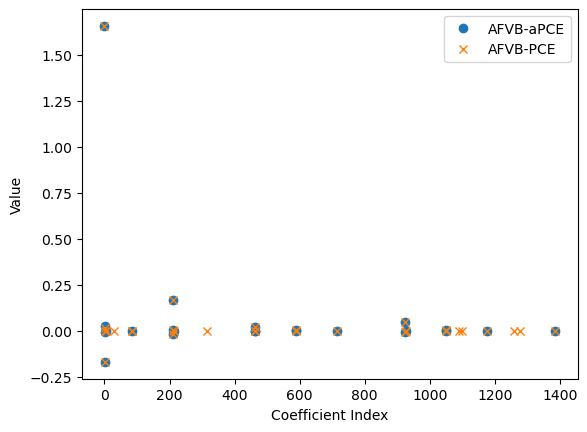

In [113]:
plt.plot(mod_AFVB_Cantilever.active_cols, mod_AFVB_Cantilever.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Cantilever.active_cols, mod_AFVB_PCE_Cantilever.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Cantilever.png')

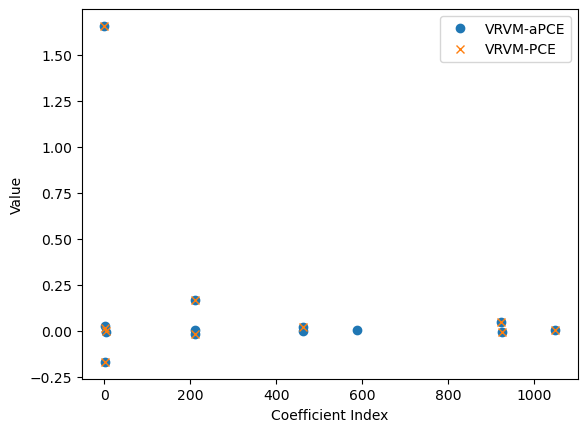

In [114]:
plt.plot(mod_VRVM_Cantilever.active_cols, mod_VRVM_Cantilever.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Cantilever.active_cols, mod_VRVM_PCE_Cantilever.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Cantilever.png')

# Example 6: Sobol' function

The Sobol function is given by

$$
Y = \prod_{i=1}^d\frac{|4\xi_i - 2| + a_i}{1 + a_i}
$$

where $\xi_i$ are independent random variables uniformly distributed over $[0,1]$ and $a_i$ are the constants. 


In [302]:
d = 8  # d --> number of random variables
p = 5  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [303]:
X_train = np.random.uniform(0, 1, size=(N_train, d))
X_test = np.random.uniform(0, 1, size=(N_test, d))
X_pol = np.random.uniform(0, 1, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [304]:
def Sobol_Function(Z):
    alpha = np.c_[1, 2, 5, 10, 20, 50, 100, 500]
    return np.c_[np.prod((np.abs(4*Z - 2) + alpha)/(1 + alpha),1)]

In [305]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [306]:
def basis_PCE_Sobol(Z, p):
    "Z ~ U(0, 1)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  math.sqrt((2*idx[i][j]+1)/1)*legendre(idx[i][j])(2*Z[:,j]-1)
    return Phi

# MC Sobol Indices

In [307]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_Sobol = MC_Sobol(Sobol_Function, dataA, dataB)

In [308]:
# Analytical Sobol Indices
GSA_Sobol = ([0.6037, 0.2683, 0.0671, 0.0200, 0.0055, 0.0009, 0.0002, 0.0000], 
             [0.6342, 0.2945, 0.0756, 0.0227, 0.0062, 0.0011, 0.003, 0.0000])

GSA_Sobol = pd.DataFrame(GSA_Sobol).T
GSA_Sobol.columns = ['1st Order', 'Total Order']

# AFVB

In [309]:
Error_AFVB_Sobol, GSA_AFVB_Sobol, mod_AFVB_Sobol, V_AFVB_Sobol = Results(Sobol_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [311]:
Error_AFVB_PCE_Sobol, GSA_AFVB_PCE_Sobol, mod_AFVB_PCE_Sobol, V_AFVB_PCE_Sobol = Results(Sobol_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_Sobol, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [313]:
data={'xi': X_train}
data['y'] = Sobol_Function(X_train).reshape(N_train)

a_0 = 0.2
b_0 = 1.0

In [314]:
Error_VRVM_Sobol, GSA_VRVM_Sobol, mod_VRVM_Sobol, V_VRVM_Sobol = Results(Sobol_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [315]:
Error_VRVM_PCE_Sobol, GSA_VRVM_PCE_Sobol, mod_VRVM_PCE_Sobol, V_VRVM_PCE_Sobol = Results(Sobol_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_Sobol, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

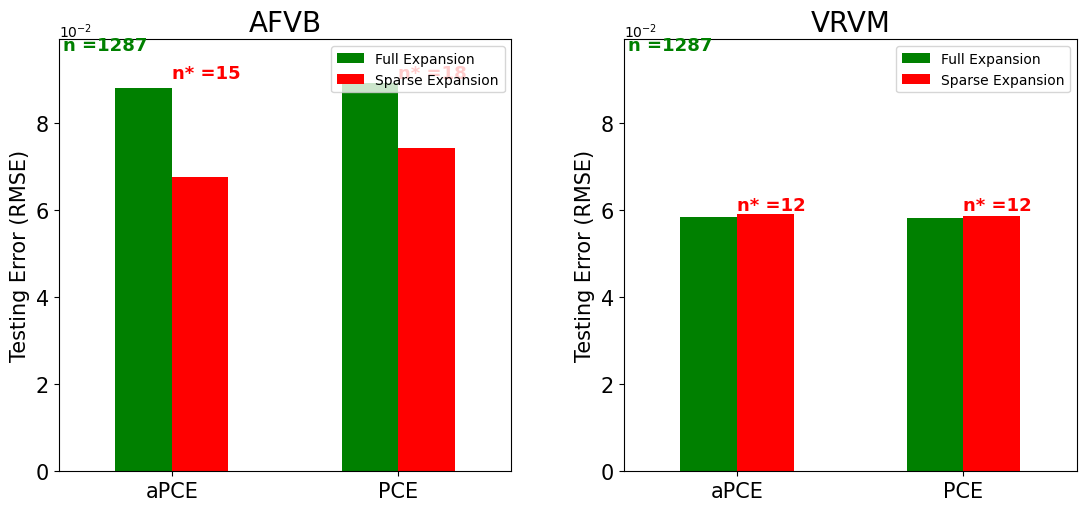

In [510]:
plot_Error(Error_AFVB_Sobol, Error_AFVB_PCE_Sobol, 
           Error_VRVM_Sobol, Error_VRVM_PCE_Sobol,
           100, '$10^{-2}$', mod_AFVB_Sobol.n)
#plt.savefig(wd + '/RMSE_Sobol.png')

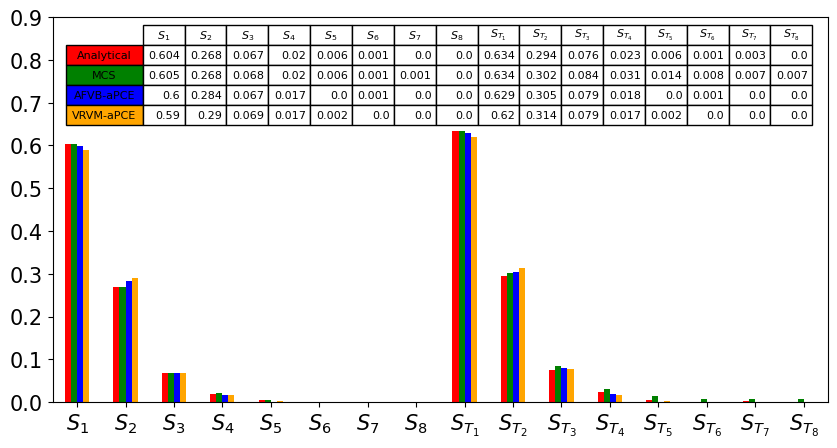

In [511]:
l = ['$S_1$', '$S_2$','$S_3$', '$S_4$', '$S_5$', '$S_6$', '$S_7$', '$S_8$',
     '$S_{T_1}$','$S_{T_2}$','$S_{T_3}$', '$S_{T_4}$','$S_{T_5}$','$S_{T_6}$','$S_{T_7}$','$S_{T_8}$']

plot_Sobol_Indices(GSA_Sobol, Sobol_MC_Sobol[0], 
           GSA_AFVB_Sobol, GSA_VRVM_Sobol,
                   l=l, ylimit=0.9, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_Sobol.png')

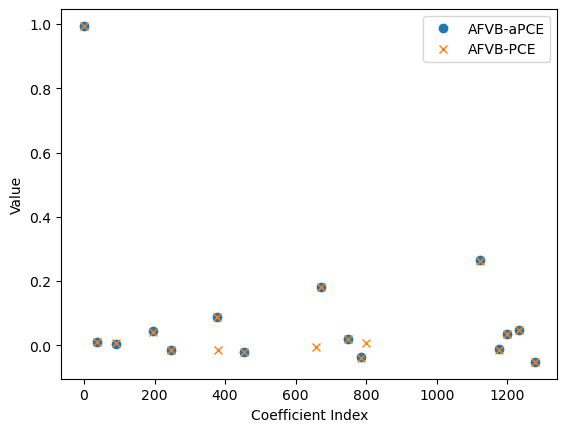

In [512]:
plt.plot(mod_AFVB_Sobol.active_cols, mod_AFVB_Sobol.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_Sobol.active_cols, mod_AFVB_PCE_Sobol.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_Sobol.png')

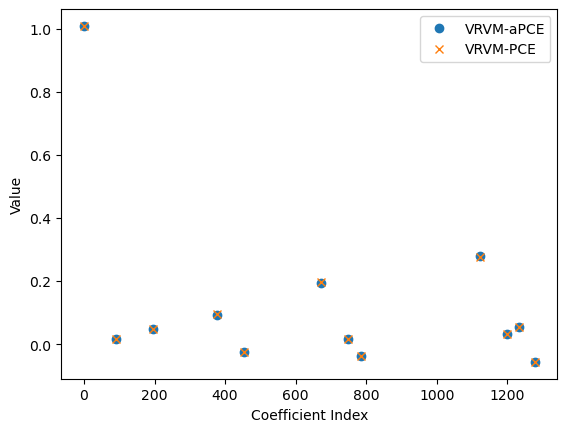

In [513]:
plt.plot(mod_VRVM_Sobol.active_cols, mod_VRVM_Sobol.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_Sobol.active_cols, mod_VRVM_PCE_Sobol.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_Sobol.png')

In [514]:
sns.kdeplot(mod_AFVB_PCE.Sobol.predict(X_test, active_cols_pce).reshape(N_test), color='b', label='AFVB_PCE')
sns.kdeplot(mod_AFVB.predict(X_test, active_cols).reshape(N_test), color='g', label='AFVB_aPCE')
sns.kdeplot(Sobol_Function(X_test).reshape(N_test), color='r', label='Sobol Function')
plt.legend();

NameError: name 'mod_AFVB_pce' is not defined

# Example 7: PDE

In [602]:
d = 2  # d --> number of random variables
p = 12  # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # n --> Number of terms in the PCE expansion

In [ ]:
X_train = np.random.normal(9/10, 1/4, size=(N_train, d))
X_test = np.random.normal(9/10, 1/4, size=(N_test, d))
X_pol = np.random.normal(9/10, 1/4, size=(N_pol, d))

idx = multivariate_pce_index(d, p)

In [ ]:
def PDE_Function(Z, t = 1):
    
    return -np.exp(-Z[:,0])*(t + (t - t**2/2)*np.exp(Z[:,1]))

In [ ]:
mod = aPCE(X_pol, p, idx)
P = mod.Create_Orthonormal_Polynomials(p)

In [ ]:
def basis_PCE_PDE(Z, p):
    "Z ~ N(9/10, 1/4)"
    d = Z.shape[1]
    N = Z.shape[0]
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
        
    idx = multivariate_pce_index(d, p)
    Phi = np.ones((N, n))
    
    for i in range(n):
        for j in range(d):
            Phi[:,i] *=  hermitenorm(idx[i][j])((Z[:,j]-0.9)/0.25)
    return Phi

# MC Sobol Indices

In [ ]:
dataA = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values
dataB = pd.DataFrame(np.random.uniform(0, 1, size=(N_mc, d))).values

Sobol_MC_PDE = MC_Sobol(PDE_Function, dataA, dataB)

# AFVB

In [ ]:
Error_AFVB_PDE, GSA_AFVB_PDE, mod_AFVB_PDE, V_AFVB_PDE = Results(PDE_Function, X_train, X_test, 
        AFVB_PCE(basis_aPCE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

In [ ]:
Error_AFVB_PCE_PDE, GSA_AFVB_PCE_PDE, mod_AFVB_PCE_PDE, V_AFVB_PCE_PDE = Results(PDE_Function, X_train, X_test, 
        AFVB_PCE(basis_PCE_PDE, p, A_0, B_0, C_0, D_0, T_ell, e), idx)

# VRVM

In [ ]:
data={'xi': X_train}
data['y'] = PDE_Function(X_train).reshape(N_train)

a_0 = 0.2
b_0 = 1.0

In [ ]:
Error_VRVM_PDE, GSA_VRVM_PDE, mod_VRVM_PDE, V_VRVM_PDE = Results(PDE_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_aPCE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

In [ ]:
Error_VRVM_PCE_PDE, GSA_VRVM_PCE_PDE, mod_VRVM_PCE_PDE, V_VRVM_PCE_PDE = Results(PDE_Function, data['xi'], X_test, 
        SparseVariationalOptimizer(basis_PCE_PDE, p, 1e-6, 1e-6, 1e-6, 1e-6, a_0, b_0), idx)

# Plots

In [ ]:
plot_Error(Error_AFVB_PDE, Error_AFVB_PCE_PDE, 
           Error_VRVM_PDE, Error_VRVM_PCE_PDE,
           100, '$10^{-2}$', mod_AFVB_PDE.n)
#plt.savefig(wd + '/RMSE_PDE.png')

In [ ]:
l = ['$S_1$', '$S_2$',
     '$S_{T_1}$','$S_{T_2}$']

plot_Sobol_Indices(Sobol_MC_PDE[0], 
           GSA_AFVB_PDE, GSA_VRVM_PDE,
                   l=l, ylimit=0.9, fig_size=(10,5), table_size=0.45);
#plt.savefig(wd + '/GSA_PDE.png')

In [ ]:
plt.plot(mod_AFVB_PDE.active_cols, mod_AFVB_PDE.a_hat, 'o', label = 'AFVB-aPCE')
plt.plot(mod_AFVB_PCE_PDE.active_cols, mod_AFVB_PCE_PDE.a_hat, 'x', label = 'AFVB-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_AFVB_PDE.png')

In [ ]:
plt.plot(mod_VRVM_PDE.active_cols, mod_VRVM_PDE.a_hat, 'o', label = 'VRVM-aPCE')
plt.plot(mod_VRVM_PCE_PDE.active_cols, mod_VRVM_PCE_PDE.a_hat, 'x', label = 'VRVM-PCE')
plt.legend()
plt.xlabel('Coefficient Index')
plt.ylabel('Value');
#plt.savefig(wd + '/Coeff_VRVM_PDE.png')

# Hyper-parameter Tunning

In [873]:
from bayes_opt import BayesianOptimization, UtilityFunction

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Define the black box function to optimize.
def black_box_function(C):
    # C: SVC hyper parameter to optimize for.
    model = SVC(C = C)
    model.fit(X_train_scaled, y_train)
    y_score = model.decision_function(X_test_scaled)
    f = roc_auc_score(y_test, y_score)
    return f
# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"C": [0.1, 10]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 4)
optimizer.maximize(init_points = 5, n_iter = 10)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))